In [193]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import numpy as np
import os
from numba import jit

%matplotlib inline
sns.set(style="whitegrid")


In [194]:
# Download current premier league table
team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values
  

team_df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
team_df.columns = cols
team_df = team_df.sort_values('Pos')
team_df['team'] = team_df.index
team_df = team_df[['team']+cols]
team_df.head(5)


,team,Pos,P_ov,W_ov,D_ov,L_ov,F_ov,A_ov,W_hm,D_hm,L_hm,F_hm,A_hm,W_aw,D_aw,L_aw,F_aw,A_aw,GD,PTS
Manchester City,Manchester City,1,30,26,3,1,85,20,14,1,0,51,10,12,2,1,34,10,65,81
Manchester United,Manchester United,2,30,20,5,5,58,23,12,2,1,33,7,8,3,4,25,16,35,65
Liverpool,Liverpool,3,31,18,9,4,73,34,10,6,0,38,10,8,3,4,35,24,39,63
Tottenham Hotspur,Tottenham Hotspur,4,30,18,7,5,59,25,10,4,1,31,9,8,3,4,28,16,34,61
Chelsea,Chelsea,5,30,17,5,8,52,27,10,2,3,26,11,7,3,5,26,16,25,56


In [195]:
# Download players from the FPL site's resource API
url = "https://fantasy.premierleague.com/drf/bootstrap-static"
r  = requests.get(url)
data = json.loads(r.text)

all_players = data['elements']
all_teams = data['teams']

team_codes = {}
for team in all_teams:
    team_codes[int(team['code'])] = team['short_name']

CE = data['current-event']
NE = data['next-event']
GW = CE

player_dict = {}
position_dict = {}
cost_dict = {}
status_dict = {}
team_dict = {}
for i in all_players:
    player_dict[i['id']] = i['web_name']
    position_dict[i['id']] = i['element_type']
    cost_dict[i['id']] = i['now_cost']
    status_dict[i['id']] = i['status']
    
    # some players get transferred out of PL and have invalid teams
    try:
        team_dict[i['id']] = team_codes[i['team_code']]
    except KeyError:
        team_dict[i['id']] = ''
        print("KeyError - player has invalid team: id %d, team code%d" % (i['id'], i['team_code']))
   

# Download player history
history_dict = {};
current_dict = {};
for i in player_dict: 
    url = "https://fantasy.premierleague.com/drf/element-summary/" + str(i)
    r  = requests.get(url)
    data = json.loads(r.text)
    # data['fixtures']
    history = data['history']
    history_past = data['history_past']
   
    # Dataset with total_points per historic season and calculated average points per season
    points_seasons = np.zeros((12,), dtype=np.int)
    for season in history_past:
        points_seasons[season['season']] = int(season['total_points']) 
   
    history_dict[i] = points_seasons
    
    # Dataset with points for current season
    points_this = np.zeros((GW+1,), dtype=np.int)
    for game in history:
        points_this[int(game['round'])-1] = int(game['total_points'])
    
    current_dict[i] = points_this
        
print("Player data downloaded..")
        

Player data downloaded..


In [196]:
team_codes

{1: 'MUN',
 3: 'ARS',
 4: 'NEW',
 6: 'TOT',
 8: 'CHE',
 11: 'EVE',
 13: 'LEI',
 14: 'LIV',
 20: 'SOU',
 21: 'WHU',
 31: 'CRY',
 35: 'WBA',
 36: 'BHA',
 38: 'HUD',
 43: 'MCI',
 57: 'WAT',
 80: 'SWA',
 90: 'BUR',
 91: 'BOU',
 110: 'STK'}

In [197]:
# GameWeek
GW

31

In [198]:
# Next GameWeek
NE

32

In [249]:
df = pd.DataFrame.from_dict(history_dict, orient='index')
cols = ['2005/06', '2006/07', '2007/08', '2008/09', '2009/10', '2010/11',
           '2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17']
df.columns = cols
df.insert(0, 'Name', player_dict.values())
df.insert(1, 'Position', position_dict.values())
df.insert(2, "Cost", cost_dict.values())
df.insert(3, "Status", status_dict.values())
df.insert(4, "Team", team_dict.values())
df = df.replace(0, np.NaN)
df2 = df[['2015/16','2016/17']]
df['avg2yr'] = df2.mean(axis=1)
df['cost-pt'] = df['Cost']/df['avg2yr']
df = df.sort_values('2016/17', axis=0, ascending=False)
df.drop(['2005/06','2006/07'], axis=1, inplace=True)
df[df['Name']=='Davies']

,Name,Position,Cost,Status,Team,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
381,Davies,2,59,a,TOT,NaN,NaN,NaN,NaN,NaN,99.0,99.0,31.0,52.0,90.0,71.0,0.830986
156,Davies,3,51,d,EVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,63.0,33.5,1.522388


In [250]:
df1 = pd.DataFrame.from_dict(current_dict, orient='index')
cols = list(range(1,NE+1))
df1.columns = cols
df1.head(5)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,3,2,6,10,6,6,1,1,2,...,2,3,1,2,4,1,2,15,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,6,7,6,0,2,0,2,...,0,10,1,7,2,1,1,0,0,0
5,0,0,0,0,0,0,0,9,1,2,...,0,0,0,0,0,0,0,0,0,0


In [251]:
df1.insert(0, 'Name', player_dict.values())
df1.insert(1, 'Position', position_dict.values())
df1.insert(2, "Cost", cost_dict.values())
df1.insert(3, "Total_Points", df1[list(range(1,GW+2))].sum(axis=1))
df1.insert(4, "Points_Cost", df1["Total_Points"]/df1["Cost"])
df1.insert(5, "Points_Fixture", df1["Total_Points"]/GW)
df1.insert(6, "Status", status_dict.values())
df1.insert(7, "Team", team_dict.values())
#df1 = df1.replace(0, np.NaN)
df1 = df1.sort_values(['Position','Points_Cost'], axis=0, ascending=False)

df1.head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,Team,1,2,...,23,24,25,26,27,28,29,30,31,32
373,Jordan Ayew,4,53,91,1.716981,2.935484,s,SWA,2,2,...,8,2,8,2,2,2,7,-2,0,0
235,Firmino,4,97,163,1.680412,5.258065,a,LIV,12,2,...,8,2,8,2,12,8,5,2,7,0
71,Murray,4,59,99,1.677966,3.193548,a,BHA,1,2,...,2,1,8,6,2,12,7,2,0,0
159,Calvert-Lewin,4,50,81,1.620000,2.612903,a,EVE,5,5,...,1,0,1,5,0,1,1,1,4,0
209,Vardy,4,87,135,1.551724,4.354839,a,LEI,13,2,...,2,9,7,6,5,2,2,5,0,0
437,Rodriguez,4,53,82,1.547170,2.645161,a,WBA,1,2,...,5,9,2,1,2,2,2,1,7,0
187,Depoitre,4,51,78,1.529412,2.516129,a,HUD,0,0,...,2,1,2,2,0,1,1,1,0,0
348,Diouf,4,52,77,1.480769,2.483871,d,STK,2,2,...,1,7,1,1,2,1,1,0,0,0
548,Niasse,4,49,72,1.469388,2.322581,a,EVE,0,0,...,0,7,2,2,12,1,1,0,0,0
161,Rooney,4,72,105,1.458333,3.387097,a,EVE,9,8,...,1,1,2,0,2,2,1,0,3,0


In [252]:
#Attackers
df1_attack = df1[df1['Position']==4]
df1_attack.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,Team,1,2,...,23,24,25,26,27,28,29,30,31,32
394,Kane,4,127,178,1.401575,5.741935,i,TOT,1,1,...,13,8,2,4,6,6,5,1,0,0
257,Agüero,4,118,169,1.432203,5.451613,d,MCI,9,2,...,5,17,6,2,21,5,2,0,0,0
235,Firmino,4,97,163,1.680412,5.258065,a,LIV,12,2,...,8,2,8,2,12,8,5,2,7,0
285,Lukaku,4,114,144,1.263158,4.645161,a,MUN,13,6,...,5,5,2,6,2,12,8,5,0,0
209,Vardy,4,87,135,1.551724,4.354839,a,LEI,13,2,...,2,9,7,6,5,2,2,5,0,0
161,Rooney,4,72,105,1.458333,3.387097,a,EVE,9,8,...,1,1,2,0,2,2,1,0,3,0
472,Morata,4,104,103,0.990385,3.322581,a,CHE,10,2,...,1,0,0,0,4,1,1,0,0,0
28,Lacazette,4,102,99,0.970588,3.193548,i,ARS,6,2,...,2,8,2,0,1,0,0,0,0,0
71,Murray,4,59,99,1.677966,3.193548,a,BHA,1,2,...,2,1,8,6,2,12,7,2,0,0
373,Jordan Ayew,4,53,91,1.716981,2.935484,s,SWA,2,2,...,8,2,8,2,2,2,7,-2,0,0


In [253]:
#Goalies
df1_gk = df1[df1['Position']==1]
df1_gk.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,Team,1,2,...,23,24,25,26,27,28,29,30,31,32
260,de Gea,1,59,144,2.440678,4.645161,a,MUN,6,6,...,7,6,2,6,2,4,1,2,0,0
240,Ederson,1,56,138,2.464286,4.451613,a,MCI,6,2,...,1,3,6,2,2,15,6,7,0,0
469,Pope,1,49,131,2.673469,4.225806,a,BUR,0,0,...,2,2,11,5,3,3,3,9,0,0
350,Fabianski,1,47,123,2.617021,3.967742,a,SWA,6,1,...,3,8,3,3,6,0,2,9,0,0
54,Ryan,1,45,115,2.555556,3.709677,a,BHA,2,1,...,1,2,2,2,8,2,4,7,0,0
135,Pickford,1,49,114,2.326531,3.677419,a,EVE,6,4,...,2,3,2,0,3,3,3,7,3,0
94,Courtois,1,54,113,2.092593,3.645161,d,CHE,1,6,...,6,0,1,1,6,2,2,2,0,0
2,Cech,1,53,112,2.113208,3.612903,a,ARS,1,3,...,2,3,1,2,4,1,2,15,0,0
163,Lössl,1,46,112,2.434783,3.612903,a,HUD,9,8,...,0,2,2,10,2,2,2,6,2,0
375,Lloris,1,54,107,1.981481,3.451613,a,TOT,7,1,...,6,0,7,1,6,7,7,2,0,0


In [254]:
#Defs
df1_def = df1[df1['Position']==2]
df1_def.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,Team,1,2,...,23,24,25,26,27,28,29,30,31,32
100,Alonso,2,72,143,1.986111,4.612903,a,CHE,0,16,...,8,6,1,0,0,1,2,2,0,0
97,Azpilicueta,2,69,142,2.057971,4.580645,a,CHE,1,2,...,7,6,1,0,8,1,2,3,0,0
245,Otamendi,2,64,142,2.218750,4.580645,a,MCI,8,2,...,-1,2,6,2,2,5,6,8,0,0
267,Valencia,2,69,128,1.855072,4.129032,a,MUN,5,6,...,15,5,1,6,1,1,4,1,0,0
379,Walker,2,66,124,1.878788,4.000000,a,MCI,6,-2,...,3,2,6,2,2,10,6,6,0,0
381,Davies,2,59,119,2.016949,3.838710,a,TOT,14,2,...,6,8,6,1,12,7,6,0,0,0
10,Monreal,2,55,112,2.036364,3.612903,a,ARS,1,2,...,0,16,8,1,2,0,0,0,0,0
380,Vertonghen,2,60,103,1.716667,3.322581,a,TOT,6,0,...,6,2,7,1,8,0,8,2,0,0
198,Maguire,2,56,102,1.821429,3.290323,a,LEI,3,15,...,6,8,1,2,-1,2,2,2,0,0
7,Bellerín,2,59,101,1.711864,3.258065,a,ARS,1,2,...,8,2,0,2,2,1,1,0,0,0


In [255]:
#Mids
df1_mid = df1[df1['Position']==3]
df1_mid.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,Team,1,2,...,23,24,25,26,27,28,29,30,31,32
234,Salah,3,107,266,2.485981,8.580645,a,LIV,11,1,...,11,2,8,15,13,10,8,2,29,0
252,De Bruyne,3,104,183,1.759615,5.903226,a,MCI,3,2,...,2,6,14,2,13,3,3,3,0,0
247,Sterling,3,86,179,2.081395,5.774194,a,MCI,0,6,...,1,5,10,3,8,0,0,6,0,0
199,Mahrez,3,88,161,1.829545,5.193548,a,LEI,5,11,...,3,8,0,0,1,2,10,11,0,0
390,Son,3,82,151,1.841463,4.870968,a,TOT,1,1,...,13,2,3,2,3,1,16,15,0,0
104,Hazard,3,106,149,1.405660,4.806452,a,CHE,0,0,...,1,16,2,8,16,6,2,3,0,0
387,Eriksen,3,94,147,1.563830,4.741935,a,TOT,12,7,...,9,0,10,2,3,6,3,5,0,0
248,David Silva,3,81,141,1.740741,4.548387,a,MCI,8,2,...,0,2,0,0,0,8,9,16,0,0
255,Sané,3,86,137,1.593023,4.419355,a,MCI,1,2,...,7,5,0,0,0,13,3,3,0,0
70,Groß,3,60,135,2.250000,4.354839,a,BHA,2,2,...,2,2,2,13,2,5,6,2,0,0


In [256]:
# Zero scores where no data
g = df1_gk.fillna(0)
d = df1_def.fillna(0)
m = df1_mid.fillna(0)
a = df1_attack.fillna(0)

# Last 6 match rolling average
r6 = list(range(GW-5, GW+1))
g['PFA6'] = g[r6].sum(axis=1)/6
d['PFA6'] = d[r6].sum(axis=1)/6
m['PFA6'] = m[r6].sum(axis=1)/6
a['PFA6'] = a[r6].sum(axis=1)/6
df1['PFA6'] = df1[r6].sum(axis=1)/6

# Last 3 match rolling average
r3 = list(range(GW-2, GW+1))
g['PFA3'] = g[r3].sum(axis=1)/6
d['PFA3'] = d[r3].sum(axis=1)/6
m['PFA3'] = m[r3].sum(axis=1)/6
a['PFA3'] = a[r3].sum(axis=1)/6
df1['PFA3'] = df1[r3].sum(axis=1)/6

# not injured
g = g[g['Status']=='a']
d = d[d['Status']=='a']
m = m[m['Status']=='a']
a = a[a['Status']=='a']


In [257]:
# Team constellation
MAX_NGK = 2
MAX_NDEF = 5
MAX_NMID = 5
MAX_NFWD = 3

#High Ownership Players

# Otamendi (245), Alonso, Davies
HO_DEF = np.array([])

# Salah, Sterling 247, Mahrez 199
HO_MID = np.array([199, 234])

# Kane, (Firmino is 235), (Augero 257), Lukaku (285)
# Kane is injured :(
# 616 is Aubameyang
HO_FWD = np.array([616])

In [258]:
# Filter out DGW34 and DGW37 Teams
dgw_teams=['TOT', 'CHE', 'MUN', 'SOU', 'LEI', 'BHA', 'ARS', 'LIV']

g = g[g['Team'].isin(dgw_teams)]
d = d[d['Team'].isin(dgw_teams)]
m = m[m['Team'].isin(dgw_teams)]
a = a[a['Team'].isin(dgw_teams)]

In [259]:
# Only pick from performing players who are not earmarked as High Ownership (HO)
np1_gk_f = g[(g['PFA6'] > np.percentile(g['PFA6'],60))].index.values
np1_def_f = d[(d['PFA6'] > np.percentile(d['PFA6'],65))].drop(HO_DEF).index.values
np1_mid_f = m[(m['PFA6'] > np.percentile(m['PFA6'],65))].drop(HO_MID).index.values
np1_fwd_f = a[(a['PFA6'] > np.percentile(a['PFA6'],75))].drop(HO_FWD).index.values


In [260]:
# How many players to pick in each position
pdef = MAX_NDEF - len(HO_DEF)
pmid = MAX_NMID - len(HO_MID)
pfwd = MAX_NFWD - len(HO_FWD)

In [261]:
# Max team budget
MAX_COST = 1015

In [ ]:
# Department of Brute force

MAX_EPOCHS = 20000000
INTERVAL = MAX_EPOCHS // 100000

epoch = 0
max_score = 60
max_tm = df1.sample(n=15)

def TimestampMillisec64():
    return int((datetime.datetime.utcnow() - datetime.datetime(1970, 1, 1)).total_seconds() * 1000) 

@jit(nopython=True, cache=True)
def pick_n(n, arr):
    rnd = np.random.choice(arr, n, replace=False)
    return rnd

@jit(nopython=True, cache=True)
def build_team(gks, defs, mids, mfwd):
    tm = np.concatenate((HO_DEF,defs,HO_MID,mids,HO_FWD,mfwd,gks))
    return tm

t1 = TimestampMillisec64()
while (epoch < MAX_EPOCHS):
    epoch = epoch + 1
    if epoch%INTERVAL == 0:
        t2 = TimestampMillisec64()
        print("Time %d, Epoch %d .." % (round((t2-t1)/1000), epoch))
        t1 = t2
     
    tm = build_team(pick_n(MAX_NGK, np1_gk_f),
                    pick_n(pdef, np1_def_f),
                    pick_n(pmid, np1_mid_f),
                    pick_n(pfwd, np1_fwd_f)
                   )
    
    pd_max_tm = df1.loc[tm]
    tm_cost = pd_max_tm.sum(axis=0)['Cost']
    tm_score = pd_max_tm.sum(axis=0)['PFA6'] 
            
    if ((tm_score > max_score) and (tm_cost < MAX_COST)):
        max_score = tm_score
        fname = os.path.join('output', 'DGW_1015_Team_Agg_%d_PFA6_%d.csv' % (max_score, TimestampMillisec64()))
        pd_max_tm.to_csv(path_or_buf=fname)
        print("Epoch: %d, PFA6: %d, Cost: %d" % (epoch, tm_score, tm_cost))
                

Epoch: 6, PFA6: 65, Cost: 976
Epoch: 40, PFA6: 66, Cost: 1011
Time 0, Epoch 200 ..
Epoch: 268, PFA6: 67, Cost: 1003
Time 0, Epoch 400 ..
Epoch: 403, PFA6: 68, Cost: 969
Time 0, Epoch 600 ..
Time 0, Epoch 800 ..
Time 0, Epoch 1000 ..
Time 0, Epoch 1200 ..
Time 0, Epoch 1400 ..
Time 0, Epoch 1600 ..
Time 0, Epoch 1800 ..
Epoch: 1863, PFA6: 69, Cost: 997
Time 0, Epoch 2000 ..
Time 0, Epoch 2200 ..
Time 0, Epoch 2400 ..
Time 0, Epoch 2600 ..
Time 0, Epoch 2800 ..
Epoch: 2852, PFA6: 71, Cost: 994
Time 0, Epoch 3000 ..
Time 0, Epoch 3200 ..
Time 0, Epoch 3400 ..
Time 0, Epoch 3600 ..
Time 0, Epoch 3800 ..
Time 0, Epoch 4000 ..
Time 0, Epoch 4200 ..
Time 0, Epoch 4400 ..
Time 0, Epoch 4600 ..
Time 0, Epoch 4800 ..
Time 0, Epoch 5000 ..
Time 0, Epoch 5200 ..
Time 0, Epoch 5400 ..
Time 0, Epoch 5600 ..
Time 0, Epoch 5800 ..
Time 0, Epoch 6000 ..
Time 0, Epoch 6200 ..
Time 0, Epoch 6400 ..
Time 0, Epoch 6600 ..
Time 0, Epoch 6800 ..
Time 0, Epoch 7000 ..
Time 0, Epoch 7200 ..
Time 0, Epoch 7400 

Time 0, Epoch 69800 ..
Time 0, Epoch 70000 ..
Time 0, Epoch 70200 ..
Time 0, Epoch 70400 ..
Time 0, Epoch 70600 ..
Time 0, Epoch 70800 ..
Time 0, Epoch 71000 ..
Time 0, Epoch 71200 ..
Time 0, Epoch 71400 ..
Time 0, Epoch 71600 ..
Time 0, Epoch 71800 ..
Time 0, Epoch 72000 ..
Time 0, Epoch 72200 ..
Time 0, Epoch 72400 ..
Time 0, Epoch 72600 ..
Time 0, Epoch 72800 ..
Time 0, Epoch 73000 ..
Time 0, Epoch 73200 ..
Time 0, Epoch 73400 ..
Time 0, Epoch 73600 ..
Time 0, Epoch 73800 ..
Time 0, Epoch 74000 ..
Time 0, Epoch 74200 ..
Time 0, Epoch 74400 ..
Time 0, Epoch 74600 ..
Time 0, Epoch 74800 ..
Time 0, Epoch 75000 ..
Time 0, Epoch 75200 ..
Time 0, Epoch 75400 ..
Time 0, Epoch 75600 ..
Time 0, Epoch 75800 ..
Time 0, Epoch 76000 ..
Time 0, Epoch 76200 ..
Time 0, Epoch 76400 ..
Time 0, Epoch 76600 ..
Time 0, Epoch 76800 ..
Time 0, Epoch 77000 ..
Time 0, Epoch 77200 ..
Time 0, Epoch 77400 ..
Time 0, Epoch 77600 ..
Time 0, Epoch 77800 ..
Time 0, Epoch 78000 ..
Time 0, Epoch 78200 ..
Time 0, Epo

Time 0, Epoch 138600 ..
Time 0, Epoch 138800 ..
Time 0, Epoch 139000 ..
Time 0, Epoch 139200 ..
Time 0, Epoch 139400 ..
Time 0, Epoch 139600 ..
Time 0, Epoch 139800 ..
Time 0, Epoch 140000 ..
Time 0, Epoch 140200 ..
Time 0, Epoch 140400 ..
Time 0, Epoch 140600 ..
Time 0, Epoch 140800 ..
Time 0, Epoch 141000 ..
Time 0, Epoch 141200 ..
Time 0, Epoch 141400 ..
Time 0, Epoch 141600 ..
Time 0, Epoch 141800 ..
Time 0, Epoch 142000 ..
Time 0, Epoch 142200 ..
Time 0, Epoch 142400 ..
Time 0, Epoch 142600 ..
Time 0, Epoch 142800 ..
Time 0, Epoch 143000 ..
Time 0, Epoch 143200 ..
Time 0, Epoch 143400 ..
Time 0, Epoch 143600 ..
Time 0, Epoch 143800 ..
Time 0, Epoch 144000 ..
Time 0, Epoch 144200 ..
Time 0, Epoch 144400 ..
Time 0, Epoch 144600 ..
Time 0, Epoch 144800 ..
Time 0, Epoch 145000 ..
Time 0, Epoch 145200 ..
Time 0, Epoch 145400 ..
Time 0, Epoch 145600 ..
Time 0, Epoch 145800 ..
Time 0, Epoch 146000 ..
Time 0, Epoch 146200 ..
Time 0, Epoch 146400 ..
Time 0, Epoch 146600 ..
Time 0, Epoch 14

Time 0, Epoch 207000 ..
Time 0, Epoch 207200 ..
Time 0, Epoch 207400 ..
Time 0, Epoch 207600 ..
Time 0, Epoch 207800 ..
Time 0, Epoch 208000 ..
Time 0, Epoch 208200 ..
Time 0, Epoch 208400 ..
Time 0, Epoch 208600 ..
Time 0, Epoch 208800 ..
Time 0, Epoch 209000 ..
Time 0, Epoch 209200 ..
Time 0, Epoch 209400 ..
Time 0, Epoch 209600 ..
Time 0, Epoch 209800 ..
Time 0, Epoch 210000 ..
Time 0, Epoch 210200 ..
Time 0, Epoch 210400 ..
Time 0, Epoch 210600 ..
Time 0, Epoch 210800 ..
Time 0, Epoch 211000 ..
Time 0, Epoch 211200 ..
Time 0, Epoch 211400 ..
Time 0, Epoch 211600 ..
Time 0, Epoch 211800 ..
Time 0, Epoch 212000 ..
Time 0, Epoch 212200 ..
Time 0, Epoch 212400 ..
Time 0, Epoch 212600 ..
Time 0, Epoch 212800 ..
Time 0, Epoch 213000 ..
Time 0, Epoch 213200 ..
Time 0, Epoch 213400 ..
Time 0, Epoch 213600 ..
Time 0, Epoch 213800 ..
Time 0, Epoch 214000 ..
Time 0, Epoch 214200 ..
Time 0, Epoch 214400 ..
Time 0, Epoch 214600 ..
Time 0, Epoch 214800 ..
Time 0, Epoch 215000 ..
Time 0, Epoch 21

Time 0, Epoch 275400 ..
Time 0, Epoch 275600 ..
Time 0, Epoch 275800 ..
Time 0, Epoch 276000 ..
Time 0, Epoch 276200 ..
Time 0, Epoch 276400 ..
Time 0, Epoch 276600 ..
Time 0, Epoch 276800 ..
Time 0, Epoch 277000 ..
Time 0, Epoch 277200 ..
Time 0, Epoch 277400 ..
Time 0, Epoch 277600 ..
Time 0, Epoch 277800 ..
Time 0, Epoch 278000 ..
Time 0, Epoch 278200 ..
Time 0, Epoch 278400 ..
Time 0, Epoch 278600 ..
Time 0, Epoch 278800 ..
Time 0, Epoch 279000 ..
Time 0, Epoch 279200 ..
Time 0, Epoch 279400 ..
Time 0, Epoch 279600 ..
Time 0, Epoch 279800 ..
Time 0, Epoch 280000 ..
Time 0, Epoch 280200 ..
Time 0, Epoch 280400 ..
Time 0, Epoch 280600 ..
Time 0, Epoch 280800 ..
Time 0, Epoch 281000 ..
Time 0, Epoch 281200 ..
Time 0, Epoch 281400 ..
Time 0, Epoch 281600 ..
Time 0, Epoch 281800 ..
Time 0, Epoch 282000 ..
Time 0, Epoch 282200 ..
Time 0, Epoch 282400 ..
Time 0, Epoch 282600 ..
Time 0, Epoch 282800 ..
Time 0, Epoch 283000 ..
Time 0, Epoch 283200 ..
Time 0, Epoch 283400 ..
Time 0, Epoch 28

Time 0, Epoch 343800 ..
Time 0, Epoch 344000 ..
Time 0, Epoch 344200 ..
Time 0, Epoch 344400 ..
Time 0, Epoch 344600 ..
Time 0, Epoch 344800 ..
Time 0, Epoch 345000 ..
Time 0, Epoch 345200 ..
Time 0, Epoch 345400 ..
Time 0, Epoch 345600 ..
Time 0, Epoch 345800 ..
Time 0, Epoch 346000 ..
Time 0, Epoch 346200 ..
Time 0, Epoch 346400 ..
Time 0, Epoch 346600 ..
Time 0, Epoch 346800 ..
Time 0, Epoch 347000 ..
Time 0, Epoch 347200 ..
Time 0, Epoch 347400 ..
Time 0, Epoch 347600 ..
Time 0, Epoch 347800 ..
Time 0, Epoch 348000 ..
Time 0, Epoch 348200 ..
Time 0, Epoch 348400 ..
Time 0, Epoch 348600 ..
Time 0, Epoch 348800 ..
Time 0, Epoch 349000 ..
Time 0, Epoch 349200 ..
Time 0, Epoch 349400 ..
Time 0, Epoch 349600 ..
Time 0, Epoch 349800 ..
Time 0, Epoch 350000 ..
Time 0, Epoch 350200 ..
Time 0, Epoch 350400 ..
Time 0, Epoch 350600 ..
Time 0, Epoch 350800 ..
Time 0, Epoch 351000 ..
Time 0, Epoch 351200 ..
Time 0, Epoch 351400 ..
Time 0, Epoch 351600 ..
Time 0, Epoch 351800 ..
Time 0, Epoch 35

Time 0, Epoch 411800 ..
Time 0, Epoch 412000 ..
Time 0, Epoch 412200 ..
Time 0, Epoch 412400 ..
Time 0, Epoch 412600 ..
Time 0, Epoch 412800 ..
Time 0, Epoch 413000 ..
Time 0, Epoch 413200 ..
Time 0, Epoch 413400 ..
Time 0, Epoch 413600 ..
Time 0, Epoch 413800 ..
Time 0, Epoch 414000 ..
Time 0, Epoch 414200 ..
Time 0, Epoch 414400 ..
Time 0, Epoch 414600 ..
Time 0, Epoch 414800 ..
Time 0, Epoch 415000 ..
Time 0, Epoch 415200 ..
Time 0, Epoch 415400 ..
Time 0, Epoch 415600 ..
Time 0, Epoch 415800 ..
Time 0, Epoch 416000 ..
Time 0, Epoch 416200 ..
Time 0, Epoch 416400 ..
Time 0, Epoch 416600 ..
Time 0, Epoch 416800 ..
Time 0, Epoch 417000 ..
Time 0, Epoch 417200 ..
Time 0, Epoch 417400 ..
Time 0, Epoch 417600 ..
Time 0, Epoch 417800 ..
Time 0, Epoch 418000 ..
Time 0, Epoch 418200 ..
Time 0, Epoch 418400 ..
Time 0, Epoch 418600 ..
Time 0, Epoch 418800 ..
Time 0, Epoch 419000 ..
Time 0, Epoch 419200 ..
Time 0, Epoch 419400 ..
Time 0, Epoch 419600 ..
Time 0, Epoch 419800 ..
Time 0, Epoch 42

Time 0, Epoch 480200 ..
Time 0, Epoch 480400 ..
Time 0, Epoch 480600 ..
Time 0, Epoch 480800 ..
Time 0, Epoch 481000 ..
Time 0, Epoch 481200 ..
Time 0, Epoch 481400 ..
Time 0, Epoch 481600 ..
Time 0, Epoch 481800 ..
Time 0, Epoch 482000 ..
Time 0, Epoch 482200 ..
Time 0, Epoch 482400 ..
Time 0, Epoch 482600 ..
Time 0, Epoch 482800 ..
Time 0, Epoch 483000 ..
Time 0, Epoch 483200 ..
Time 0, Epoch 483400 ..
Time 0, Epoch 483600 ..
Time 0, Epoch 483800 ..
Time 0, Epoch 484000 ..
Time 0, Epoch 484200 ..
Time 0, Epoch 484400 ..
Time 0, Epoch 484600 ..
Time 0, Epoch 484800 ..
Time 0, Epoch 485000 ..
Time 0, Epoch 485200 ..
Time 0, Epoch 485400 ..
Time 0, Epoch 485600 ..
Time 0, Epoch 485800 ..
Time 0, Epoch 486000 ..
Time 0, Epoch 486200 ..
Time 0, Epoch 486400 ..
Time 0, Epoch 486600 ..
Time 0, Epoch 486800 ..
Time 0, Epoch 487000 ..
Time 0, Epoch 487200 ..
Time 0, Epoch 487400 ..
Time 0, Epoch 487600 ..
Time 0, Epoch 487800 ..
Time 0, Epoch 488000 ..
Time 0, Epoch 488200 ..
Time 0, Epoch 48

Time 0, Epoch 548600 ..
Time 0, Epoch 548800 ..
Time 0, Epoch 549000 ..
Time 0, Epoch 549200 ..
Time 0, Epoch 549400 ..
Time 0, Epoch 549600 ..
Time 0, Epoch 549800 ..
Time 0, Epoch 550000 ..
Time 0, Epoch 550200 ..
Time 0, Epoch 550400 ..
Time 0, Epoch 550600 ..
Time 0, Epoch 550800 ..
Time 0, Epoch 551000 ..
Time 0, Epoch 551200 ..
Time 0, Epoch 551400 ..
Time 0, Epoch 551600 ..
Time 0, Epoch 551800 ..
Time 0, Epoch 552000 ..
Time 0, Epoch 552200 ..
Time 0, Epoch 552400 ..
Time 0, Epoch 552600 ..
Time 0, Epoch 552800 ..
Time 0, Epoch 553000 ..
Time 0, Epoch 553200 ..
Time 0, Epoch 553400 ..
Time 0, Epoch 553600 ..
Time 0, Epoch 553800 ..
Time 0, Epoch 554000 ..
Time 0, Epoch 554200 ..
Time 0, Epoch 554400 ..
Time 0, Epoch 554600 ..
Time 0, Epoch 554800 ..
Time 0, Epoch 555000 ..
Time 0, Epoch 555200 ..
Time 0, Epoch 555400 ..
Time 0, Epoch 555600 ..
Time 0, Epoch 555800 ..
Time 0, Epoch 556000 ..
Time 0, Epoch 556200 ..
Time 0, Epoch 556400 ..
Time 0, Epoch 556600 ..
Time 0, Epoch 55

Time 0, Epoch 616600 ..
Time 0, Epoch 616800 ..
Time 0, Epoch 617000 ..
Time 0, Epoch 617200 ..
Time 0, Epoch 617400 ..
Time 0, Epoch 617600 ..
Time 0, Epoch 617800 ..
Time 0, Epoch 618000 ..
Time 0, Epoch 618200 ..
Time 0, Epoch 618400 ..
Time 0, Epoch 618600 ..
Time 0, Epoch 618800 ..
Time 0, Epoch 619000 ..
Time 0, Epoch 619200 ..
Time 0, Epoch 619400 ..
Time 0, Epoch 619600 ..
Time 0, Epoch 619800 ..
Time 0, Epoch 620000 ..
Time 0, Epoch 620200 ..
Time 0, Epoch 620400 ..
Time 0, Epoch 620600 ..
Time 0, Epoch 620800 ..
Time 0, Epoch 621000 ..
Time 0, Epoch 621200 ..
Time 0, Epoch 621400 ..
Time 0, Epoch 621600 ..
Time 0, Epoch 621800 ..
Time 0, Epoch 622000 ..
Time 0, Epoch 622200 ..
Time 0, Epoch 622400 ..
Time 0, Epoch 622600 ..
Time 0, Epoch 622800 ..
Time 0, Epoch 623000 ..
Time 0, Epoch 623200 ..
Time 0, Epoch 623400 ..
Time 0, Epoch 623600 ..
Time 0, Epoch 623800 ..
Time 0, Epoch 624000 ..
Time 0, Epoch 624200 ..
Time 0, Epoch 624400 ..
Time 0, Epoch 624600 ..
Time 0, Epoch 62

Time 0, Epoch 685000 ..
Time 0, Epoch 685200 ..
Time 0, Epoch 685400 ..
Time 0, Epoch 685600 ..
Time 0, Epoch 685800 ..
Time 0, Epoch 686000 ..
Time 0, Epoch 686200 ..
Time 0, Epoch 686400 ..
Time 0, Epoch 686600 ..
Time 0, Epoch 686800 ..
Time 0, Epoch 687000 ..
Time 0, Epoch 687200 ..
Time 0, Epoch 687400 ..
Time 0, Epoch 687600 ..
Time 0, Epoch 687800 ..
Time 0, Epoch 688000 ..
Time 0, Epoch 688200 ..
Time 0, Epoch 688400 ..
Time 0, Epoch 688600 ..
Time 0, Epoch 688800 ..
Time 0, Epoch 689000 ..
Time 0, Epoch 689200 ..
Time 0, Epoch 689400 ..
Time 0, Epoch 689600 ..
Time 0, Epoch 689800 ..
Time 0, Epoch 690000 ..
Time 0, Epoch 690200 ..
Time 0, Epoch 690400 ..
Time 0, Epoch 690600 ..
Time 0, Epoch 690800 ..
Time 0, Epoch 691000 ..
Time 0, Epoch 691200 ..
Time 0, Epoch 691400 ..
Time 0, Epoch 691600 ..
Time 0, Epoch 691800 ..
Time 0, Epoch 692000 ..
Time 0, Epoch 692200 ..
Time 0, Epoch 692400 ..
Time 0, Epoch 692600 ..
Time 0, Epoch 692800 ..
Time 0, Epoch 693000 ..
Time 0, Epoch 69

Time 0, Epoch 753400 ..
Time 0, Epoch 753600 ..
Time 0, Epoch 753800 ..
Time 0, Epoch 754000 ..
Time 0, Epoch 754200 ..
Time 0, Epoch 754400 ..
Time 0, Epoch 754600 ..
Time 0, Epoch 754800 ..
Time 0, Epoch 755000 ..
Time 0, Epoch 755200 ..
Time 0, Epoch 755400 ..
Time 0, Epoch 755600 ..
Time 0, Epoch 755800 ..
Time 0, Epoch 756000 ..
Time 0, Epoch 756200 ..
Time 0, Epoch 756400 ..
Time 0, Epoch 756600 ..
Time 0, Epoch 756800 ..
Time 0, Epoch 757000 ..
Time 0, Epoch 757200 ..
Time 0, Epoch 757400 ..
Time 0, Epoch 757600 ..
Time 0, Epoch 757800 ..
Time 0, Epoch 758000 ..
Time 0, Epoch 758200 ..
Time 0, Epoch 758400 ..
Time 0, Epoch 758600 ..
Time 0, Epoch 758800 ..
Time 0, Epoch 759000 ..
Time 0, Epoch 759200 ..
Time 0, Epoch 759400 ..
Time 0, Epoch 759600 ..
Time 0, Epoch 759800 ..
Time 0, Epoch 760000 ..
Time 0, Epoch 760200 ..
Time 0, Epoch 760400 ..
Time 0, Epoch 760600 ..
Time 0, Epoch 760800 ..
Time 0, Epoch 761000 ..
Time 0, Epoch 761200 ..
Time 0, Epoch 761400 ..
Time 0, Epoch 76

Time 0, Epoch 821800 ..
Time 0, Epoch 822000 ..
Time 0, Epoch 822200 ..
Time 0, Epoch 822400 ..
Time 0, Epoch 822600 ..
Time 0, Epoch 822800 ..
Time 0, Epoch 823000 ..
Time 0, Epoch 823200 ..
Time 0, Epoch 823400 ..
Time 0, Epoch 823600 ..
Time 0, Epoch 823800 ..
Time 0, Epoch 824000 ..
Time 0, Epoch 824200 ..
Time 0, Epoch 824400 ..
Time 0, Epoch 824600 ..
Time 0, Epoch 824800 ..
Time 0, Epoch 825000 ..
Time 0, Epoch 825200 ..
Time 0, Epoch 825400 ..
Time 0, Epoch 825600 ..
Time 0, Epoch 825800 ..
Time 0, Epoch 826000 ..
Time 0, Epoch 826200 ..
Time 0, Epoch 826400 ..
Time 0, Epoch 826600 ..
Time 0, Epoch 826800 ..
Time 0, Epoch 827000 ..
Time 0, Epoch 827200 ..
Time 0, Epoch 827400 ..
Time 0, Epoch 827600 ..
Time 0, Epoch 827800 ..
Time 0, Epoch 828000 ..
Time 0, Epoch 828200 ..
Time 0, Epoch 828400 ..
Time 0, Epoch 828600 ..
Time 0, Epoch 828800 ..
Time 0, Epoch 829000 ..
Time 0, Epoch 829200 ..
Time 0, Epoch 829400 ..
Time 0, Epoch 829600 ..
Time 0, Epoch 829800 ..
Time 0, Epoch 83

Time 0, Epoch 889800 ..
Time 0, Epoch 890000 ..
Time 0, Epoch 890200 ..
Time 0, Epoch 890400 ..
Time 0, Epoch 890600 ..
Time 0, Epoch 890800 ..
Time 0, Epoch 891000 ..
Time 0, Epoch 891200 ..
Time 0, Epoch 891400 ..
Time 0, Epoch 891600 ..
Time 0, Epoch 891800 ..
Time 0, Epoch 892000 ..
Time 0, Epoch 892200 ..
Time 0, Epoch 892400 ..
Time 0, Epoch 892600 ..
Time 0, Epoch 892800 ..
Time 0, Epoch 893000 ..
Time 0, Epoch 893200 ..
Time 0, Epoch 893400 ..
Time 0, Epoch 893600 ..
Time 0, Epoch 893800 ..
Time 0, Epoch 894000 ..
Time 0, Epoch 894200 ..
Time 0, Epoch 894400 ..
Time 0, Epoch 894600 ..
Time 0, Epoch 894800 ..
Time 0, Epoch 895000 ..
Time 0, Epoch 895200 ..
Time 0, Epoch 895400 ..
Time 0, Epoch 895600 ..
Time 0, Epoch 895800 ..
Time 0, Epoch 896000 ..
Time 0, Epoch 896200 ..
Time 0, Epoch 896400 ..
Time 0, Epoch 896600 ..
Time 0, Epoch 896800 ..
Time 0, Epoch 897000 ..
Time 0, Epoch 897200 ..
Time 0, Epoch 897400 ..
Time 0, Epoch 897600 ..
Time 0, Epoch 897800 ..
Time 0, Epoch 89

Time 0, Epoch 958200 ..
Time 0, Epoch 958400 ..
Time 0, Epoch 958600 ..
Time 0, Epoch 958800 ..
Time 0, Epoch 959000 ..
Time 0, Epoch 959200 ..
Time 0, Epoch 959400 ..
Time 0, Epoch 959600 ..
Time 0, Epoch 959800 ..
Time 0, Epoch 960000 ..
Time 0, Epoch 960200 ..
Time 0, Epoch 960400 ..
Time 0, Epoch 960600 ..
Time 0, Epoch 960800 ..
Time 0, Epoch 961000 ..
Time 0, Epoch 961200 ..
Time 0, Epoch 961400 ..
Time 0, Epoch 961600 ..
Time 0, Epoch 961800 ..
Time 0, Epoch 962000 ..
Time 0, Epoch 962200 ..
Time 0, Epoch 962400 ..
Time 0, Epoch 962600 ..
Time 0, Epoch 962800 ..
Time 0, Epoch 963000 ..
Time 0, Epoch 963200 ..
Time 0, Epoch 963400 ..
Time 0, Epoch 963600 ..
Time 0, Epoch 963800 ..
Time 0, Epoch 964000 ..
Time 0, Epoch 964200 ..
Time 0, Epoch 964400 ..
Time 0, Epoch 964600 ..
Time 0, Epoch 964800 ..
Time 0, Epoch 965000 ..
Time 0, Epoch 965200 ..
Time 0, Epoch 965400 ..
Time 0, Epoch 965600 ..
Time 0, Epoch 965800 ..
Time 0, Epoch 966000 ..
Time 0, Epoch 966200 ..
Time 0, Epoch 96

Time 0, Epoch 1025600 ..
Time 0, Epoch 1025800 ..
Time 0, Epoch 1026000 ..
Time 0, Epoch 1026200 ..
Time 0, Epoch 1026400 ..
Time 0, Epoch 1026600 ..
Time 0, Epoch 1026800 ..
Time 0, Epoch 1027000 ..
Time 0, Epoch 1027200 ..
Time 0, Epoch 1027400 ..
Time 0, Epoch 1027600 ..
Time 0, Epoch 1027800 ..
Time 0, Epoch 1028000 ..
Time 0, Epoch 1028200 ..
Time 0, Epoch 1028400 ..
Time 0, Epoch 1028600 ..
Time 0, Epoch 1028800 ..
Time 0, Epoch 1029000 ..
Time 0, Epoch 1029200 ..
Time 0, Epoch 1029400 ..
Time 0, Epoch 1029600 ..
Time 0, Epoch 1029800 ..
Time 0, Epoch 1030000 ..
Time 0, Epoch 1030200 ..
Time 0, Epoch 1030400 ..
Time 0, Epoch 1030600 ..
Time 0, Epoch 1030800 ..
Time 0, Epoch 1031000 ..
Time 0, Epoch 1031200 ..
Time 0, Epoch 1031400 ..
Time 0, Epoch 1031600 ..
Time 0, Epoch 1031800 ..
Time 0, Epoch 1032000 ..
Time 0, Epoch 1032200 ..
Time 0, Epoch 1032400 ..
Time 0, Epoch 1032600 ..
Time 0, Epoch 1032800 ..
Time 0, Epoch 1033000 ..
Time 0, Epoch 1033200 ..
Time 0, Epoch 1033400 ..


Time 0, Epoch 1091200 ..
Time 0, Epoch 1091400 ..
Time 0, Epoch 1091600 ..
Time 0, Epoch 1091800 ..
Time 0, Epoch 1092000 ..
Time 0, Epoch 1092200 ..
Time 0, Epoch 1092400 ..
Time 0, Epoch 1092600 ..
Time 0, Epoch 1092800 ..
Time 0, Epoch 1093000 ..
Time 0, Epoch 1093200 ..
Time 0, Epoch 1093400 ..
Time 0, Epoch 1093600 ..
Time 0, Epoch 1093800 ..
Time 0, Epoch 1094000 ..
Time 0, Epoch 1094200 ..
Time 0, Epoch 1094400 ..
Time 0, Epoch 1094600 ..
Time 0, Epoch 1094800 ..
Time 0, Epoch 1095000 ..
Time 0, Epoch 1095200 ..
Time 0, Epoch 1095400 ..
Time 0, Epoch 1095600 ..
Time 0, Epoch 1095800 ..
Time 0, Epoch 1096000 ..
Time 0, Epoch 1096200 ..
Time 0, Epoch 1096400 ..
Time 0, Epoch 1096600 ..
Time 0, Epoch 1096800 ..
Time 0, Epoch 1097000 ..
Time 0, Epoch 1097200 ..
Time 0, Epoch 1097400 ..
Time 0, Epoch 1097600 ..
Time 0, Epoch 1097800 ..
Time 0, Epoch 1098000 ..
Time 0, Epoch 1098200 ..
Time 0, Epoch 1098400 ..
Time 0, Epoch 1098600 ..
Time 0, Epoch 1098800 ..
Time 0, Epoch 1099000 ..


Time 0, Epoch 1156800 ..
Time 0, Epoch 1157000 ..
Time 0, Epoch 1157200 ..
Time 0, Epoch 1157400 ..
Time 0, Epoch 1157600 ..
Time 0, Epoch 1157800 ..
Time 0, Epoch 1158000 ..
Time 0, Epoch 1158200 ..
Time 0, Epoch 1158400 ..
Time 0, Epoch 1158600 ..
Time 0, Epoch 1158800 ..
Time 0, Epoch 1159000 ..
Time 0, Epoch 1159200 ..
Time 0, Epoch 1159400 ..
Time 0, Epoch 1159600 ..
Time 0, Epoch 1159800 ..
Time 0, Epoch 1160000 ..
Time 0, Epoch 1160200 ..
Time 0, Epoch 1160400 ..
Time 0, Epoch 1160600 ..
Time 0, Epoch 1160800 ..
Time 0, Epoch 1161000 ..
Time 0, Epoch 1161200 ..
Time 0, Epoch 1161400 ..
Time 0, Epoch 1161600 ..
Time 0, Epoch 1161800 ..
Time 0, Epoch 1162000 ..
Time 0, Epoch 1162200 ..
Time 0, Epoch 1162400 ..
Time 0, Epoch 1162600 ..
Time 0, Epoch 1162800 ..
Time 0, Epoch 1163000 ..
Time 0, Epoch 1163200 ..
Time 0, Epoch 1163400 ..
Time 0, Epoch 1163600 ..
Time 0, Epoch 1163800 ..
Time 0, Epoch 1164000 ..
Time 0, Epoch 1164200 ..
Time 0, Epoch 1164400 ..
Time 0, Epoch 1164600 ..


Time 0, Epoch 1222400 ..
Time 0, Epoch 1222600 ..
Time 0, Epoch 1222800 ..
Time 0, Epoch 1223000 ..
Time 0, Epoch 1223200 ..
Time 0, Epoch 1223400 ..
Time 0, Epoch 1223600 ..
Time 0, Epoch 1223800 ..
Time 0, Epoch 1224000 ..
Time 0, Epoch 1224200 ..
Time 0, Epoch 1224400 ..
Time 0, Epoch 1224600 ..
Time 0, Epoch 1224800 ..
Time 0, Epoch 1225000 ..
Time 0, Epoch 1225200 ..
Time 0, Epoch 1225400 ..
Time 0, Epoch 1225600 ..
Time 0, Epoch 1225800 ..
Time 0, Epoch 1226000 ..
Time 0, Epoch 1226200 ..
Time 0, Epoch 1226400 ..
Time 0, Epoch 1226600 ..
Time 0, Epoch 1226800 ..
Time 0, Epoch 1227000 ..
Time 0, Epoch 1227200 ..
Time 0, Epoch 1227400 ..
Time 0, Epoch 1227600 ..
Time 0, Epoch 1227800 ..
Time 0, Epoch 1228000 ..
Time 0, Epoch 1228200 ..
Time 0, Epoch 1228400 ..
Time 0, Epoch 1228600 ..
Time 0, Epoch 1228800 ..
Time 0, Epoch 1229000 ..
Time 0, Epoch 1229200 ..
Time 0, Epoch 1229400 ..
Time 0, Epoch 1229600 ..
Time 0, Epoch 1229800 ..
Time 0, Epoch 1230000 ..
Time 0, Epoch 1230200 ..


Time 0, Epoch 1288000 ..
Time 0, Epoch 1288200 ..
Time 0, Epoch 1288400 ..
Time 0, Epoch 1288600 ..
Time 0, Epoch 1288800 ..
Time 0, Epoch 1289000 ..
Time 0, Epoch 1289200 ..
Time 0, Epoch 1289400 ..
Time 0, Epoch 1289600 ..
Time 0, Epoch 1289800 ..
Time 0, Epoch 1290000 ..
Time 0, Epoch 1290200 ..
Time 0, Epoch 1290400 ..
Time 0, Epoch 1290600 ..
Time 0, Epoch 1290800 ..
Time 0, Epoch 1291000 ..
Time 0, Epoch 1291200 ..
Time 0, Epoch 1291400 ..
Time 0, Epoch 1291600 ..
Time 0, Epoch 1291800 ..
Time 0, Epoch 1292000 ..
Time 0, Epoch 1292200 ..
Time 0, Epoch 1292400 ..
Time 0, Epoch 1292600 ..
Time 0, Epoch 1292800 ..
Time 0, Epoch 1293000 ..
Time 0, Epoch 1293200 ..
Time 0, Epoch 1293400 ..
Time 0, Epoch 1293600 ..
Time 0, Epoch 1293800 ..
Time 0, Epoch 1294000 ..
Time 0, Epoch 1294200 ..
Time 0, Epoch 1294400 ..
Time 0, Epoch 1294600 ..
Time 0, Epoch 1294800 ..
Time 0, Epoch 1295000 ..
Time 0, Epoch 1295200 ..
Time 0, Epoch 1295400 ..
Time 0, Epoch 1295600 ..
Time 0, Epoch 1295800 ..


Time 0, Epoch 1353600 ..
Time 0, Epoch 1353800 ..
Time 0, Epoch 1354000 ..
Time 0, Epoch 1354200 ..
Time 0, Epoch 1354400 ..
Time 0, Epoch 1354600 ..
Time 0, Epoch 1354800 ..
Time 0, Epoch 1355000 ..
Time 0, Epoch 1355200 ..
Time 0, Epoch 1355400 ..
Time 0, Epoch 1355600 ..
Time 0, Epoch 1355800 ..
Time 0, Epoch 1356000 ..
Time 0, Epoch 1356200 ..
Time 0, Epoch 1356400 ..
Time 0, Epoch 1356600 ..
Time 0, Epoch 1356800 ..
Time 0, Epoch 1357000 ..
Time 0, Epoch 1357200 ..
Time 0, Epoch 1357400 ..
Time 0, Epoch 1357600 ..
Time 0, Epoch 1357800 ..
Time 0, Epoch 1358000 ..
Time 0, Epoch 1358200 ..
Time 0, Epoch 1358400 ..
Time 0, Epoch 1358600 ..
Time 0, Epoch 1358800 ..
Time 0, Epoch 1359000 ..
Time 0, Epoch 1359200 ..
Time 0, Epoch 1359400 ..
Time 0, Epoch 1359600 ..
Time 0, Epoch 1359800 ..
Time 0, Epoch 1360000 ..
Time 0, Epoch 1360200 ..
Time 0, Epoch 1360400 ..
Time 0, Epoch 1360600 ..
Time 0, Epoch 1360800 ..
Time 0, Epoch 1361000 ..
Time 0, Epoch 1361200 ..
Time 0, Epoch 1361400 ..


Time 0, Epoch 1419200 ..
Time 0, Epoch 1419400 ..
Time 0, Epoch 1419600 ..
Time 0, Epoch 1419800 ..
Time 0, Epoch 1420000 ..
Time 0, Epoch 1420200 ..
Time 0, Epoch 1420400 ..
Time 0, Epoch 1420600 ..
Time 0, Epoch 1420800 ..
Time 0, Epoch 1421000 ..
Time 0, Epoch 1421200 ..
Time 0, Epoch 1421400 ..
Time 0, Epoch 1421600 ..
Time 0, Epoch 1421800 ..
Time 0, Epoch 1422000 ..
Time 0, Epoch 1422200 ..
Time 0, Epoch 1422400 ..
Time 0, Epoch 1422600 ..
Time 0, Epoch 1422800 ..
Time 0, Epoch 1423000 ..
Time 0, Epoch 1423200 ..
Time 0, Epoch 1423400 ..
Time 0, Epoch 1423600 ..
Time 0, Epoch 1423800 ..
Time 0, Epoch 1424000 ..
Time 0, Epoch 1424200 ..
Time 0, Epoch 1424400 ..
Time 0, Epoch 1424600 ..
Time 0, Epoch 1424800 ..
Time 0, Epoch 1425000 ..
Time 0, Epoch 1425200 ..
Time 0, Epoch 1425400 ..
Time 0, Epoch 1425600 ..
Time 0, Epoch 1425800 ..
Time 0, Epoch 1426000 ..
Time 0, Epoch 1426200 ..
Time 0, Epoch 1426400 ..
Time 0, Epoch 1426600 ..
Time 0, Epoch 1426800 ..
Time 0, Epoch 1427000 ..


Time 0, Epoch 1484800 ..
Time 0, Epoch 1485000 ..
Time 0, Epoch 1485200 ..
Time 0, Epoch 1485400 ..
Time 0, Epoch 1485600 ..
Time 0, Epoch 1485800 ..
Time 0, Epoch 1486000 ..
Time 0, Epoch 1486200 ..
Time 0, Epoch 1486400 ..
Time 0, Epoch 1486600 ..
Time 0, Epoch 1486800 ..
Time 0, Epoch 1487000 ..
Time 0, Epoch 1487200 ..
Time 0, Epoch 1487400 ..
Time 0, Epoch 1487600 ..
Time 0, Epoch 1487800 ..
Time 0, Epoch 1488000 ..
Time 0, Epoch 1488200 ..
Time 0, Epoch 1488400 ..
Time 0, Epoch 1488600 ..
Time 0, Epoch 1488800 ..
Time 0, Epoch 1489000 ..
Time 0, Epoch 1489200 ..
Time 0, Epoch 1489400 ..
Time 0, Epoch 1489600 ..
Time 0, Epoch 1489800 ..
Time 0, Epoch 1490000 ..
Time 0, Epoch 1490200 ..
Time 0, Epoch 1490400 ..
Time 0, Epoch 1490600 ..
Time 0, Epoch 1490800 ..
Time 0, Epoch 1491000 ..
Time 0, Epoch 1491200 ..
Time 0, Epoch 1491400 ..
Time 0, Epoch 1491600 ..
Time 0, Epoch 1491800 ..
Time 0, Epoch 1492000 ..
Time 0, Epoch 1492200 ..
Time 0, Epoch 1492400 ..
Time 0, Epoch 1492600 ..


Time 0, Epoch 1550400 ..
Time 0, Epoch 1550600 ..
Time 0, Epoch 1550800 ..
Time 0, Epoch 1551000 ..
Time 0, Epoch 1551200 ..
Time 0, Epoch 1551400 ..
Time 0, Epoch 1551600 ..
Time 0, Epoch 1551800 ..
Time 0, Epoch 1552000 ..
Time 0, Epoch 1552200 ..
Time 0, Epoch 1552400 ..
Time 0, Epoch 1552600 ..
Time 0, Epoch 1552800 ..
Time 0, Epoch 1553000 ..
Time 0, Epoch 1553200 ..
Time 0, Epoch 1553400 ..
Time 0, Epoch 1553600 ..
Time 0, Epoch 1553800 ..
Time 0, Epoch 1554000 ..
Time 0, Epoch 1554200 ..
Time 0, Epoch 1554400 ..
Time 0, Epoch 1554600 ..
Time 0, Epoch 1554800 ..
Time 0, Epoch 1555000 ..
Time 0, Epoch 1555200 ..
Time 0, Epoch 1555400 ..
Time 0, Epoch 1555600 ..
Time 0, Epoch 1555800 ..
Time 0, Epoch 1556000 ..
Time 0, Epoch 1556200 ..
Time 0, Epoch 1556400 ..
Time 0, Epoch 1556600 ..
Time 0, Epoch 1556800 ..
Time 0, Epoch 1557000 ..
Time 0, Epoch 1557200 ..
Time 0, Epoch 1557400 ..
Time 0, Epoch 1557600 ..
Time 0, Epoch 1557800 ..
Time 0, Epoch 1558000 ..
Time 0, Epoch 1558200 ..


Time 0, Epoch 1616000 ..
Time 0, Epoch 1616200 ..
Time 0, Epoch 1616400 ..
Time 0, Epoch 1616600 ..
Time 0, Epoch 1616800 ..
Time 0, Epoch 1617000 ..
Time 0, Epoch 1617200 ..
Time 0, Epoch 1617400 ..
Time 0, Epoch 1617600 ..
Time 0, Epoch 1617800 ..
Time 0, Epoch 1618000 ..
Time 0, Epoch 1618200 ..
Time 0, Epoch 1618400 ..
Time 0, Epoch 1618600 ..
Time 0, Epoch 1618800 ..
Time 0, Epoch 1619000 ..
Time 0, Epoch 1619200 ..
Time 0, Epoch 1619400 ..
Time 0, Epoch 1619600 ..
Time 0, Epoch 1619800 ..
Time 0, Epoch 1620000 ..
Time 0, Epoch 1620200 ..
Time 0, Epoch 1620400 ..
Time 0, Epoch 1620600 ..
Time 0, Epoch 1620800 ..
Time 0, Epoch 1621000 ..
Time 0, Epoch 1621200 ..
Time 0, Epoch 1621400 ..
Time 0, Epoch 1621600 ..
Time 0, Epoch 1621800 ..
Time 0, Epoch 1622000 ..
Time 0, Epoch 1622200 ..
Time 0, Epoch 1622400 ..
Time 0, Epoch 1622600 ..
Time 0, Epoch 1622800 ..
Time 0, Epoch 1623000 ..
Time 0, Epoch 1623200 ..
Time 0, Epoch 1623400 ..
Time 0, Epoch 1623600 ..
Time 0, Epoch 1623800 ..


Time 0, Epoch 1681600 ..
Time 0, Epoch 1681800 ..
Time 0, Epoch 1682000 ..
Time 0, Epoch 1682200 ..
Time 0, Epoch 1682400 ..
Time 0, Epoch 1682600 ..
Time 0, Epoch 1682800 ..
Time 0, Epoch 1683000 ..
Time 0, Epoch 1683200 ..
Time 0, Epoch 1683400 ..
Time 0, Epoch 1683600 ..
Time 0, Epoch 1683800 ..
Time 0, Epoch 1684000 ..
Time 0, Epoch 1684200 ..
Time 0, Epoch 1684400 ..
Time 0, Epoch 1684600 ..
Time 0, Epoch 1684800 ..
Time 0, Epoch 1685000 ..
Time 0, Epoch 1685200 ..
Time 0, Epoch 1685400 ..
Time 0, Epoch 1685600 ..
Time 0, Epoch 1685800 ..
Time 0, Epoch 1686000 ..
Time 0, Epoch 1686200 ..
Time 0, Epoch 1686400 ..
Time 0, Epoch 1686600 ..
Time 0, Epoch 1686800 ..
Time 0, Epoch 1687000 ..
Time 0, Epoch 1687200 ..
Time 0, Epoch 1687400 ..
Time 0, Epoch 1687600 ..
Time 0, Epoch 1687800 ..
Time 0, Epoch 1688000 ..
Time 0, Epoch 1688200 ..
Time 0, Epoch 1688400 ..
Time 0, Epoch 1688600 ..
Time 0, Epoch 1688800 ..
Time 0, Epoch 1689000 ..
Time 0, Epoch 1689200 ..
Time 0, Epoch 1689400 ..


Time 0, Epoch 1747200 ..
Time 0, Epoch 1747400 ..
Time 0, Epoch 1747600 ..
Time 0, Epoch 1747800 ..
Time 0, Epoch 1748000 ..
Time 0, Epoch 1748200 ..
Time 0, Epoch 1748400 ..
Time 0, Epoch 1748600 ..
Time 0, Epoch 1748800 ..
Time 0, Epoch 1749000 ..
Time 0, Epoch 1749200 ..
Time 0, Epoch 1749400 ..
Time 0, Epoch 1749600 ..
Time 0, Epoch 1749800 ..
Time 0, Epoch 1750000 ..
Time 0, Epoch 1750200 ..
Time 0, Epoch 1750400 ..
Time 0, Epoch 1750600 ..
Time 0, Epoch 1750800 ..
Time 0, Epoch 1751000 ..
Time 0, Epoch 1751200 ..
Time 0, Epoch 1751400 ..
Time 0, Epoch 1751600 ..
Time 0, Epoch 1751800 ..
Time 0, Epoch 1752000 ..
Time 0, Epoch 1752200 ..
Time 0, Epoch 1752400 ..
Time 0, Epoch 1752600 ..
Time 0, Epoch 1752800 ..
Time 0, Epoch 1753000 ..
Time 0, Epoch 1753200 ..
Time 0, Epoch 1753400 ..
Time 0, Epoch 1753600 ..
Time 0, Epoch 1753800 ..
Time 0, Epoch 1754000 ..
Time 0, Epoch 1754200 ..
Time 0, Epoch 1754400 ..
Time 0, Epoch 1754600 ..
Time 0, Epoch 1754800 ..
Time 0, Epoch 1755000 ..


Time 0, Epoch 1812800 ..
Time 0, Epoch 1813000 ..
Time 0, Epoch 1813200 ..
Time 0, Epoch 1813400 ..
Time 0, Epoch 1813600 ..
Time 0, Epoch 1813800 ..
Time 0, Epoch 1814000 ..
Time 0, Epoch 1814200 ..
Time 0, Epoch 1814400 ..
Time 0, Epoch 1814600 ..
Time 0, Epoch 1814800 ..
Time 0, Epoch 1815000 ..
Time 0, Epoch 1815200 ..
Time 0, Epoch 1815400 ..
Time 0, Epoch 1815600 ..
Time 0, Epoch 1815800 ..
Time 0, Epoch 1816000 ..
Time 0, Epoch 1816200 ..
Time 0, Epoch 1816400 ..
Time 0, Epoch 1816600 ..
Time 0, Epoch 1816800 ..
Time 0, Epoch 1817000 ..
Time 0, Epoch 1817200 ..
Time 0, Epoch 1817400 ..
Time 0, Epoch 1817600 ..
Time 0, Epoch 1817800 ..
Time 0, Epoch 1818000 ..
Time 0, Epoch 1818200 ..
Time 0, Epoch 1818400 ..
Time 0, Epoch 1818600 ..
Time 0, Epoch 1818800 ..
Time 0, Epoch 1819000 ..
Time 0, Epoch 1819200 ..
Time 0, Epoch 1819400 ..
Time 0, Epoch 1819600 ..
Time 0, Epoch 1819800 ..
Time 0, Epoch 1820000 ..
Time 0, Epoch 1820200 ..
Time 0, Epoch 1820400 ..
Time 0, Epoch 1820600 ..


Time 0, Epoch 1878400 ..
Time 0, Epoch 1878600 ..
Time 0, Epoch 1878800 ..
Time 0, Epoch 1879000 ..
Time 0, Epoch 1879200 ..
Time 0, Epoch 1879400 ..
Time 0, Epoch 1879600 ..
Time 0, Epoch 1879800 ..
Time 0, Epoch 1880000 ..
Time 0, Epoch 1880200 ..
Time 0, Epoch 1880400 ..
Time 0, Epoch 1880600 ..
Time 0, Epoch 1880800 ..
Time 0, Epoch 1881000 ..
Time 0, Epoch 1881200 ..
Time 0, Epoch 1881400 ..
Time 0, Epoch 1881600 ..
Time 0, Epoch 1881800 ..
Time 0, Epoch 1882000 ..
Time 0, Epoch 1882200 ..
Time 0, Epoch 1882400 ..
Time 0, Epoch 1882600 ..
Time 0, Epoch 1882800 ..
Time 0, Epoch 1883000 ..
Time 0, Epoch 1883200 ..
Time 0, Epoch 1883400 ..
Time 0, Epoch 1883600 ..
Time 0, Epoch 1883800 ..
Time 0, Epoch 1884000 ..
Time 0, Epoch 1884200 ..
Time 0, Epoch 1884400 ..
Time 0, Epoch 1884600 ..
Time 0, Epoch 1884800 ..
Time 0, Epoch 1885000 ..
Time 0, Epoch 1885200 ..
Time 0, Epoch 1885400 ..
Time 0, Epoch 1885600 ..
Time 0, Epoch 1885800 ..
Time 0, Epoch 1886000 ..
Time 0, Epoch 1886200 ..


Time 0, Epoch 1944000 ..
Time 0, Epoch 1944200 ..
Time 0, Epoch 1944400 ..
Time 0, Epoch 1944600 ..
Time 0, Epoch 1944800 ..
Time 0, Epoch 1945000 ..
Time 0, Epoch 1945200 ..
Time 0, Epoch 1945400 ..
Time 0, Epoch 1945600 ..
Time 0, Epoch 1945800 ..
Time 0, Epoch 1946000 ..
Time 0, Epoch 1946200 ..
Time 0, Epoch 1946400 ..
Time 0, Epoch 1946600 ..
Time 0, Epoch 1946800 ..
Time 0, Epoch 1947000 ..
Time 0, Epoch 1947200 ..
Time 0, Epoch 1947400 ..
Time 0, Epoch 1947600 ..
Time 0, Epoch 1947800 ..
Time 0, Epoch 1948000 ..
Time 0, Epoch 1948200 ..
Time 0, Epoch 1948400 ..
Time 0, Epoch 1948600 ..
Time 0, Epoch 1948800 ..
Time 0, Epoch 1949000 ..
Time 0, Epoch 1949200 ..
Time 0, Epoch 1949400 ..
Time 0, Epoch 1949600 ..
Time 0, Epoch 1949800 ..
Time 0, Epoch 1950000 ..
Time 0, Epoch 1950200 ..
Time 0, Epoch 1950400 ..
Time 0, Epoch 1950600 ..
Time 0, Epoch 1950800 ..
Time 0, Epoch 1951000 ..
Time 0, Epoch 1951200 ..
Time 0, Epoch 1951400 ..
Time 0, Epoch 1951600 ..
Time 0, Epoch 1951800 ..


Time 0, Epoch 2009600 ..
Time 0, Epoch 2009800 ..
Time 0, Epoch 2010000 ..
Time 0, Epoch 2010200 ..
Time 0, Epoch 2010400 ..
Time 0, Epoch 2010600 ..
Time 0, Epoch 2010800 ..
Time 0, Epoch 2011000 ..
Time 0, Epoch 2011200 ..
Time 0, Epoch 2011400 ..
Time 0, Epoch 2011600 ..
Time 0, Epoch 2011800 ..
Time 0, Epoch 2012000 ..
Time 0, Epoch 2012200 ..
Time 0, Epoch 2012400 ..
Time 0, Epoch 2012600 ..
Time 0, Epoch 2012800 ..
Time 0, Epoch 2013000 ..
Time 0, Epoch 2013200 ..
Time 0, Epoch 2013400 ..
Time 0, Epoch 2013600 ..
Time 0, Epoch 2013800 ..
Time 0, Epoch 2014000 ..
Time 0, Epoch 2014200 ..
Time 0, Epoch 2014400 ..
Time 0, Epoch 2014600 ..
Time 0, Epoch 2014800 ..
Time 0, Epoch 2015000 ..
Time 0, Epoch 2015200 ..
Time 0, Epoch 2015400 ..
Time 0, Epoch 2015600 ..
Time 0, Epoch 2015800 ..
Time 0, Epoch 2016000 ..
Time 0, Epoch 2016200 ..
Time 0, Epoch 2016400 ..
Time 0, Epoch 2016600 ..
Time 0, Epoch 2016800 ..
Time 0, Epoch 2017000 ..
Time 0, Epoch 2017200 ..
Time 0, Epoch 2017400 ..


Time 0, Epoch 2075200 ..
Time 0, Epoch 2075400 ..
Time 0, Epoch 2075600 ..
Time 0, Epoch 2075800 ..
Time 0, Epoch 2076000 ..
Time 0, Epoch 2076200 ..
Time 0, Epoch 2076400 ..
Time 0, Epoch 2076600 ..
Time 0, Epoch 2076800 ..
Time 0, Epoch 2077000 ..
Time 0, Epoch 2077200 ..
Time 0, Epoch 2077400 ..
Time 0, Epoch 2077600 ..
Time 0, Epoch 2077800 ..
Time 0, Epoch 2078000 ..
Time 0, Epoch 2078200 ..
Time 0, Epoch 2078400 ..
Time 0, Epoch 2078600 ..
Time 0, Epoch 2078800 ..
Time 0, Epoch 2079000 ..
Time 0, Epoch 2079200 ..
Time 0, Epoch 2079400 ..
Time 0, Epoch 2079600 ..
Time 0, Epoch 2079800 ..
Time 0, Epoch 2080000 ..
Time 0, Epoch 2080200 ..
Time 0, Epoch 2080400 ..
Time 0, Epoch 2080600 ..
Time 0, Epoch 2080800 ..
Time 0, Epoch 2081000 ..
Time 0, Epoch 2081200 ..
Time 0, Epoch 2081400 ..
Time 0, Epoch 2081600 ..
Time 0, Epoch 2081800 ..
Time 0, Epoch 2082000 ..
Time 0, Epoch 2082200 ..
Time 0, Epoch 2082400 ..
Time 0, Epoch 2082600 ..
Time 0, Epoch 2082800 ..
Time 0, Epoch 2083000 ..


Time 0, Epoch 2140800 ..
Time 0, Epoch 2141000 ..
Time 0, Epoch 2141200 ..
Time 0, Epoch 2141400 ..
Time 0, Epoch 2141600 ..
Time 0, Epoch 2141800 ..
Time 0, Epoch 2142000 ..
Time 0, Epoch 2142200 ..
Time 0, Epoch 2142400 ..
Time 0, Epoch 2142600 ..
Time 0, Epoch 2142800 ..
Time 0, Epoch 2143000 ..
Time 0, Epoch 2143200 ..
Time 0, Epoch 2143400 ..
Time 0, Epoch 2143600 ..
Time 0, Epoch 2143800 ..
Time 0, Epoch 2144000 ..
Time 0, Epoch 2144200 ..
Time 0, Epoch 2144400 ..
Time 0, Epoch 2144600 ..
Time 0, Epoch 2144800 ..
Time 0, Epoch 2145000 ..
Time 0, Epoch 2145200 ..
Time 0, Epoch 2145400 ..
Time 0, Epoch 2145600 ..
Time 0, Epoch 2145800 ..
Time 0, Epoch 2146000 ..
Time 0, Epoch 2146200 ..
Time 0, Epoch 2146400 ..
Time 0, Epoch 2146600 ..
Time 0, Epoch 2146800 ..
Time 0, Epoch 2147000 ..
Time 0, Epoch 2147200 ..
Time 0, Epoch 2147400 ..
Time 0, Epoch 2147600 ..
Time 0, Epoch 2147800 ..
Time 0, Epoch 2148000 ..
Time 0, Epoch 2148200 ..
Time 0, Epoch 2148400 ..
Time 0, Epoch 2148600 ..


Time 0, Epoch 2206400 ..
Time 0, Epoch 2206600 ..
Time 0, Epoch 2206800 ..
Time 0, Epoch 2207000 ..
Time 0, Epoch 2207200 ..
Time 0, Epoch 2207400 ..
Time 0, Epoch 2207600 ..
Time 0, Epoch 2207800 ..
Time 0, Epoch 2208000 ..
Time 0, Epoch 2208200 ..
Time 0, Epoch 2208400 ..
Time 0, Epoch 2208600 ..
Time 0, Epoch 2208800 ..
Time 0, Epoch 2209000 ..
Time 0, Epoch 2209200 ..
Time 0, Epoch 2209400 ..
Time 0, Epoch 2209600 ..
Time 0, Epoch 2209800 ..
Time 0, Epoch 2210000 ..
Time 0, Epoch 2210200 ..
Time 0, Epoch 2210400 ..
Time 0, Epoch 2210600 ..
Time 0, Epoch 2210800 ..
Time 0, Epoch 2211000 ..
Time 0, Epoch 2211200 ..
Time 0, Epoch 2211400 ..
Time 0, Epoch 2211600 ..
Time 0, Epoch 2211800 ..
Time 0, Epoch 2212000 ..
Time 0, Epoch 2212200 ..
Time 0, Epoch 2212400 ..
Time 0, Epoch 2212600 ..
Time 0, Epoch 2212800 ..
Time 0, Epoch 2213000 ..
Time 0, Epoch 2213200 ..
Time 0, Epoch 2213400 ..
Time 0, Epoch 2213600 ..
Time 0, Epoch 2213800 ..
Time 0, Epoch 2214000 ..
Time 0, Epoch 2214200 ..


Time 0, Epoch 2272000 ..
Time 0, Epoch 2272200 ..
Time 0, Epoch 2272400 ..
Time 0, Epoch 2272600 ..
Time 0, Epoch 2272800 ..
Time 0, Epoch 2273000 ..
Time 0, Epoch 2273200 ..
Time 0, Epoch 2273400 ..
Time 0, Epoch 2273600 ..
Time 0, Epoch 2273800 ..
Time 0, Epoch 2274000 ..
Time 0, Epoch 2274200 ..
Time 0, Epoch 2274400 ..
Time 0, Epoch 2274600 ..
Time 0, Epoch 2274800 ..
Time 0, Epoch 2275000 ..
Time 0, Epoch 2275200 ..
Time 0, Epoch 2275400 ..
Time 0, Epoch 2275600 ..
Time 0, Epoch 2275800 ..
Time 0, Epoch 2276000 ..
Time 0, Epoch 2276200 ..
Time 0, Epoch 2276400 ..
Time 0, Epoch 2276600 ..
Time 0, Epoch 2276800 ..
Time 0, Epoch 2277000 ..
Time 0, Epoch 2277200 ..
Time 0, Epoch 2277400 ..
Time 0, Epoch 2277600 ..
Time 0, Epoch 2277800 ..
Time 0, Epoch 2278000 ..
Time 0, Epoch 2278200 ..
Time 0, Epoch 2278400 ..
Time 0, Epoch 2278600 ..
Time 0, Epoch 2278800 ..
Time 0, Epoch 2279000 ..
Time 0, Epoch 2279200 ..
Time 0, Epoch 2279400 ..
Time 0, Epoch 2279600 ..
Time 0, Epoch 2279800 ..


Time 0, Epoch 2337600 ..
Time 0, Epoch 2337800 ..
Time 0, Epoch 2338000 ..
Time 0, Epoch 2338200 ..
Time 0, Epoch 2338400 ..
Time 0, Epoch 2338600 ..
Time 0, Epoch 2338800 ..
Time 0, Epoch 2339000 ..
Time 0, Epoch 2339200 ..
Time 0, Epoch 2339400 ..
Time 0, Epoch 2339600 ..
Time 0, Epoch 2339800 ..
Time 0, Epoch 2340000 ..
Time 0, Epoch 2340200 ..
Time 0, Epoch 2340400 ..
Time 0, Epoch 2340600 ..
Time 0, Epoch 2340800 ..
Time 0, Epoch 2341000 ..
Time 0, Epoch 2341200 ..
Time 0, Epoch 2341400 ..
Time 0, Epoch 2341600 ..
Time 0, Epoch 2341800 ..
Time 0, Epoch 2342000 ..
Time 0, Epoch 2342200 ..
Time 0, Epoch 2342400 ..
Time 0, Epoch 2342600 ..
Time 0, Epoch 2342800 ..
Time 0, Epoch 2343000 ..
Time 0, Epoch 2343200 ..
Time 0, Epoch 2343400 ..
Time 0, Epoch 2343600 ..
Time 0, Epoch 2343800 ..
Time 0, Epoch 2344000 ..
Time 0, Epoch 2344200 ..
Time 0, Epoch 2344400 ..
Time 0, Epoch 2344600 ..
Time 0, Epoch 2344800 ..
Time 0, Epoch 2345000 ..
Time 0, Epoch 2345200 ..
Time 0, Epoch 2345400 ..


Time 0, Epoch 2403200 ..
Time 0, Epoch 2403400 ..
Time 0, Epoch 2403600 ..
Time 0, Epoch 2403800 ..
Time 0, Epoch 2404000 ..
Time 0, Epoch 2404200 ..
Time 0, Epoch 2404400 ..
Time 0, Epoch 2404600 ..
Time 0, Epoch 2404800 ..
Time 0, Epoch 2405000 ..
Time 0, Epoch 2405200 ..
Time 0, Epoch 2405400 ..
Time 0, Epoch 2405600 ..
Time 0, Epoch 2405800 ..
Time 0, Epoch 2406000 ..
Time 0, Epoch 2406200 ..
Time 0, Epoch 2406400 ..
Time 0, Epoch 2406600 ..
Time 0, Epoch 2406800 ..
Time 0, Epoch 2407000 ..
Time 0, Epoch 2407200 ..
Time 0, Epoch 2407400 ..
Time 0, Epoch 2407600 ..
Time 0, Epoch 2407800 ..
Time 0, Epoch 2408000 ..
Time 0, Epoch 2408200 ..
Time 0, Epoch 2408400 ..
Time 0, Epoch 2408600 ..
Time 0, Epoch 2408800 ..
Time 0, Epoch 2409000 ..
Time 0, Epoch 2409200 ..
Time 0, Epoch 2409400 ..
Time 0, Epoch 2409600 ..
Time 0, Epoch 2409800 ..
Time 0, Epoch 2410000 ..
Time 0, Epoch 2410200 ..
Time 0, Epoch 2410400 ..
Time 0, Epoch 2410600 ..
Time 0, Epoch 2410800 ..
Time 0, Epoch 2411000 ..


Time 0, Epoch 2468800 ..
Time 0, Epoch 2469000 ..
Time 0, Epoch 2469200 ..
Time 0, Epoch 2469400 ..
Time 0, Epoch 2469600 ..
Time 0, Epoch 2469800 ..
Time 0, Epoch 2470000 ..
Time 0, Epoch 2470200 ..
Time 0, Epoch 2470400 ..
Time 0, Epoch 2470600 ..
Time 0, Epoch 2470800 ..
Time 0, Epoch 2471000 ..
Time 0, Epoch 2471200 ..
Time 0, Epoch 2471400 ..
Time 0, Epoch 2471600 ..
Time 0, Epoch 2471800 ..
Time 0, Epoch 2472000 ..
Time 0, Epoch 2472200 ..
Time 0, Epoch 2472400 ..
Time 0, Epoch 2472600 ..
Time 0, Epoch 2472800 ..
Time 0, Epoch 2473000 ..
Time 0, Epoch 2473200 ..
Time 0, Epoch 2473400 ..
Time 0, Epoch 2473600 ..
Time 0, Epoch 2473800 ..
Time 0, Epoch 2474000 ..
Time 0, Epoch 2474200 ..
Time 0, Epoch 2474400 ..
Time 0, Epoch 2474600 ..
Time 0, Epoch 2474800 ..
Time 0, Epoch 2475000 ..
Time 0, Epoch 2475200 ..
Time 0, Epoch 2475400 ..
Time 0, Epoch 2475600 ..
Time 0, Epoch 2475800 ..
Time 0, Epoch 2476000 ..
Time 0, Epoch 2476200 ..
Time 0, Epoch 2476400 ..
Time 0, Epoch 2476600 ..


Time 0, Epoch 2534400 ..
Time 0, Epoch 2534600 ..
Time 0, Epoch 2534800 ..
Time 0, Epoch 2535000 ..
Time 0, Epoch 2535200 ..
Time 0, Epoch 2535400 ..
Time 0, Epoch 2535600 ..
Time 0, Epoch 2535800 ..
Time 0, Epoch 2536000 ..
Time 0, Epoch 2536200 ..
Time 0, Epoch 2536400 ..
Time 0, Epoch 2536600 ..
Time 0, Epoch 2536800 ..
Time 0, Epoch 2537000 ..
Time 0, Epoch 2537200 ..
Time 0, Epoch 2537400 ..
Time 0, Epoch 2537600 ..
Time 0, Epoch 2537800 ..
Time 0, Epoch 2538000 ..
Time 0, Epoch 2538200 ..
Time 0, Epoch 2538400 ..
Time 0, Epoch 2538600 ..
Time 0, Epoch 2538800 ..
Time 0, Epoch 2539000 ..
Time 0, Epoch 2539200 ..
Time 0, Epoch 2539400 ..
Time 0, Epoch 2539600 ..
Time 0, Epoch 2539800 ..
Time 0, Epoch 2540000 ..
Time 0, Epoch 2540200 ..
Time 0, Epoch 2540400 ..
Time 0, Epoch 2540600 ..
Time 0, Epoch 2540800 ..
Time 0, Epoch 2541000 ..
Time 0, Epoch 2541200 ..
Time 0, Epoch 2541400 ..
Time 0, Epoch 2541600 ..
Time 0, Epoch 2541800 ..
Time 0, Epoch 2542000 ..
Time 0, Epoch 2542200 ..


Time 0, Epoch 2600000 ..
Time 0, Epoch 2600200 ..
Time 0, Epoch 2600400 ..
Time 0, Epoch 2600600 ..
Time 0, Epoch 2600800 ..
Time 0, Epoch 2601000 ..
Time 0, Epoch 2601200 ..
Time 0, Epoch 2601400 ..
Time 0, Epoch 2601600 ..
Time 0, Epoch 2601800 ..
Time 0, Epoch 2602000 ..
Time 0, Epoch 2602200 ..
Time 0, Epoch 2602400 ..
Time 0, Epoch 2602600 ..
Time 0, Epoch 2602800 ..
Time 0, Epoch 2603000 ..
Time 0, Epoch 2603200 ..
Time 0, Epoch 2603400 ..
Time 0, Epoch 2603600 ..
Time 0, Epoch 2603800 ..
Time 0, Epoch 2604000 ..
Time 0, Epoch 2604200 ..
Time 0, Epoch 2604400 ..
Time 0, Epoch 2604600 ..
Time 0, Epoch 2604800 ..
Time 0, Epoch 2605000 ..
Time 0, Epoch 2605200 ..
Time 0, Epoch 2605400 ..
Time 0, Epoch 2605600 ..
Time 0, Epoch 2605800 ..
Time 0, Epoch 2606000 ..
Time 0, Epoch 2606200 ..
Time 0, Epoch 2606400 ..
Time 0, Epoch 2606600 ..
Time 0, Epoch 2606800 ..
Time 0, Epoch 2607000 ..
Time 0, Epoch 2607200 ..
Time 0, Epoch 2607400 ..
Time 0, Epoch 2607600 ..
Time 0, Epoch 2607800 ..


Time 0, Epoch 2665600 ..
Time 0, Epoch 2665800 ..
Time 0, Epoch 2666000 ..
Time 0, Epoch 2666200 ..
Time 0, Epoch 2666400 ..
Time 0, Epoch 2666600 ..
Time 0, Epoch 2666800 ..
Time 0, Epoch 2667000 ..
Time 0, Epoch 2667200 ..
Time 0, Epoch 2667400 ..
Time 0, Epoch 2667600 ..
Time 0, Epoch 2667800 ..
Time 0, Epoch 2668000 ..
Time 0, Epoch 2668200 ..
Time 0, Epoch 2668400 ..
Time 0, Epoch 2668600 ..
Time 0, Epoch 2668800 ..
Time 0, Epoch 2669000 ..
Time 0, Epoch 2669200 ..
Time 0, Epoch 2669400 ..
Time 0, Epoch 2669600 ..
Time 0, Epoch 2669800 ..
Time 0, Epoch 2670000 ..
Time 0, Epoch 2670200 ..
Time 0, Epoch 2670400 ..
Time 0, Epoch 2670600 ..
Time 0, Epoch 2670800 ..
Time 0, Epoch 2671000 ..
Time 0, Epoch 2671200 ..
Time 0, Epoch 2671400 ..
Time 0, Epoch 2671600 ..
Time 0, Epoch 2671800 ..
Time 0, Epoch 2672000 ..
Time 0, Epoch 2672200 ..
Time 0, Epoch 2672400 ..
Time 0, Epoch 2672600 ..
Time 0, Epoch 2672800 ..
Time 0, Epoch 2673000 ..
Time 0, Epoch 2673200 ..
Time 0, Epoch 2673400 ..


Time 0, Epoch 2731200 ..
Time 0, Epoch 2731400 ..
Time 0, Epoch 2731600 ..
Time 0, Epoch 2731800 ..
Time 0, Epoch 2732000 ..
Time 0, Epoch 2732200 ..
Time 0, Epoch 2732400 ..
Time 0, Epoch 2732600 ..
Time 0, Epoch 2732800 ..
Time 0, Epoch 2733000 ..
Time 0, Epoch 2733200 ..
Time 0, Epoch 2733400 ..
Time 0, Epoch 2733600 ..
Time 0, Epoch 2733800 ..
Time 0, Epoch 2734000 ..
Time 0, Epoch 2734200 ..
Time 0, Epoch 2734400 ..
Time 0, Epoch 2734600 ..
Time 0, Epoch 2734800 ..
Time 0, Epoch 2735000 ..
Time 0, Epoch 2735200 ..
Time 0, Epoch 2735400 ..
Time 0, Epoch 2735600 ..
Time 0, Epoch 2735800 ..
Time 0, Epoch 2736000 ..
Time 0, Epoch 2736200 ..
Time 0, Epoch 2736400 ..
Time 0, Epoch 2736600 ..
Time 0, Epoch 2736800 ..
Time 0, Epoch 2737000 ..
Time 0, Epoch 2737200 ..
Time 0, Epoch 2737400 ..
Time 0, Epoch 2737600 ..
Time 0, Epoch 2737800 ..
Time 0, Epoch 2738000 ..
Time 0, Epoch 2738200 ..
Time 0, Epoch 2738400 ..
Time 0, Epoch 2738600 ..
Time 0, Epoch 2738800 ..
Time 0, Epoch 2739000 ..


Time 0, Epoch 2796800 ..
Time 0, Epoch 2797000 ..
Time 0, Epoch 2797200 ..
Time 0, Epoch 2797400 ..
Time 0, Epoch 2797600 ..
Time 0, Epoch 2797800 ..
Time 0, Epoch 2798000 ..
Time 0, Epoch 2798200 ..
Time 0, Epoch 2798400 ..
Time 0, Epoch 2798600 ..
Time 0, Epoch 2798800 ..
Time 0, Epoch 2799000 ..
Time 0, Epoch 2799200 ..
Time 0, Epoch 2799400 ..
Time 0, Epoch 2799600 ..
Time 0, Epoch 2799800 ..
Time 0, Epoch 2800000 ..
Time 0, Epoch 2800200 ..
Time 0, Epoch 2800400 ..
Time 0, Epoch 2800600 ..
Time 0, Epoch 2800800 ..
Time 0, Epoch 2801000 ..
Time 0, Epoch 2801200 ..
Time 0, Epoch 2801400 ..
Time 0, Epoch 2801600 ..
Time 0, Epoch 2801800 ..
Time 0, Epoch 2802000 ..
Time 0, Epoch 2802200 ..
Time 0, Epoch 2802400 ..
Time 0, Epoch 2802600 ..
Time 0, Epoch 2802800 ..
Time 0, Epoch 2803000 ..
Time 0, Epoch 2803200 ..
Time 0, Epoch 2803400 ..
Time 0, Epoch 2803600 ..
Time 0, Epoch 2803800 ..
Time 0, Epoch 2804000 ..
Time 0, Epoch 2804200 ..
Time 0, Epoch 2804400 ..
Time 0, Epoch 2804600 ..


Time 0, Epoch 2862400 ..
Time 0, Epoch 2862600 ..
Time 0, Epoch 2862800 ..
Time 0, Epoch 2863000 ..
Time 0, Epoch 2863200 ..
Time 0, Epoch 2863400 ..
Time 0, Epoch 2863600 ..
Time 0, Epoch 2863800 ..
Time 0, Epoch 2864000 ..
Time 0, Epoch 2864200 ..
Time 0, Epoch 2864400 ..
Time 0, Epoch 2864600 ..
Time 0, Epoch 2864800 ..
Time 0, Epoch 2865000 ..
Time 0, Epoch 2865200 ..
Time 0, Epoch 2865400 ..
Time 0, Epoch 2865600 ..
Time 0, Epoch 2865800 ..
Time 0, Epoch 2866000 ..
Time 0, Epoch 2866200 ..
Time 0, Epoch 2866400 ..
Time 0, Epoch 2866600 ..
Time 0, Epoch 2866800 ..
Time 0, Epoch 2867000 ..
Time 0, Epoch 2867200 ..
Time 0, Epoch 2867400 ..
Time 0, Epoch 2867600 ..
Time 0, Epoch 2867800 ..
Time 0, Epoch 2868000 ..
Time 0, Epoch 2868200 ..
Time 0, Epoch 2868400 ..
Time 0, Epoch 2868600 ..
Time 0, Epoch 2868800 ..
Time 0, Epoch 2869000 ..
Time 0, Epoch 2869200 ..
Time 0, Epoch 2869400 ..
Time 0, Epoch 2869600 ..
Time 0, Epoch 2869800 ..
Time 0, Epoch 2870000 ..
Time 0, Epoch 2870200 ..


Time 0, Epoch 2928000 ..
Time 0, Epoch 2928200 ..
Time 0, Epoch 2928400 ..
Time 0, Epoch 2928600 ..
Time 0, Epoch 2928800 ..
Time 0, Epoch 2929000 ..
Time 0, Epoch 2929200 ..
Time 0, Epoch 2929400 ..
Time 0, Epoch 2929600 ..
Time 0, Epoch 2929800 ..
Time 0, Epoch 2930000 ..
Time 0, Epoch 2930200 ..
Time 0, Epoch 2930400 ..
Time 0, Epoch 2930600 ..
Time 0, Epoch 2930800 ..
Time 0, Epoch 2931000 ..
Time 0, Epoch 2931200 ..
Time 0, Epoch 2931400 ..
Time 0, Epoch 2931600 ..
Time 0, Epoch 2931800 ..
Time 0, Epoch 2932000 ..
Time 0, Epoch 2932200 ..
Time 0, Epoch 2932400 ..
Time 0, Epoch 2932600 ..
Time 0, Epoch 2932800 ..
Time 0, Epoch 2933000 ..
Time 0, Epoch 2933200 ..
Time 0, Epoch 2933400 ..
Time 0, Epoch 2933600 ..
Time 0, Epoch 2933800 ..
Time 0, Epoch 2934000 ..
Time 0, Epoch 2934200 ..
Time 0, Epoch 2934400 ..
Time 0, Epoch 2934600 ..
Time 0, Epoch 2934800 ..
Time 0, Epoch 2935000 ..
Time 0, Epoch 2935200 ..
Time 0, Epoch 2935400 ..
Time 0, Epoch 2935600 ..
Time 0, Epoch 2935800 ..


Time 0, Epoch 2993600 ..
Time 0, Epoch 2993800 ..
Time 0, Epoch 2994000 ..
Time 0, Epoch 2994200 ..
Time 0, Epoch 2994400 ..
Time 0, Epoch 2994600 ..
Time 0, Epoch 2994800 ..
Time 0, Epoch 2995000 ..
Time 0, Epoch 2995200 ..
Time 0, Epoch 2995400 ..
Time 0, Epoch 2995600 ..
Time 0, Epoch 2995800 ..
Time 0, Epoch 2996000 ..
Time 0, Epoch 2996200 ..
Time 0, Epoch 2996400 ..
Time 0, Epoch 2996600 ..
Time 0, Epoch 2996800 ..
Time 0, Epoch 2997000 ..
Time 0, Epoch 2997200 ..
Time 0, Epoch 2997400 ..
Time 0, Epoch 2997600 ..
Time 0, Epoch 2997800 ..
Time 0, Epoch 2998000 ..
Time 0, Epoch 2998200 ..
Time 0, Epoch 2998400 ..
Time 0, Epoch 2998600 ..
Time 0, Epoch 2998800 ..
Time 0, Epoch 2999000 ..
Time 0, Epoch 2999200 ..
Time 0, Epoch 2999400 ..
Time 0, Epoch 2999600 ..
Time 0, Epoch 2999800 ..
Time 0, Epoch 3000000 ..
Time 0, Epoch 3000200 ..
Time 0, Epoch 3000400 ..
Time 0, Epoch 3000600 ..
Time 0, Epoch 3000800 ..
Time 0, Epoch 3001000 ..
Time 0, Epoch 3001200 ..
Time 0, Epoch 3001400 ..


Time 0, Epoch 3059200 ..
Time 0, Epoch 3059400 ..
Time 0, Epoch 3059600 ..
Time 0, Epoch 3059800 ..
Time 0, Epoch 3060000 ..
Time 0, Epoch 3060200 ..
Time 0, Epoch 3060400 ..
Time 0, Epoch 3060600 ..
Time 0, Epoch 3060800 ..
Time 0, Epoch 3061000 ..
Time 0, Epoch 3061200 ..
Time 0, Epoch 3061400 ..
Time 0, Epoch 3061600 ..
Time 0, Epoch 3061800 ..
Time 0, Epoch 3062000 ..
Time 0, Epoch 3062200 ..
Time 0, Epoch 3062400 ..
Time 0, Epoch 3062600 ..
Time 0, Epoch 3062800 ..
Time 0, Epoch 3063000 ..
Time 0, Epoch 3063200 ..
Time 0, Epoch 3063400 ..
Time 0, Epoch 3063600 ..
Time 0, Epoch 3063800 ..
Time 0, Epoch 3064000 ..
Time 0, Epoch 3064200 ..
Time 0, Epoch 3064400 ..
Time 0, Epoch 3064600 ..
Time 0, Epoch 3064800 ..
Time 0, Epoch 3065000 ..
Time 0, Epoch 3065200 ..
Time 0, Epoch 3065400 ..
Time 0, Epoch 3065600 ..
Time 0, Epoch 3065800 ..
Time 0, Epoch 3066000 ..
Time 0, Epoch 3066200 ..
Time 0, Epoch 3066400 ..
Time 0, Epoch 3066600 ..
Time 0, Epoch 3066800 ..
Time 0, Epoch 3067000 ..


Time 0, Epoch 3124800 ..
Time 0, Epoch 3125000 ..
Time 0, Epoch 3125200 ..
Time 0, Epoch 3125400 ..
Time 0, Epoch 3125600 ..
Time 0, Epoch 3125800 ..
Time 0, Epoch 3126000 ..
Time 0, Epoch 3126200 ..
Time 0, Epoch 3126400 ..
Time 0, Epoch 3126600 ..
Time 0, Epoch 3126800 ..
Time 0, Epoch 3127000 ..
Time 0, Epoch 3127200 ..
Time 0, Epoch 3127400 ..
Time 0, Epoch 3127600 ..
Time 0, Epoch 3127800 ..
Time 0, Epoch 3128000 ..
Time 0, Epoch 3128200 ..
Time 0, Epoch 3128400 ..
Time 0, Epoch 3128600 ..
Time 0, Epoch 3128800 ..
Time 0, Epoch 3129000 ..
Time 0, Epoch 3129200 ..
Time 0, Epoch 3129400 ..
Time 0, Epoch 3129600 ..
Time 0, Epoch 3129800 ..
Time 0, Epoch 3130000 ..
Time 0, Epoch 3130200 ..
Time 0, Epoch 3130400 ..
Time 0, Epoch 3130600 ..
Time 0, Epoch 3130800 ..
Time 0, Epoch 3131000 ..
Time 0, Epoch 3131200 ..
Time 0, Epoch 3131400 ..
Time 0, Epoch 3131600 ..
Time 0, Epoch 3131800 ..
Time 0, Epoch 3132000 ..
Time 0, Epoch 3132200 ..
Time 0, Epoch 3132400 ..
Time 0, Epoch 3132600 ..


Time 0, Epoch 3190400 ..
Time 0, Epoch 3190600 ..
Time 0, Epoch 3190800 ..
Time 0, Epoch 3191000 ..
Time 0, Epoch 3191200 ..
Time 0, Epoch 3191400 ..
Time 0, Epoch 3191600 ..
Time 0, Epoch 3191800 ..
Time 0, Epoch 3192000 ..
Time 0, Epoch 3192200 ..
Time 0, Epoch 3192400 ..
Time 0, Epoch 3192600 ..
Time 0, Epoch 3192800 ..
Time 0, Epoch 3193000 ..
Time 0, Epoch 3193200 ..
Time 0, Epoch 3193400 ..
Time 0, Epoch 3193600 ..
Time 0, Epoch 3193800 ..
Time 0, Epoch 3194000 ..
Time 0, Epoch 3194200 ..
Time 0, Epoch 3194400 ..
Time 0, Epoch 3194600 ..
Time 0, Epoch 3194800 ..
Time 0, Epoch 3195000 ..
Time 0, Epoch 3195200 ..
Time 0, Epoch 3195400 ..
Time 0, Epoch 3195600 ..
Time 0, Epoch 3195800 ..
Time 0, Epoch 3196000 ..
Time 0, Epoch 3196200 ..
Time 0, Epoch 3196400 ..
Time 0, Epoch 3196600 ..
Time 0, Epoch 3196800 ..
Time 0, Epoch 3197000 ..
Time 0, Epoch 3197200 ..
Time 0, Epoch 3197400 ..
Time 0, Epoch 3197600 ..
Time 0, Epoch 3197800 ..
Time 0, Epoch 3198000 ..
Time 0, Epoch 3198200 ..


Time 0, Epoch 3255800 ..
Time 0, Epoch 3256000 ..
Time 0, Epoch 3256200 ..
Time 0, Epoch 3256400 ..
Time 0, Epoch 3256600 ..
Time 0, Epoch 3256800 ..
Time 0, Epoch 3257000 ..
Time 0, Epoch 3257200 ..
Time 0, Epoch 3257400 ..
Time 0, Epoch 3257600 ..
Time 0, Epoch 3257800 ..
Time 0, Epoch 3258000 ..
Time 0, Epoch 3258200 ..
Time 0, Epoch 3258400 ..
Time 0, Epoch 3258600 ..
Time 0, Epoch 3258800 ..
Time 0, Epoch 3259000 ..
Time 0, Epoch 3259200 ..
Time 0, Epoch 3259400 ..
Time 0, Epoch 3259600 ..
Time 0, Epoch 3259800 ..
Time 0, Epoch 3260000 ..
Time 0, Epoch 3260200 ..
Time 0, Epoch 3260400 ..
Time 0, Epoch 3260600 ..
Time 0, Epoch 3260800 ..
Time 0, Epoch 3261000 ..
Time 0, Epoch 3261200 ..
Time 0, Epoch 3261400 ..
Time 0, Epoch 3261600 ..
Time 0, Epoch 3261800 ..
Time 0, Epoch 3262000 ..
Time 0, Epoch 3262200 ..
Time 0, Epoch 3262400 ..
Time 0, Epoch 3262600 ..
Time 0, Epoch 3262800 ..
Time 0, Epoch 3263000 ..
Time 0, Epoch 3263200 ..
Time 0, Epoch 3263400 ..
Time 0, Epoch 3263600 ..


Time 0, Epoch 3321400 ..
Time 0, Epoch 3321600 ..
Time 0, Epoch 3321800 ..
Time 0, Epoch 3322000 ..
Time 0, Epoch 3322200 ..
Time 0, Epoch 3322400 ..
Time 0, Epoch 3322600 ..
Time 0, Epoch 3322800 ..
Time 0, Epoch 3323000 ..
Time 0, Epoch 3323200 ..
Time 0, Epoch 3323400 ..
Time 0, Epoch 3323600 ..
Time 0, Epoch 3323800 ..
Time 0, Epoch 3324000 ..
Time 0, Epoch 3324200 ..
Time 0, Epoch 3324400 ..
Time 0, Epoch 3324600 ..
Time 0, Epoch 3324800 ..
Time 0, Epoch 3325000 ..
Time 0, Epoch 3325200 ..
Time 0, Epoch 3325400 ..
Time 0, Epoch 3325600 ..
Time 0, Epoch 3325800 ..
Time 0, Epoch 3326000 ..
Time 0, Epoch 3326200 ..
Time 0, Epoch 3326400 ..
Time 0, Epoch 3326600 ..
Time 0, Epoch 3326800 ..
Time 0, Epoch 3327000 ..
Time 0, Epoch 3327200 ..
Time 0, Epoch 3327400 ..
Time 0, Epoch 3327600 ..
Time 0, Epoch 3327800 ..
Time 0, Epoch 3328000 ..
Time 0, Epoch 3328200 ..
Time 0, Epoch 3328400 ..
Time 0, Epoch 3328600 ..
Time 0, Epoch 3328800 ..
Time 0, Epoch 3329000 ..
Time 0, Epoch 3329200 ..


Time 0, Epoch 3387000 ..
Time 0, Epoch 3387200 ..
Time 0, Epoch 3387400 ..
Time 0, Epoch 3387600 ..
Time 0, Epoch 3387800 ..
Time 0, Epoch 3388000 ..
Time 0, Epoch 3388200 ..
Time 0, Epoch 3388400 ..
Time 0, Epoch 3388600 ..
Time 0, Epoch 3388800 ..
Time 0, Epoch 3389000 ..
Time 0, Epoch 3389200 ..
Time 0, Epoch 3389400 ..
Time 0, Epoch 3389600 ..
Time 0, Epoch 3389800 ..
Time 0, Epoch 3390000 ..
Time 0, Epoch 3390200 ..
Time 0, Epoch 3390400 ..
Time 0, Epoch 3390600 ..
Time 0, Epoch 3390800 ..
Time 0, Epoch 3391000 ..
Time 0, Epoch 3391200 ..
Time 0, Epoch 3391400 ..
Time 0, Epoch 3391600 ..
Time 0, Epoch 3391800 ..
Time 0, Epoch 3392000 ..
Time 0, Epoch 3392200 ..
Time 0, Epoch 3392400 ..
Time 0, Epoch 3392600 ..
Time 0, Epoch 3392800 ..
Time 0, Epoch 3393000 ..
Time 0, Epoch 3393200 ..
Time 0, Epoch 3393400 ..
Time 0, Epoch 3393600 ..
Time 0, Epoch 3393800 ..
Time 0, Epoch 3394000 ..
Time 0, Epoch 3394200 ..
Time 0, Epoch 3394400 ..
Time 0, Epoch 3394600 ..
Time 0, Epoch 3394800 ..


Time 0, Epoch 3452600 ..
Time 0, Epoch 3452800 ..
Time 0, Epoch 3453000 ..
Time 0, Epoch 3453200 ..
Time 0, Epoch 3453400 ..
Time 0, Epoch 3453600 ..
Time 0, Epoch 3453800 ..
Time 0, Epoch 3454000 ..
Time 0, Epoch 3454200 ..
Time 0, Epoch 3454400 ..
Time 0, Epoch 3454600 ..
Time 0, Epoch 3454800 ..
Time 0, Epoch 3455000 ..
Time 0, Epoch 3455200 ..
Time 0, Epoch 3455400 ..
Time 0, Epoch 3455600 ..
Time 0, Epoch 3455800 ..
Time 0, Epoch 3456000 ..
Time 0, Epoch 3456200 ..
Time 0, Epoch 3456400 ..
Time 0, Epoch 3456600 ..
Time 0, Epoch 3456800 ..
Time 0, Epoch 3457000 ..
Time 0, Epoch 3457200 ..
Time 0, Epoch 3457400 ..
Time 0, Epoch 3457600 ..
Time 0, Epoch 3457800 ..
Time 0, Epoch 3458000 ..
Time 0, Epoch 3458200 ..
Time 0, Epoch 3458400 ..
Time 0, Epoch 3458600 ..
Time 0, Epoch 3458800 ..
Time 0, Epoch 3459000 ..
Time 0, Epoch 3459200 ..
Time 0, Epoch 3459400 ..
Time 0, Epoch 3459600 ..
Time 0, Epoch 3459800 ..
Time 0, Epoch 3460000 ..
Time 0, Epoch 3460200 ..
Time 0, Epoch 3460400 ..


Time 0, Epoch 3518200 ..
Time 0, Epoch 3518400 ..
Time 0, Epoch 3518600 ..
Time 0, Epoch 3518800 ..
Time 0, Epoch 3519000 ..
Time 0, Epoch 3519200 ..
Time 0, Epoch 3519400 ..
Time 0, Epoch 3519600 ..
Time 0, Epoch 3519800 ..
Time 0, Epoch 3520000 ..
Time 0, Epoch 3520200 ..
Time 0, Epoch 3520400 ..
Time 0, Epoch 3520600 ..
Time 0, Epoch 3520800 ..
Time 0, Epoch 3521000 ..
Time 0, Epoch 3521200 ..
Time 0, Epoch 3521400 ..
Time 0, Epoch 3521600 ..
Time 0, Epoch 3521800 ..
Time 0, Epoch 3522000 ..
Time 0, Epoch 3522200 ..
Time 0, Epoch 3522400 ..
Time 0, Epoch 3522600 ..
Time 0, Epoch 3522800 ..
Time 0, Epoch 3523000 ..
Time 0, Epoch 3523200 ..
Time 0, Epoch 3523400 ..
Time 0, Epoch 3523600 ..
Time 0, Epoch 3523800 ..
Time 0, Epoch 3524000 ..
Time 0, Epoch 3524200 ..
Time 0, Epoch 3524400 ..
Time 0, Epoch 3524600 ..
Time 0, Epoch 3524800 ..
Time 0, Epoch 3525000 ..
Time 0, Epoch 3525200 ..
Time 0, Epoch 3525400 ..
Time 0, Epoch 3525600 ..
Time 0, Epoch 3525800 ..
Time 0, Epoch 3526000 ..


Time 0, Epoch 3583800 ..
Time 0, Epoch 3584000 ..
Time 0, Epoch 3584200 ..
Time 0, Epoch 3584400 ..
Time 0, Epoch 3584600 ..
Time 0, Epoch 3584800 ..
Time 0, Epoch 3585000 ..
Time 0, Epoch 3585200 ..
Time 0, Epoch 3585400 ..
Time 0, Epoch 3585600 ..
Time 0, Epoch 3585800 ..
Time 0, Epoch 3586000 ..
Time 0, Epoch 3586200 ..
Time 0, Epoch 3586400 ..
Time 0, Epoch 3586600 ..
Time 0, Epoch 3586800 ..
Time 0, Epoch 3587000 ..
Time 0, Epoch 3587200 ..
Time 0, Epoch 3587400 ..
Time 0, Epoch 3587600 ..
Time 0, Epoch 3587800 ..
Time 0, Epoch 3588000 ..
Time 0, Epoch 3588200 ..
Time 0, Epoch 3588400 ..
Time 0, Epoch 3588600 ..
Time 0, Epoch 3588800 ..
Time 0, Epoch 3589000 ..
Time 0, Epoch 3589200 ..
Time 0, Epoch 3589400 ..
Time 0, Epoch 3589600 ..
Time 0, Epoch 3589800 ..
Time 0, Epoch 3590000 ..
Time 0, Epoch 3590200 ..
Time 0, Epoch 3590400 ..
Time 0, Epoch 3590600 ..
Time 0, Epoch 3590800 ..
Time 0, Epoch 3591000 ..
Time 0, Epoch 3591200 ..
Time 0, Epoch 3591400 ..
Time 0, Epoch 3591600 ..


Time 0, Epoch 3649400 ..
Time 0, Epoch 3649600 ..
Time 0, Epoch 3649800 ..
Time 0, Epoch 3650000 ..
Time 0, Epoch 3650200 ..
Time 0, Epoch 3650400 ..
Time 0, Epoch 3650600 ..
Time 0, Epoch 3650800 ..
Time 0, Epoch 3651000 ..
Time 0, Epoch 3651200 ..
Time 0, Epoch 3651400 ..
Time 0, Epoch 3651600 ..
Time 0, Epoch 3651800 ..
Time 0, Epoch 3652000 ..
Time 0, Epoch 3652200 ..
Time 0, Epoch 3652400 ..
Time 0, Epoch 3652600 ..
Time 0, Epoch 3652800 ..
Time 0, Epoch 3653000 ..
Time 0, Epoch 3653200 ..
Time 0, Epoch 3653400 ..
Time 0, Epoch 3653600 ..
Time 0, Epoch 3653800 ..
Time 0, Epoch 3654000 ..
Time 0, Epoch 3654200 ..
Time 0, Epoch 3654400 ..
Time 0, Epoch 3654600 ..
Time 0, Epoch 3654800 ..
Time 0, Epoch 3655000 ..
Time 0, Epoch 3655200 ..
Time 0, Epoch 3655400 ..
Time 0, Epoch 3655600 ..
Time 0, Epoch 3655800 ..
Time 0, Epoch 3656000 ..
Time 0, Epoch 3656200 ..
Time 0, Epoch 3656400 ..
Time 0, Epoch 3656600 ..
Time 0, Epoch 3656800 ..
Time 0, Epoch 3657000 ..
Time 0, Epoch 3657200 ..


Time 0, Epoch 3715000 ..
Time 0, Epoch 3715200 ..
Time 0, Epoch 3715400 ..
Time 0, Epoch 3715600 ..
Time 0, Epoch 3715800 ..
Time 0, Epoch 3716000 ..
Time 0, Epoch 3716200 ..
Time 0, Epoch 3716400 ..
Time 0, Epoch 3716600 ..
Time 0, Epoch 3716800 ..
Time 0, Epoch 3717000 ..
Time 0, Epoch 3717200 ..
Time 0, Epoch 3717400 ..
Time 0, Epoch 3717600 ..
Time 0, Epoch 3717800 ..
Time 0, Epoch 3718000 ..
Time 0, Epoch 3718200 ..
Time 0, Epoch 3718400 ..
Time 0, Epoch 3718600 ..
Time 0, Epoch 3718800 ..
Time 0, Epoch 3719000 ..
Time 0, Epoch 3719200 ..
Time 0, Epoch 3719400 ..
Time 0, Epoch 3719600 ..
Time 0, Epoch 3719800 ..
Time 0, Epoch 3720000 ..
Time 0, Epoch 3720200 ..
Time 0, Epoch 3720400 ..
Time 0, Epoch 3720600 ..
Time 0, Epoch 3720800 ..
Time 0, Epoch 3721000 ..
Time 0, Epoch 3721200 ..
Time 0, Epoch 3721400 ..
Time 0, Epoch 3721600 ..
Time 0, Epoch 3721800 ..
Time 0, Epoch 3722000 ..
Time 0, Epoch 3722200 ..
Time 0, Epoch 3722400 ..
Time 0, Epoch 3722600 ..
Time 0, Epoch 3722800 ..


Time 0, Epoch 3780600 ..
Time 0, Epoch 3780800 ..
Time 0, Epoch 3781000 ..
Time 0, Epoch 3781200 ..
Time 0, Epoch 3781400 ..
Time 0, Epoch 3781600 ..
Time 0, Epoch 3781800 ..
Time 0, Epoch 3782000 ..
Time 0, Epoch 3782200 ..
Time 0, Epoch 3782400 ..
Time 0, Epoch 3782600 ..
Time 0, Epoch 3782800 ..
Time 0, Epoch 3783000 ..
Time 0, Epoch 3783200 ..
Time 0, Epoch 3783400 ..
Time 0, Epoch 3783600 ..
Time 0, Epoch 3783800 ..
Time 0, Epoch 3784000 ..
Time 0, Epoch 3784200 ..
Time 0, Epoch 3784400 ..
Time 0, Epoch 3784600 ..
Time 0, Epoch 3784800 ..
Time 0, Epoch 3785000 ..
Time 0, Epoch 3785200 ..
Time 0, Epoch 3785400 ..
Time 0, Epoch 3785600 ..
Time 0, Epoch 3785800 ..
Time 0, Epoch 3786000 ..
Time 0, Epoch 3786200 ..
Time 0, Epoch 3786400 ..
Time 0, Epoch 3786600 ..
Time 0, Epoch 3786800 ..
Time 0, Epoch 3787000 ..
Time 0, Epoch 3787200 ..
Time 0, Epoch 3787400 ..
Time 0, Epoch 3787600 ..
Time 0, Epoch 3787800 ..
Time 0, Epoch 3788000 ..
Time 0, Epoch 3788200 ..
Time 0, Epoch 3788400 ..


Time 0, Epoch 3846200 ..
Time 0, Epoch 3846400 ..
Time 0, Epoch 3846600 ..
Time 0, Epoch 3846800 ..
Time 0, Epoch 3847000 ..
Time 0, Epoch 3847200 ..
Time 0, Epoch 3847400 ..
Time 0, Epoch 3847600 ..
Time 0, Epoch 3847800 ..
Time 0, Epoch 3848000 ..
Time 0, Epoch 3848200 ..
Time 0, Epoch 3848400 ..
Time 0, Epoch 3848600 ..
Time 0, Epoch 3848800 ..
Time 0, Epoch 3849000 ..
Time 0, Epoch 3849200 ..
Time 0, Epoch 3849400 ..
Time 0, Epoch 3849600 ..
Time 0, Epoch 3849800 ..
Time 0, Epoch 3850000 ..
Time 0, Epoch 3850200 ..
Time 0, Epoch 3850400 ..
Time 0, Epoch 3850600 ..
Time 0, Epoch 3850800 ..
Time 0, Epoch 3851000 ..
Time 0, Epoch 3851200 ..
Time 0, Epoch 3851400 ..
Time 0, Epoch 3851600 ..
Time 0, Epoch 3851800 ..
Time 0, Epoch 3852000 ..
Time 0, Epoch 3852200 ..
Time 0, Epoch 3852400 ..
Time 0, Epoch 3852600 ..
Time 0, Epoch 3852800 ..
Time 0, Epoch 3853000 ..
Time 0, Epoch 3853200 ..
Time 0, Epoch 3853400 ..
Time 0, Epoch 3853600 ..
Time 0, Epoch 3853800 ..
Time 0, Epoch 3854000 ..


Time 0, Epoch 3911800 ..
Time 0, Epoch 3912000 ..
Time 0, Epoch 3912200 ..
Time 0, Epoch 3912400 ..
Time 0, Epoch 3912600 ..
Time 0, Epoch 3912800 ..
Time 0, Epoch 3913000 ..
Time 0, Epoch 3913200 ..
Time 0, Epoch 3913400 ..
Time 0, Epoch 3913600 ..
Time 0, Epoch 3913800 ..
Time 0, Epoch 3914000 ..
Time 0, Epoch 3914200 ..
Time 0, Epoch 3914400 ..
Time 0, Epoch 3914600 ..
Time 0, Epoch 3914800 ..
Time 0, Epoch 3915000 ..
Time 0, Epoch 3915200 ..
Time 0, Epoch 3915400 ..
Time 0, Epoch 3915600 ..
Time 0, Epoch 3915800 ..
Time 0, Epoch 3916000 ..
Time 0, Epoch 3916200 ..
Time 0, Epoch 3916400 ..
Time 0, Epoch 3916600 ..
Time 0, Epoch 3916800 ..
Time 0, Epoch 3917000 ..
Time 0, Epoch 3917200 ..
Time 0, Epoch 3917400 ..
Time 0, Epoch 3917600 ..
Time 0, Epoch 3917800 ..
Time 0, Epoch 3918000 ..
Time 0, Epoch 3918200 ..
Time 0, Epoch 3918400 ..
Time 0, Epoch 3918600 ..
Time 0, Epoch 3918800 ..
Time 0, Epoch 3919000 ..
Time 0, Epoch 3919200 ..
Time 0, Epoch 3919400 ..
Time 0, Epoch 3919600 ..


Time 0, Epoch 3977400 ..
Time 0, Epoch 3977600 ..
Time 0, Epoch 3977800 ..
Time 0, Epoch 3978000 ..
Time 0, Epoch 3978200 ..
Time 0, Epoch 3978400 ..
Time 0, Epoch 3978600 ..
Time 0, Epoch 3978800 ..
Time 0, Epoch 3979000 ..
Time 0, Epoch 3979200 ..
Time 0, Epoch 3979400 ..
Time 0, Epoch 3979600 ..
Time 0, Epoch 3979800 ..
Time 0, Epoch 3980000 ..
Time 0, Epoch 3980200 ..
Time 0, Epoch 3980400 ..
Time 0, Epoch 3980600 ..
Time 0, Epoch 3980800 ..
Time 0, Epoch 3981000 ..
Time 0, Epoch 3981200 ..
Time 0, Epoch 3981400 ..
Time 0, Epoch 3981600 ..
Time 0, Epoch 3981800 ..
Time 0, Epoch 3982000 ..
Time 0, Epoch 3982200 ..
Time 0, Epoch 3982400 ..
Time 0, Epoch 3982600 ..
Time 0, Epoch 3982800 ..
Time 0, Epoch 3983000 ..
Time 0, Epoch 3983200 ..
Time 0, Epoch 3983400 ..
Time 0, Epoch 3983600 ..
Time 0, Epoch 3983800 ..
Time 0, Epoch 3984000 ..
Time 0, Epoch 3984200 ..
Time 0, Epoch 3984400 ..
Time 0, Epoch 3984600 ..
Time 0, Epoch 3984800 ..
Time 0, Epoch 3985000 ..
Time 0, Epoch 3985200 ..


Time 0, Epoch 4043000 ..
Time 0, Epoch 4043200 ..
Time 0, Epoch 4043400 ..
Time 0, Epoch 4043600 ..
Time 0, Epoch 4043800 ..
Time 0, Epoch 4044000 ..
Time 0, Epoch 4044200 ..
Time 0, Epoch 4044400 ..
Time 0, Epoch 4044600 ..
Time 0, Epoch 4044800 ..
Time 0, Epoch 4045000 ..
Time 0, Epoch 4045200 ..
Time 0, Epoch 4045400 ..
Time 0, Epoch 4045600 ..
Time 0, Epoch 4045800 ..
Time 0, Epoch 4046000 ..
Time 0, Epoch 4046200 ..
Time 0, Epoch 4046400 ..
Time 0, Epoch 4046600 ..
Time 0, Epoch 4046800 ..
Time 0, Epoch 4047000 ..
Time 0, Epoch 4047200 ..
Time 0, Epoch 4047400 ..
Time 0, Epoch 4047600 ..
Time 0, Epoch 4047800 ..
Time 0, Epoch 4048000 ..
Time 0, Epoch 4048200 ..
Time 0, Epoch 4048400 ..
Time 0, Epoch 4048600 ..
Time 0, Epoch 4048800 ..
Time 0, Epoch 4049000 ..
Time 0, Epoch 4049200 ..
Time 0, Epoch 4049400 ..
Time 0, Epoch 4049600 ..
Time 0, Epoch 4049800 ..
Time 0, Epoch 4050000 ..
Time 0, Epoch 4050200 ..
Time 0, Epoch 4050400 ..
Time 0, Epoch 4050600 ..
Time 0, Epoch 4050800 ..


Time 0, Epoch 4108600 ..
Time 0, Epoch 4108800 ..
Time 0, Epoch 4109000 ..
Time 0, Epoch 4109200 ..
Time 0, Epoch 4109400 ..
Time 0, Epoch 4109600 ..
Time 0, Epoch 4109800 ..
Time 0, Epoch 4110000 ..
Time 0, Epoch 4110200 ..
Time 0, Epoch 4110400 ..
Time 0, Epoch 4110600 ..
Time 0, Epoch 4110800 ..
Time 0, Epoch 4111000 ..
Time 0, Epoch 4111200 ..
Time 0, Epoch 4111400 ..
Time 0, Epoch 4111600 ..
Time 0, Epoch 4111800 ..
Time 0, Epoch 4112000 ..
Time 0, Epoch 4112200 ..
Time 0, Epoch 4112400 ..
Time 0, Epoch 4112600 ..
Time 0, Epoch 4112800 ..
Time 0, Epoch 4113000 ..
Time 0, Epoch 4113200 ..
Time 0, Epoch 4113400 ..
Time 0, Epoch 4113600 ..
Time 0, Epoch 4113800 ..
Time 0, Epoch 4114000 ..
Time 0, Epoch 4114200 ..
Time 0, Epoch 4114400 ..
Time 0, Epoch 4114600 ..
Time 0, Epoch 4114800 ..
Time 0, Epoch 4115000 ..
Time 0, Epoch 4115200 ..
Time 0, Epoch 4115400 ..
Time 0, Epoch 4115600 ..
Time 0, Epoch 4115800 ..
Time 0, Epoch 4116000 ..
Time 0, Epoch 4116200 ..
Time 0, Epoch 4116400 ..


Time 0, Epoch 4174200 ..
Time 0, Epoch 4174400 ..
Time 0, Epoch 4174600 ..
Time 0, Epoch 4174800 ..
Time 0, Epoch 4175000 ..
Time 0, Epoch 4175200 ..
Time 0, Epoch 4175400 ..
Time 0, Epoch 4175600 ..
Time 0, Epoch 4175800 ..
Time 0, Epoch 4176000 ..
Time 0, Epoch 4176200 ..
Time 0, Epoch 4176400 ..
Time 0, Epoch 4176600 ..
Time 0, Epoch 4176800 ..
Time 0, Epoch 4177000 ..
Time 0, Epoch 4177200 ..
Time 0, Epoch 4177400 ..
Time 0, Epoch 4177600 ..
Time 0, Epoch 4177800 ..
Time 0, Epoch 4178000 ..
Time 0, Epoch 4178200 ..
Time 0, Epoch 4178400 ..
Time 0, Epoch 4178600 ..
Time 0, Epoch 4178800 ..
Time 0, Epoch 4179000 ..
Time 0, Epoch 4179200 ..
Time 0, Epoch 4179400 ..
Time 0, Epoch 4179600 ..
Time 0, Epoch 4179800 ..
Time 0, Epoch 4180000 ..
Time 0, Epoch 4180200 ..
Time 0, Epoch 4180400 ..
Time 0, Epoch 4180600 ..
Time 0, Epoch 4180800 ..
Time 0, Epoch 4181000 ..
Time 0, Epoch 4181200 ..
Time 0, Epoch 4181400 ..
Time 0, Epoch 4181600 ..
Time 0, Epoch 4181800 ..
Time 0, Epoch 4182000 ..


Time 0, Epoch 4239800 ..
Time 0, Epoch 4240000 ..
Time 0, Epoch 4240200 ..
Time 0, Epoch 4240400 ..
Time 0, Epoch 4240600 ..
Time 0, Epoch 4240800 ..
Time 0, Epoch 4241000 ..
Time 0, Epoch 4241200 ..
Time 0, Epoch 4241400 ..
Time 0, Epoch 4241600 ..
Time 0, Epoch 4241800 ..
Time 0, Epoch 4242000 ..
Time 0, Epoch 4242200 ..
Time 0, Epoch 4242400 ..
Time 0, Epoch 4242600 ..
Time 0, Epoch 4242800 ..
Time 0, Epoch 4243000 ..
Time 0, Epoch 4243200 ..
Time 0, Epoch 4243400 ..
Time 0, Epoch 4243600 ..
Time 0, Epoch 4243800 ..
Time 0, Epoch 4244000 ..
Time 0, Epoch 4244200 ..
Time 0, Epoch 4244400 ..
Time 0, Epoch 4244600 ..
Time 0, Epoch 4244800 ..
Time 0, Epoch 4245000 ..
Time 0, Epoch 4245200 ..
Time 0, Epoch 4245400 ..
Time 0, Epoch 4245600 ..
Time 0, Epoch 4245800 ..
Time 0, Epoch 4246000 ..
Time 0, Epoch 4246200 ..
Time 0, Epoch 4246400 ..
Time 0, Epoch 4246600 ..
Time 0, Epoch 4246800 ..
Time 0, Epoch 4247000 ..
Time 0, Epoch 4247200 ..
Time 0, Epoch 4247400 ..
Time 0, Epoch 4247600 ..


Time 0, Epoch 4305400 ..
Time 0, Epoch 4305600 ..
Time 0, Epoch 4305800 ..
Time 0, Epoch 4306000 ..
Time 0, Epoch 4306200 ..
Time 0, Epoch 4306400 ..
Time 0, Epoch 4306600 ..
Time 0, Epoch 4306800 ..
Time 0, Epoch 4307000 ..
Time 0, Epoch 4307200 ..
Time 0, Epoch 4307400 ..
Time 0, Epoch 4307600 ..
Time 0, Epoch 4307800 ..
Time 0, Epoch 4308000 ..
Time 0, Epoch 4308200 ..
Time 0, Epoch 4308400 ..
Time 0, Epoch 4308600 ..
Time 0, Epoch 4308800 ..
Time 0, Epoch 4309000 ..
Time 0, Epoch 4309200 ..
Time 0, Epoch 4309400 ..
Time 0, Epoch 4309600 ..
Time 0, Epoch 4309800 ..
Time 0, Epoch 4310000 ..
Time 0, Epoch 4310200 ..
Time 0, Epoch 4310400 ..
Time 0, Epoch 4310600 ..
Time 0, Epoch 4310800 ..
Time 0, Epoch 4311000 ..
Time 0, Epoch 4311200 ..
Time 0, Epoch 4311400 ..
Time 0, Epoch 4311600 ..
Time 0, Epoch 4311800 ..
Time 0, Epoch 4312000 ..
Time 0, Epoch 4312200 ..
Time 0, Epoch 4312400 ..
Time 0, Epoch 4312600 ..
Time 0, Epoch 4312800 ..
Time 0, Epoch 4313000 ..
Time 0, Epoch 4313200 ..


Time 0, Epoch 4371000 ..
Time 0, Epoch 4371200 ..
Time 0, Epoch 4371400 ..
Time 0, Epoch 4371600 ..
Time 0, Epoch 4371800 ..
Time 0, Epoch 4372000 ..
Time 0, Epoch 4372200 ..
Time 0, Epoch 4372400 ..
Time 0, Epoch 4372600 ..
Time 0, Epoch 4372800 ..
Time 0, Epoch 4373000 ..
Time 0, Epoch 4373200 ..
Time 0, Epoch 4373400 ..
Time 0, Epoch 4373600 ..
Time 0, Epoch 4373800 ..
Time 0, Epoch 4374000 ..
Time 0, Epoch 4374200 ..
Time 0, Epoch 4374400 ..
Time 0, Epoch 4374600 ..
Time 0, Epoch 4374800 ..
Time 0, Epoch 4375000 ..
Time 0, Epoch 4375200 ..
Time 0, Epoch 4375400 ..
Time 0, Epoch 4375600 ..
Time 0, Epoch 4375800 ..
Time 0, Epoch 4376000 ..
Time 0, Epoch 4376200 ..
Time 0, Epoch 4376400 ..
Time 0, Epoch 4376600 ..
Time 0, Epoch 4376800 ..
Time 0, Epoch 4377000 ..
Time 0, Epoch 4377200 ..
Time 0, Epoch 4377400 ..
Time 0, Epoch 4377600 ..
Time 0, Epoch 4377800 ..
Time 0, Epoch 4378000 ..
Time 0, Epoch 4378200 ..
Time 0, Epoch 4378400 ..
Time 0, Epoch 4378600 ..
Time 0, Epoch 4378800 ..


Time 0, Epoch 4436600 ..
Time 0, Epoch 4436800 ..
Time 0, Epoch 4437000 ..
Time 0, Epoch 4437200 ..
Time 0, Epoch 4437400 ..
Time 0, Epoch 4437600 ..
Time 0, Epoch 4437800 ..
Time 0, Epoch 4438000 ..
Time 0, Epoch 4438200 ..
Time 0, Epoch 4438400 ..
Time 0, Epoch 4438600 ..
Time 0, Epoch 4438800 ..
Time 0, Epoch 4439000 ..
Time 0, Epoch 4439200 ..
Time 0, Epoch 4439400 ..
Time 0, Epoch 4439600 ..
Time 0, Epoch 4439800 ..
Time 0, Epoch 4440000 ..
Time 0, Epoch 4440200 ..
Time 0, Epoch 4440400 ..
Time 0, Epoch 4440600 ..
Time 0, Epoch 4440800 ..
Time 0, Epoch 4441000 ..
Time 0, Epoch 4441200 ..
Time 0, Epoch 4441400 ..
Time 0, Epoch 4441600 ..
Time 0, Epoch 4441800 ..
Time 0, Epoch 4442000 ..
Time 0, Epoch 4442200 ..
Time 0, Epoch 4442400 ..
Time 0, Epoch 4442600 ..
Time 0, Epoch 4442800 ..
Time 0, Epoch 4443000 ..
Time 0, Epoch 4443200 ..
Time 0, Epoch 4443400 ..
Time 0, Epoch 4443600 ..
Time 0, Epoch 4443800 ..
Time 0, Epoch 4444000 ..
Time 0, Epoch 4444200 ..
Time 0, Epoch 4444400 ..


Time 0, Epoch 4502200 ..
Time 0, Epoch 4502400 ..
Time 0, Epoch 4502600 ..
Time 0, Epoch 4502800 ..
Time 0, Epoch 4503000 ..
Time 0, Epoch 4503200 ..
Time 0, Epoch 4503400 ..
Time 0, Epoch 4503600 ..
Time 0, Epoch 4503800 ..
Time 0, Epoch 4504000 ..
Time 0, Epoch 4504200 ..
Time 0, Epoch 4504400 ..
Time 0, Epoch 4504600 ..
Time 0, Epoch 4504800 ..
Time 0, Epoch 4505000 ..
Time 0, Epoch 4505200 ..
Time 0, Epoch 4505400 ..
Time 0, Epoch 4505600 ..
Time 0, Epoch 4505800 ..
Time 0, Epoch 4506000 ..
Time 0, Epoch 4506200 ..
Time 0, Epoch 4506400 ..
Time 0, Epoch 4506600 ..
Time 0, Epoch 4506800 ..
Time 0, Epoch 4507000 ..
Time 0, Epoch 4507200 ..
Time 0, Epoch 4507400 ..
Time 0, Epoch 4507600 ..
Time 0, Epoch 4507800 ..
Time 0, Epoch 4508000 ..
Time 0, Epoch 4508200 ..
Time 0, Epoch 4508400 ..
Time 0, Epoch 4508600 ..
Time 0, Epoch 4508800 ..
Time 0, Epoch 4509000 ..
Time 0, Epoch 4509200 ..
Time 0, Epoch 4509400 ..
Time 0, Epoch 4509600 ..
Time 0, Epoch 4509800 ..
Time 0, Epoch 4510000 ..


Time 0, Epoch 4567800 ..
Time 0, Epoch 4568000 ..
Time 0, Epoch 4568200 ..
Time 0, Epoch 4568400 ..
Time 0, Epoch 4568600 ..
Time 0, Epoch 4568800 ..
Time 0, Epoch 4569000 ..
Time 0, Epoch 4569200 ..
Time 0, Epoch 4569400 ..
Time 0, Epoch 4569600 ..
Time 0, Epoch 4569800 ..
Time 0, Epoch 4570000 ..
Time 0, Epoch 4570200 ..
Time 0, Epoch 4570400 ..
Time 0, Epoch 4570600 ..
Time 0, Epoch 4570800 ..
Time 0, Epoch 4571000 ..
Time 0, Epoch 4571200 ..
Time 0, Epoch 4571400 ..
Time 0, Epoch 4571600 ..
Time 0, Epoch 4571800 ..
Time 0, Epoch 4572000 ..
Time 0, Epoch 4572200 ..
Time 0, Epoch 4572400 ..
Time 0, Epoch 4572600 ..
Time 0, Epoch 4572800 ..
Time 0, Epoch 4573000 ..
Time 0, Epoch 4573200 ..
Time 0, Epoch 4573400 ..
Time 0, Epoch 4573600 ..
Time 0, Epoch 4573800 ..
Time 0, Epoch 4574000 ..
Time 0, Epoch 4574200 ..
Time 0, Epoch 4574400 ..
Time 0, Epoch 4574600 ..
Time 0, Epoch 4574800 ..
Time 0, Epoch 4575000 ..
Time 0, Epoch 4575200 ..
Time 0, Epoch 4575400 ..
Time 0, Epoch 4575600 ..


Time 0, Epoch 4633400 ..
Time 0, Epoch 4633600 ..
Time 0, Epoch 4633800 ..
Time 0, Epoch 4634000 ..
Time 0, Epoch 4634200 ..
Time 0, Epoch 4634400 ..
Time 0, Epoch 4634600 ..
Time 0, Epoch 4634800 ..
Time 0, Epoch 4635000 ..
Time 0, Epoch 4635200 ..
Time 0, Epoch 4635400 ..
Time 0, Epoch 4635600 ..
Time 0, Epoch 4635800 ..
Time 0, Epoch 4636000 ..
Time 0, Epoch 4636200 ..
Time 0, Epoch 4636400 ..
Time 0, Epoch 4636600 ..
Time 0, Epoch 4636800 ..
Time 0, Epoch 4637000 ..
Time 0, Epoch 4637200 ..
Time 0, Epoch 4637400 ..
Time 0, Epoch 4637600 ..
Time 0, Epoch 4637800 ..
Time 0, Epoch 4638000 ..
Time 0, Epoch 4638200 ..
Time 0, Epoch 4638400 ..
Time 0, Epoch 4638600 ..
Time 0, Epoch 4638800 ..
Time 0, Epoch 4639000 ..
Time 0, Epoch 4639200 ..
Time 0, Epoch 4639400 ..
Time 0, Epoch 4639600 ..
Time 0, Epoch 4639800 ..
Time 0, Epoch 4640000 ..
Time 0, Epoch 4640200 ..
Time 0, Epoch 4640400 ..
Time 0, Epoch 4640600 ..
Time 0, Epoch 4640800 ..
Time 0, Epoch 4641000 ..
Time 0, Epoch 4641200 ..


Time 0, Epoch 4699000 ..
Time 0, Epoch 4699200 ..
Time 0, Epoch 4699400 ..
Time 0, Epoch 4699600 ..
Time 0, Epoch 4699800 ..
Time 0, Epoch 4700000 ..
Time 0, Epoch 4700200 ..
Time 0, Epoch 4700400 ..
Time 0, Epoch 4700600 ..
Time 0, Epoch 4700800 ..
Time 0, Epoch 4701000 ..
Time 0, Epoch 4701200 ..
Time 0, Epoch 4701400 ..
Time 0, Epoch 4701600 ..
Time 0, Epoch 4701800 ..
Time 0, Epoch 4702000 ..
Time 0, Epoch 4702200 ..
Time 0, Epoch 4702400 ..
Time 0, Epoch 4702600 ..
Time 0, Epoch 4702800 ..
Time 0, Epoch 4703000 ..
Time 0, Epoch 4703200 ..
Time 0, Epoch 4703400 ..
Time 0, Epoch 4703600 ..
Time 0, Epoch 4703800 ..
Time 0, Epoch 4704000 ..
Time 0, Epoch 4704200 ..
Time 0, Epoch 4704400 ..
Time 0, Epoch 4704600 ..
Time 0, Epoch 4704800 ..
Time 0, Epoch 4705000 ..
Time 0, Epoch 4705200 ..
Time 0, Epoch 4705400 ..
Time 0, Epoch 4705600 ..
Time 0, Epoch 4705800 ..
Time 0, Epoch 4706000 ..
Time 0, Epoch 4706200 ..
Time 0, Epoch 4706400 ..
Time 0, Epoch 4706600 ..
Time 0, Epoch 4706800 ..


Time 0, Epoch 4764600 ..
Time 0, Epoch 4764800 ..
Time 0, Epoch 4765000 ..
Time 0, Epoch 4765200 ..
Time 0, Epoch 4765400 ..
Time 0, Epoch 4765600 ..
Time 0, Epoch 4765800 ..
Time 0, Epoch 4766000 ..
Time 0, Epoch 4766200 ..
Time 0, Epoch 4766400 ..
Time 0, Epoch 4766600 ..
Time 0, Epoch 4766800 ..
Time 0, Epoch 4767000 ..
Time 0, Epoch 4767200 ..
Time 0, Epoch 4767400 ..
Time 0, Epoch 4767600 ..
Time 0, Epoch 4767800 ..
Time 0, Epoch 4768000 ..
Time 0, Epoch 4768200 ..
Time 0, Epoch 4768400 ..
Time 0, Epoch 4768600 ..
Time 0, Epoch 4768800 ..
Time 0, Epoch 4769000 ..
Time 0, Epoch 4769200 ..
Time 0, Epoch 4769400 ..
Time 0, Epoch 4769600 ..
Time 0, Epoch 4769800 ..
Time 0, Epoch 4770000 ..
Time 0, Epoch 4770200 ..
Time 0, Epoch 4770400 ..
Time 0, Epoch 4770600 ..
Time 0, Epoch 4770800 ..
Time 0, Epoch 4771000 ..
Time 0, Epoch 4771200 ..
Time 0, Epoch 4771400 ..
Time 0, Epoch 4771600 ..
Time 0, Epoch 4771800 ..
Time 0, Epoch 4772000 ..
Time 0, Epoch 4772200 ..
Time 0, Epoch 4772400 ..


Time 0, Epoch 4830200 ..
Time 0, Epoch 4830400 ..
Time 0, Epoch 4830600 ..
Time 0, Epoch 4830800 ..
Time 0, Epoch 4831000 ..
Time 0, Epoch 4831200 ..
Time 0, Epoch 4831400 ..
Time 0, Epoch 4831600 ..
Time 0, Epoch 4831800 ..
Time 0, Epoch 4832000 ..
Time 0, Epoch 4832200 ..
Time 0, Epoch 4832400 ..
Time 0, Epoch 4832600 ..
Time 0, Epoch 4832800 ..
Time 0, Epoch 4833000 ..
Time 0, Epoch 4833200 ..
Time 0, Epoch 4833400 ..
Time 0, Epoch 4833600 ..
Time 0, Epoch 4833800 ..
Time 0, Epoch 4834000 ..
Time 0, Epoch 4834200 ..
Time 0, Epoch 4834400 ..
Time 0, Epoch 4834600 ..
Time 0, Epoch 4834800 ..
Time 0, Epoch 4835000 ..
Time 0, Epoch 4835200 ..
Time 0, Epoch 4835400 ..
Time 0, Epoch 4835600 ..
Time 0, Epoch 4835800 ..
Time 0, Epoch 4836000 ..
Time 0, Epoch 4836200 ..
Time 0, Epoch 4836400 ..
Time 0, Epoch 4836600 ..
Time 0, Epoch 4836800 ..
Time 0, Epoch 4837000 ..
Time 0, Epoch 4837200 ..
Time 0, Epoch 4837400 ..
Time 0, Epoch 4837600 ..
Time 0, Epoch 4837800 ..
Time 0, Epoch 4838000 ..


Time 0, Epoch 4895800 ..
Time 0, Epoch 4896000 ..
Time 0, Epoch 4896200 ..
Time 0, Epoch 4896400 ..
Time 0, Epoch 4896600 ..
Time 0, Epoch 4896800 ..
Time 0, Epoch 4897000 ..
Time 0, Epoch 4897200 ..
Time 0, Epoch 4897400 ..
Time 0, Epoch 4897600 ..
Time 0, Epoch 4897800 ..
Time 0, Epoch 4898000 ..
Time 0, Epoch 4898200 ..
Time 0, Epoch 4898400 ..
Time 0, Epoch 4898600 ..
Time 0, Epoch 4898800 ..
Time 0, Epoch 4899000 ..
Time 0, Epoch 4899200 ..
Time 0, Epoch 4899400 ..
Time 0, Epoch 4899600 ..
Time 0, Epoch 4899800 ..
Time 0, Epoch 4900000 ..
Time 0, Epoch 4900200 ..
Time 0, Epoch 4900400 ..
Time 0, Epoch 4900600 ..
Time 0, Epoch 4900800 ..
Time 0, Epoch 4901000 ..
Time 0, Epoch 4901200 ..
Time 0, Epoch 4901400 ..
Time 0, Epoch 4901600 ..
Time 0, Epoch 4901800 ..
Time 0, Epoch 4902000 ..
Time 0, Epoch 4902200 ..
Time 0, Epoch 4902400 ..
Time 0, Epoch 4902600 ..
Time 0, Epoch 4902800 ..
Time 0, Epoch 4903000 ..
Time 0, Epoch 4903200 ..
Time 0, Epoch 4903400 ..
Time 0, Epoch 4903600 ..


Time 0, Epoch 4961400 ..
Time 0, Epoch 4961600 ..
Time 0, Epoch 4961800 ..
Time 0, Epoch 4962000 ..
Time 0, Epoch 4962200 ..
Time 0, Epoch 4962400 ..
Time 0, Epoch 4962600 ..
Time 0, Epoch 4962800 ..
Time 0, Epoch 4963000 ..
Time 0, Epoch 4963200 ..
Time 0, Epoch 4963400 ..
Time 0, Epoch 4963600 ..
Time 0, Epoch 4963800 ..
Time 0, Epoch 4964000 ..
Time 0, Epoch 4964200 ..
Time 0, Epoch 4964400 ..
Time 0, Epoch 4964600 ..
Time 0, Epoch 4964800 ..
Time 0, Epoch 4965000 ..
Time 0, Epoch 4965200 ..
Time 0, Epoch 4965400 ..
Time 0, Epoch 4965600 ..
Time 0, Epoch 4965800 ..
Time 0, Epoch 4966000 ..
Time 0, Epoch 4966200 ..
Time 0, Epoch 4966400 ..
Time 0, Epoch 4966600 ..
Time 0, Epoch 4966800 ..
Time 0, Epoch 4967000 ..
Time 0, Epoch 4967200 ..
Time 0, Epoch 4967400 ..
Time 0, Epoch 4967600 ..
Time 0, Epoch 4967800 ..
Time 0, Epoch 4968000 ..
Time 0, Epoch 4968200 ..
Time 0, Epoch 4968400 ..
Time 0, Epoch 4968600 ..
Time 0, Epoch 4968800 ..
Time 0, Epoch 4969000 ..
Time 0, Epoch 4969200 ..


Time 0, Epoch 5027000 ..
Time 0, Epoch 5027200 ..
Time 0, Epoch 5027400 ..
Time 0, Epoch 5027600 ..
Time 0, Epoch 5027800 ..
Time 0, Epoch 5028000 ..
Time 0, Epoch 5028200 ..
Time 0, Epoch 5028400 ..
Time 0, Epoch 5028600 ..
Time 0, Epoch 5028800 ..
Time 0, Epoch 5029000 ..
Time 0, Epoch 5029200 ..
Time 0, Epoch 5029400 ..
Time 0, Epoch 5029600 ..
Time 0, Epoch 5029800 ..
Time 0, Epoch 5030000 ..
Time 0, Epoch 5030200 ..
Time 0, Epoch 5030400 ..
Time 0, Epoch 5030600 ..
Time 0, Epoch 5030800 ..
Time 0, Epoch 5031000 ..
Time 0, Epoch 5031200 ..
Time 0, Epoch 5031400 ..
Time 0, Epoch 5031600 ..
Time 0, Epoch 5031800 ..
Time 0, Epoch 5032000 ..
Time 0, Epoch 5032200 ..
Time 0, Epoch 5032400 ..
Time 0, Epoch 5032600 ..
Time 0, Epoch 5032800 ..
Time 0, Epoch 5033000 ..
Time 0, Epoch 5033200 ..
Time 0, Epoch 5033400 ..
Time 0, Epoch 5033600 ..
Time 0, Epoch 5033800 ..
Time 0, Epoch 5034000 ..
Time 0, Epoch 5034200 ..
Time 0, Epoch 5034400 ..
Time 0, Epoch 5034600 ..
Time 0, Epoch 5034800 ..


Time 0, Epoch 5092600 ..
Time 0, Epoch 5092800 ..
Time 0, Epoch 5093000 ..
Time 0, Epoch 5093200 ..
Time 0, Epoch 5093400 ..
Time 0, Epoch 5093600 ..
Time 0, Epoch 5093800 ..
Time 0, Epoch 5094000 ..
Time 0, Epoch 5094200 ..
Time 0, Epoch 5094400 ..
Time 0, Epoch 5094600 ..
Time 0, Epoch 5094800 ..
Time 0, Epoch 5095000 ..
Time 0, Epoch 5095200 ..
Time 0, Epoch 5095400 ..
Time 0, Epoch 5095600 ..
Time 0, Epoch 5095800 ..
Time 0, Epoch 5096000 ..
Time 0, Epoch 5096200 ..
Time 0, Epoch 5096400 ..
Time 0, Epoch 5096600 ..
Time 0, Epoch 5096800 ..
Time 0, Epoch 5097000 ..
Time 0, Epoch 5097200 ..
Time 0, Epoch 5097400 ..
Time 0, Epoch 5097600 ..
Time 0, Epoch 5097800 ..
Time 0, Epoch 5098000 ..
Time 0, Epoch 5098200 ..
Time 0, Epoch 5098400 ..
Time 0, Epoch 5098600 ..
Time 0, Epoch 5098800 ..
Time 0, Epoch 5099000 ..
Time 0, Epoch 5099200 ..
Time 0, Epoch 5099400 ..
Time 0, Epoch 5099600 ..
Time 0, Epoch 5099800 ..
Time 0, Epoch 5100000 ..
Time 0, Epoch 5100200 ..
Time 0, Epoch 5100400 ..


Time 0, Epoch 5158200 ..
Time 0, Epoch 5158400 ..
Time 0, Epoch 5158600 ..
Time 0, Epoch 5158800 ..
Time 0, Epoch 5159000 ..
Time 0, Epoch 5159200 ..
Time 0, Epoch 5159400 ..
Time 0, Epoch 5159600 ..
Time 0, Epoch 5159800 ..
Time 0, Epoch 5160000 ..
Time 0, Epoch 5160200 ..
Time 0, Epoch 5160400 ..
Time 0, Epoch 5160600 ..
Time 0, Epoch 5160800 ..
Time 0, Epoch 5161000 ..
Time 0, Epoch 5161200 ..
Time 0, Epoch 5161400 ..
Time 0, Epoch 5161600 ..
Time 0, Epoch 5161800 ..
Time 0, Epoch 5162000 ..
Time 0, Epoch 5162200 ..
Time 0, Epoch 5162400 ..
Time 0, Epoch 5162600 ..
Time 0, Epoch 5162800 ..
Time 0, Epoch 5163000 ..
Time 0, Epoch 5163200 ..
Time 0, Epoch 5163400 ..
Time 0, Epoch 5163600 ..
Time 0, Epoch 5163800 ..
Time 0, Epoch 5164000 ..
Time 0, Epoch 5164200 ..
Time 0, Epoch 5164400 ..
Time 0, Epoch 5164600 ..
Time 0, Epoch 5164800 ..
Time 0, Epoch 5165000 ..
Time 0, Epoch 5165200 ..
Time 0, Epoch 5165400 ..
Time 0, Epoch 5165600 ..
Time 0, Epoch 5165800 ..
Time 0, Epoch 5166000 ..


Time 0, Epoch 5223800 ..
Time 0, Epoch 5224000 ..
Time 0, Epoch 5224200 ..
Time 0, Epoch 5224400 ..
Time 0, Epoch 5224600 ..
Time 0, Epoch 5224800 ..
Time 0, Epoch 5225000 ..
Time 0, Epoch 5225200 ..
Time 0, Epoch 5225400 ..
Time 0, Epoch 5225600 ..
Time 0, Epoch 5225800 ..
Time 0, Epoch 5226000 ..
Time 0, Epoch 5226200 ..
Time 0, Epoch 5226400 ..
Time 0, Epoch 5226600 ..
Time 0, Epoch 5226800 ..
Time 0, Epoch 5227000 ..
Time 0, Epoch 5227200 ..
Time 0, Epoch 5227400 ..
Time 0, Epoch 5227600 ..
Time 0, Epoch 5227800 ..
Time 0, Epoch 5228000 ..
Time 0, Epoch 5228200 ..
Time 0, Epoch 5228400 ..
Time 0, Epoch 5228600 ..
Time 0, Epoch 5228800 ..
Time 0, Epoch 5229000 ..
Time 0, Epoch 5229200 ..
Time 0, Epoch 5229400 ..
Time 0, Epoch 5229600 ..
Time 0, Epoch 5229800 ..
Time 0, Epoch 5230000 ..
Time 0, Epoch 5230200 ..
Time 0, Epoch 5230400 ..
Time 0, Epoch 5230600 ..
Time 0, Epoch 5230800 ..
Time 0, Epoch 5231000 ..
Time 0, Epoch 5231200 ..
Time 0, Epoch 5231400 ..
Time 0, Epoch 5231600 ..


Time 0, Epoch 5289400 ..
Time 0, Epoch 5289600 ..
Time 0, Epoch 5289800 ..
Time 0, Epoch 5290000 ..
Time 0, Epoch 5290200 ..
Time 0, Epoch 5290400 ..
Time 0, Epoch 5290600 ..
Time 0, Epoch 5290800 ..
Time 0, Epoch 5291000 ..
Time 0, Epoch 5291200 ..
Time 0, Epoch 5291400 ..
Time 0, Epoch 5291600 ..
Time 0, Epoch 5291800 ..
Time 0, Epoch 5292000 ..
Time 0, Epoch 5292200 ..
Time 0, Epoch 5292400 ..
Time 0, Epoch 5292600 ..
Time 0, Epoch 5292800 ..
Time 0, Epoch 5293000 ..
Time 0, Epoch 5293200 ..
Time 0, Epoch 5293400 ..
Time 0, Epoch 5293600 ..
Time 0, Epoch 5293800 ..
Time 0, Epoch 5294000 ..
Time 0, Epoch 5294200 ..
Time 0, Epoch 5294400 ..
Time 0, Epoch 5294600 ..
Time 0, Epoch 5294800 ..
Time 0, Epoch 5295000 ..
Time 0, Epoch 5295200 ..
Time 0, Epoch 5295400 ..
Time 0, Epoch 5295600 ..
Time 0, Epoch 5295800 ..
Time 0, Epoch 5296000 ..
Time 0, Epoch 5296200 ..
Time 0, Epoch 5296400 ..
Time 0, Epoch 5296600 ..
Time 0, Epoch 5296800 ..
Time 0, Epoch 5297000 ..
Time 0, Epoch 5297200 ..


Time 0, Epoch 5355000 ..
Time 0, Epoch 5355200 ..
Time 0, Epoch 5355400 ..
Time 0, Epoch 5355600 ..
Time 0, Epoch 5355800 ..
Time 0, Epoch 5356000 ..
Time 0, Epoch 5356200 ..
Time 0, Epoch 5356400 ..
Time 0, Epoch 5356600 ..
Time 0, Epoch 5356800 ..
Time 0, Epoch 5357000 ..
Time 0, Epoch 5357200 ..
Time 0, Epoch 5357400 ..
Time 0, Epoch 5357600 ..
Time 0, Epoch 5357800 ..
Time 0, Epoch 5358000 ..
Time 0, Epoch 5358200 ..
Time 0, Epoch 5358400 ..
Time 0, Epoch 5358600 ..
Time 0, Epoch 5358800 ..
Time 0, Epoch 5359000 ..
Time 0, Epoch 5359200 ..
Time 0, Epoch 5359400 ..
Time 0, Epoch 5359600 ..
Time 0, Epoch 5359800 ..
Time 0, Epoch 5360000 ..
Time 0, Epoch 5360200 ..
Time 0, Epoch 5360400 ..
Time 0, Epoch 5360600 ..
Time 0, Epoch 5360800 ..
Time 0, Epoch 5361000 ..
Time 0, Epoch 5361200 ..
Time 0, Epoch 5361400 ..
Time 0, Epoch 5361600 ..
Time 0, Epoch 5361800 ..
Time 0, Epoch 5362000 ..
Time 0, Epoch 5362200 ..
Time 0, Epoch 5362400 ..
Time 0, Epoch 5362600 ..
Time 0, Epoch 5362800 ..


Time 0, Epoch 5420600 ..
Time 0, Epoch 5420800 ..
Time 0, Epoch 5421000 ..
Time 0, Epoch 5421200 ..
Time 0, Epoch 5421400 ..
Time 0, Epoch 5421600 ..
Time 0, Epoch 5421800 ..
Time 0, Epoch 5422000 ..
Time 0, Epoch 5422200 ..
Time 0, Epoch 5422400 ..
Time 0, Epoch 5422600 ..
Time 0, Epoch 5422800 ..
Time 0, Epoch 5423000 ..
Time 0, Epoch 5423200 ..
Time 0, Epoch 5423400 ..
Time 0, Epoch 5423600 ..
Time 0, Epoch 5423800 ..
Time 0, Epoch 5424000 ..
Time 0, Epoch 5424200 ..
Time 0, Epoch 5424400 ..
Time 0, Epoch 5424600 ..
Time 0, Epoch 5424800 ..
Time 0, Epoch 5425000 ..
Time 0, Epoch 5425200 ..
Time 0, Epoch 5425400 ..
Time 0, Epoch 5425600 ..
Time 0, Epoch 5425800 ..
Time 0, Epoch 5426000 ..
Time 0, Epoch 5426200 ..
Time 0, Epoch 5426400 ..
Time 0, Epoch 5426600 ..
Time 0, Epoch 5426800 ..
Time 0, Epoch 5427000 ..
Time 0, Epoch 5427200 ..
Time 0, Epoch 5427400 ..
Time 0, Epoch 5427600 ..
Time 0, Epoch 5427800 ..
Time 0, Epoch 5428000 ..
Time 0, Epoch 5428200 ..
Time 0, Epoch 5428400 ..


Time 0, Epoch 5486200 ..
Time 0, Epoch 5486400 ..
Time 0, Epoch 5486600 ..
Time 0, Epoch 5486800 ..
Time 0, Epoch 5487000 ..
Time 0, Epoch 5487200 ..
Time 0, Epoch 5487400 ..
Time 0, Epoch 5487600 ..
Time 0, Epoch 5487800 ..
Time 0, Epoch 5488000 ..
Time 0, Epoch 5488200 ..
Time 0, Epoch 5488400 ..
Time 0, Epoch 5488600 ..
Time 0, Epoch 5488800 ..
Time 0, Epoch 5489000 ..
Time 0, Epoch 5489200 ..
Time 0, Epoch 5489400 ..
Time 0, Epoch 5489600 ..
Time 0, Epoch 5489800 ..
Time 0, Epoch 5490000 ..
Time 0, Epoch 5490200 ..
Time 0, Epoch 5490400 ..
Time 0, Epoch 5490600 ..
Time 0, Epoch 5490800 ..
Time 0, Epoch 5491000 ..
Time 0, Epoch 5491200 ..
Time 0, Epoch 5491400 ..
Time 0, Epoch 5491600 ..
Time 0, Epoch 5491800 ..
Time 0, Epoch 5492000 ..
Time 0, Epoch 5492200 ..
Time 0, Epoch 5492400 ..
Time 0, Epoch 5492600 ..
Time 0, Epoch 5492800 ..
Time 0, Epoch 5493000 ..
Time 0, Epoch 5493200 ..
Time 0, Epoch 5493400 ..
Time 0, Epoch 5493600 ..
Time 0, Epoch 5493800 ..
Time 0, Epoch 5494000 ..


Time 0, Epoch 5551800 ..
Time 0, Epoch 5552000 ..
Time 0, Epoch 5552200 ..
Time 0, Epoch 5552400 ..
Time 0, Epoch 5552600 ..
Time 0, Epoch 5552800 ..
Time 0, Epoch 5553000 ..
Time 0, Epoch 5553200 ..
Time 0, Epoch 5553400 ..
Time 0, Epoch 5553600 ..
Time 0, Epoch 5553800 ..
Time 0, Epoch 5554000 ..
Time 0, Epoch 5554200 ..
Time 0, Epoch 5554400 ..
Time 0, Epoch 5554600 ..
Time 0, Epoch 5554800 ..
Time 0, Epoch 5555000 ..
Time 0, Epoch 5555200 ..
Time 0, Epoch 5555400 ..
Time 0, Epoch 5555600 ..
Time 0, Epoch 5555800 ..
Time 0, Epoch 5556000 ..
Time 0, Epoch 5556200 ..
Time 0, Epoch 5556400 ..
Time 0, Epoch 5556600 ..
Time 0, Epoch 5556800 ..
Time 0, Epoch 5557000 ..
Time 0, Epoch 5557200 ..
Time 0, Epoch 5557400 ..
Time 0, Epoch 5557600 ..
Time 0, Epoch 5557800 ..
Time 0, Epoch 5558000 ..
Time 0, Epoch 5558200 ..
Time 0, Epoch 5558400 ..
Time 0, Epoch 5558600 ..
Time 0, Epoch 5558800 ..
Time 0, Epoch 5559000 ..
Time 0, Epoch 5559200 ..
Time 0, Epoch 5559400 ..
Time 0, Epoch 5559600 ..


Time 0, Epoch 5617400 ..
Time 0, Epoch 5617600 ..
Time 0, Epoch 5617800 ..
Time 0, Epoch 5618000 ..
Time 0, Epoch 5618200 ..
Time 0, Epoch 5618400 ..
Time 0, Epoch 5618600 ..
Time 0, Epoch 5618800 ..
Time 0, Epoch 5619000 ..
Time 0, Epoch 5619200 ..
Time 0, Epoch 5619400 ..
Time 0, Epoch 5619600 ..
Time 0, Epoch 5619800 ..
Time 0, Epoch 5620000 ..
Time 0, Epoch 5620200 ..
Time 0, Epoch 5620400 ..
Time 0, Epoch 5620600 ..
Time 0, Epoch 5620800 ..
Time 0, Epoch 5621000 ..
Time 0, Epoch 5621200 ..
Time 0, Epoch 5621400 ..
Time 0, Epoch 5621600 ..
Time 0, Epoch 5621800 ..
Time 0, Epoch 5622000 ..
Time 0, Epoch 5622200 ..
Time 0, Epoch 5622400 ..
Time 0, Epoch 5622600 ..
Time 0, Epoch 5622800 ..
Time 0, Epoch 5623000 ..
Time 0, Epoch 5623200 ..
Time 0, Epoch 5623400 ..
Time 0, Epoch 5623600 ..
Time 0, Epoch 5623800 ..
Time 0, Epoch 5624000 ..
Time 0, Epoch 5624200 ..
Time 0, Epoch 5624400 ..
Time 0, Epoch 5624600 ..
Time 0, Epoch 5624800 ..
Time 0, Epoch 5625000 ..
Time 0, Epoch 5625200 ..


Time 0, Epoch 5683000 ..
Time 0, Epoch 5683200 ..
Time 0, Epoch 5683400 ..
Time 0, Epoch 5683600 ..
Time 0, Epoch 5683800 ..
Time 0, Epoch 5684000 ..
Time 0, Epoch 5684200 ..
Time 0, Epoch 5684400 ..
Time 0, Epoch 5684600 ..
Time 0, Epoch 5684800 ..
Time 0, Epoch 5685000 ..
Time 0, Epoch 5685200 ..
Time 0, Epoch 5685400 ..
Time 0, Epoch 5685600 ..
Time 0, Epoch 5685800 ..
Time 0, Epoch 5686000 ..
Time 0, Epoch 5686200 ..
Time 0, Epoch 5686400 ..
Time 0, Epoch 5686600 ..
Time 0, Epoch 5686800 ..
Time 0, Epoch 5687000 ..
Time 0, Epoch 5687200 ..
Time 0, Epoch 5687400 ..
Time 0, Epoch 5687600 ..
Time 0, Epoch 5687800 ..
Time 0, Epoch 5688000 ..
Time 0, Epoch 5688200 ..
Time 0, Epoch 5688400 ..
Time 0, Epoch 5688600 ..
Time 0, Epoch 5688800 ..
Time 0, Epoch 5689000 ..
Time 0, Epoch 5689200 ..
Time 0, Epoch 5689400 ..
Time 0, Epoch 5689600 ..
Time 0, Epoch 5689800 ..
Time 0, Epoch 5690000 ..
Time 0, Epoch 5690200 ..
Time 0, Epoch 5690400 ..
Time 0, Epoch 5690600 ..
Time 0, Epoch 5690800 ..


Time 0, Epoch 5748600 ..
Time 0, Epoch 5748800 ..
Time 0, Epoch 5749000 ..
Time 0, Epoch 5749200 ..
Time 0, Epoch 5749400 ..
Time 0, Epoch 5749600 ..
Time 0, Epoch 5749800 ..
Time 0, Epoch 5750000 ..
Time 0, Epoch 5750200 ..
Time 0, Epoch 5750400 ..
Time 0, Epoch 5750600 ..
Time 0, Epoch 5750800 ..
Time 0, Epoch 5751000 ..
Time 0, Epoch 5751200 ..
Time 0, Epoch 5751400 ..
Time 0, Epoch 5751600 ..
Time 0, Epoch 5751800 ..
Time 0, Epoch 5752000 ..
Time 0, Epoch 5752200 ..
Time 0, Epoch 5752400 ..
Time 0, Epoch 5752600 ..
Time 0, Epoch 5752800 ..
Time 0, Epoch 5753000 ..
Time 0, Epoch 5753200 ..
Time 0, Epoch 5753400 ..
Time 0, Epoch 5753600 ..
Time 0, Epoch 5753800 ..
Time 0, Epoch 5754000 ..
Time 0, Epoch 5754200 ..
Time 0, Epoch 5754400 ..
Time 0, Epoch 5754600 ..
Time 0, Epoch 5754800 ..
Time 0, Epoch 5755000 ..
Time 0, Epoch 5755200 ..
Time 0, Epoch 5755400 ..
Time 0, Epoch 5755600 ..
Time 0, Epoch 5755800 ..
Time 0, Epoch 5756000 ..
Time 0, Epoch 5756200 ..
Time 0, Epoch 5756400 ..


Time 0, Epoch 5814200 ..
Time 0, Epoch 5814400 ..
Time 0, Epoch 5814600 ..
Time 0, Epoch 5814800 ..
Time 0, Epoch 5815000 ..
Time 0, Epoch 5815200 ..
Time 0, Epoch 5815400 ..
Time 0, Epoch 5815600 ..
Time 0, Epoch 5815800 ..
Time 0, Epoch 5816000 ..
Time 0, Epoch 5816200 ..
Time 0, Epoch 5816400 ..
Time 0, Epoch 5816600 ..
Time 0, Epoch 5816800 ..
Time 0, Epoch 5817000 ..
Time 0, Epoch 5817200 ..
Time 0, Epoch 5817400 ..
Time 0, Epoch 5817600 ..
Time 0, Epoch 5817800 ..
Time 0, Epoch 5818000 ..
Time 0, Epoch 5818200 ..
Time 0, Epoch 5818400 ..
Time 0, Epoch 5818600 ..
Time 0, Epoch 5818800 ..
Time 0, Epoch 5819000 ..
Time 0, Epoch 5819200 ..
Time 0, Epoch 5819400 ..
Time 0, Epoch 5819600 ..
Time 0, Epoch 5819800 ..
Time 0, Epoch 5820000 ..
Time 0, Epoch 5820200 ..
Time 0, Epoch 5820400 ..
Time 0, Epoch 5820600 ..
Time 0, Epoch 5820800 ..
Time 0, Epoch 5821000 ..
Time 0, Epoch 5821200 ..
Time 0, Epoch 5821400 ..
Time 0, Epoch 5821600 ..
Time 0, Epoch 5821800 ..
Time 0, Epoch 5822000 ..


Time 0, Epoch 5879800 ..
Time 0, Epoch 5880000 ..
Time 0, Epoch 5880200 ..
Time 0, Epoch 5880400 ..
Time 0, Epoch 5880600 ..
Time 0, Epoch 5880800 ..
Time 0, Epoch 5881000 ..
Time 0, Epoch 5881200 ..
Time 0, Epoch 5881400 ..
Time 0, Epoch 5881600 ..
Time 0, Epoch 5881800 ..
Time 0, Epoch 5882000 ..
Time 0, Epoch 5882200 ..
Time 0, Epoch 5882400 ..
Time 0, Epoch 5882600 ..
Time 0, Epoch 5882800 ..
Time 0, Epoch 5883000 ..
Time 0, Epoch 5883200 ..
Time 0, Epoch 5883400 ..
Time 0, Epoch 5883600 ..
Time 0, Epoch 5883800 ..
Time 0, Epoch 5884000 ..
Time 0, Epoch 5884200 ..
Time 0, Epoch 5884400 ..
Time 0, Epoch 5884600 ..
Time 0, Epoch 5884800 ..
Time 0, Epoch 5885000 ..
Time 0, Epoch 5885200 ..
Time 0, Epoch 5885400 ..
Time 0, Epoch 5885600 ..
Time 0, Epoch 5885800 ..
Time 0, Epoch 5886000 ..
Time 0, Epoch 5886200 ..
Time 0, Epoch 5886400 ..
Time 0, Epoch 5886600 ..
Time 0, Epoch 5886800 ..
Time 0, Epoch 5887000 ..
Time 0, Epoch 5887200 ..
Time 0, Epoch 5887400 ..
Time 0, Epoch 5887600 ..


Time 0, Epoch 5945400 ..
Time 0, Epoch 5945600 ..
Time 0, Epoch 5945800 ..
Time 0, Epoch 5946000 ..
Time 0, Epoch 5946200 ..
Time 0, Epoch 5946400 ..
Time 0, Epoch 5946600 ..
Time 0, Epoch 5946800 ..
Time 0, Epoch 5947000 ..
Time 0, Epoch 5947200 ..
Time 0, Epoch 5947400 ..
Time 0, Epoch 5947600 ..
Time 0, Epoch 5947800 ..
Time 0, Epoch 5948000 ..
Time 0, Epoch 5948200 ..
Time 0, Epoch 5948400 ..
Time 0, Epoch 5948600 ..
Time 0, Epoch 5948800 ..
Time 0, Epoch 5949000 ..
Time 0, Epoch 5949200 ..
Time 0, Epoch 5949400 ..
Time 0, Epoch 5949600 ..
Time 0, Epoch 5949800 ..
Time 0, Epoch 5950000 ..
Time 0, Epoch 5950200 ..
Time 0, Epoch 5950400 ..
Time 0, Epoch 5950600 ..
Time 0, Epoch 5950800 ..
Time 0, Epoch 5951000 ..
Time 0, Epoch 5951200 ..
Time 0, Epoch 5951400 ..
Time 0, Epoch 5951600 ..
Time 0, Epoch 5951800 ..
Time 0, Epoch 5952000 ..
Time 0, Epoch 5952200 ..
Time 0, Epoch 5952400 ..
Time 0, Epoch 5952600 ..
Time 0, Epoch 5952800 ..
Time 0, Epoch 5953000 ..
Time 0, Epoch 5953200 ..


Time 0, Epoch 6011000 ..
Time 0, Epoch 6011200 ..
Time 0, Epoch 6011400 ..
Time 0, Epoch 6011600 ..
Time 0, Epoch 6011800 ..
Time 0, Epoch 6012000 ..
Time 0, Epoch 6012200 ..
Time 0, Epoch 6012400 ..
Time 0, Epoch 6012600 ..
Time 0, Epoch 6012800 ..
Time 0, Epoch 6013000 ..
Time 0, Epoch 6013200 ..
Time 0, Epoch 6013400 ..
Time 0, Epoch 6013600 ..
Time 0, Epoch 6013800 ..
Time 0, Epoch 6014000 ..
Time 0, Epoch 6014200 ..
Time 0, Epoch 6014400 ..
Time 0, Epoch 6014600 ..
Time 0, Epoch 6014800 ..
Time 0, Epoch 6015000 ..
Time 0, Epoch 6015200 ..
Time 0, Epoch 6015400 ..
Time 0, Epoch 6015600 ..
Time 0, Epoch 6015800 ..
Time 0, Epoch 6016000 ..
Time 0, Epoch 6016200 ..
Time 0, Epoch 6016400 ..
Time 0, Epoch 6016600 ..
Time 0, Epoch 6016800 ..
Time 0, Epoch 6017000 ..
Time 0, Epoch 6017200 ..
Time 0, Epoch 6017400 ..
Time 0, Epoch 6017600 ..
Time 0, Epoch 6017800 ..
Time 0, Epoch 6018000 ..
Time 0, Epoch 6018200 ..
Time 0, Epoch 6018400 ..
Time 0, Epoch 6018600 ..
Time 0, Epoch 6018800 ..


Time 0, Epoch 6076600 ..
Time 0, Epoch 6076800 ..
Time 0, Epoch 6077000 ..
Time 0, Epoch 6077200 ..
Time 0, Epoch 6077400 ..
Time 0, Epoch 6077600 ..
Time 0, Epoch 6077800 ..
Time 0, Epoch 6078000 ..
Time 0, Epoch 6078200 ..
Time 0, Epoch 6078400 ..
Time 0, Epoch 6078600 ..
Time 0, Epoch 6078800 ..
Time 0, Epoch 6079000 ..
Time 0, Epoch 6079200 ..
Time 0, Epoch 6079400 ..
Time 0, Epoch 6079600 ..
Time 0, Epoch 6079800 ..
Time 0, Epoch 6080000 ..
Time 0, Epoch 6080200 ..
Time 0, Epoch 6080400 ..
Time 0, Epoch 6080600 ..
Time 0, Epoch 6080800 ..
Time 0, Epoch 6081000 ..
Time 0, Epoch 6081200 ..
Time 0, Epoch 6081400 ..
Time 0, Epoch 6081600 ..
Time 0, Epoch 6081800 ..
Time 0, Epoch 6082000 ..
Time 0, Epoch 6082200 ..
Time 0, Epoch 6082400 ..
Time 0, Epoch 6082600 ..
Time 0, Epoch 6082800 ..
Time 0, Epoch 6083000 ..
Time 0, Epoch 6083200 ..
Time 0, Epoch 6083400 ..
Time 0, Epoch 6083600 ..
Time 0, Epoch 6083800 ..
Time 0, Epoch 6084000 ..
Time 0, Epoch 6084200 ..
Time 0, Epoch 6084400 ..


Time 0, Epoch 6142000 ..
Time 0, Epoch 6142200 ..
Time 0, Epoch 6142400 ..
Time 0, Epoch 6142600 ..
Time 0, Epoch 6142800 ..
Time 0, Epoch 6143000 ..
Time 0, Epoch 6143200 ..
Time 0, Epoch 6143400 ..
Time 0, Epoch 6143600 ..
Time 0, Epoch 6143800 ..
Time 0, Epoch 6144000 ..
Time 0, Epoch 6144200 ..
Time 0, Epoch 6144400 ..
Time 0, Epoch 6144600 ..
Time 0, Epoch 6144800 ..
Time 0, Epoch 6145000 ..
Time 0, Epoch 6145200 ..
Time 0, Epoch 6145400 ..
Time 0, Epoch 6145600 ..
Time 0, Epoch 6145800 ..
Time 0, Epoch 6146000 ..
Time 0, Epoch 6146200 ..
Time 0, Epoch 6146400 ..
Time 0, Epoch 6146600 ..
Time 0, Epoch 6146800 ..
Time 0, Epoch 6147000 ..
Time 0, Epoch 6147200 ..
Time 0, Epoch 6147400 ..
Time 0, Epoch 6147600 ..
Time 0, Epoch 6147800 ..
Time 0, Epoch 6148000 ..
Time 0, Epoch 6148200 ..
Time 0, Epoch 6148400 ..
Time 0, Epoch 6148600 ..
Time 0, Epoch 6148800 ..
Time 0, Epoch 6149000 ..
Time 0, Epoch 6149200 ..
Time 0, Epoch 6149400 ..
Time 0, Epoch 6149600 ..
Time 0, Epoch 6149800 ..


Time 0, Epoch 6207600 ..
Time 0, Epoch 6207800 ..
Time 0, Epoch 6208000 ..
Time 0, Epoch 6208200 ..
Time 0, Epoch 6208400 ..
Time 0, Epoch 6208600 ..
Time 0, Epoch 6208800 ..
Time 0, Epoch 6209000 ..
Time 0, Epoch 6209200 ..
Time 0, Epoch 6209400 ..
Time 0, Epoch 6209600 ..
Time 0, Epoch 6209800 ..
Time 0, Epoch 6210000 ..
Time 0, Epoch 6210200 ..
Time 0, Epoch 6210400 ..
Time 0, Epoch 6210600 ..
Time 0, Epoch 6210800 ..
Time 0, Epoch 6211000 ..
Time 0, Epoch 6211200 ..
Time 0, Epoch 6211400 ..
Time 0, Epoch 6211600 ..
Time 0, Epoch 6211800 ..
Time 0, Epoch 6212000 ..
Time 0, Epoch 6212200 ..
Time 0, Epoch 6212400 ..
Time 0, Epoch 6212600 ..
Time 0, Epoch 6212800 ..
Time 0, Epoch 6213000 ..
Time 0, Epoch 6213200 ..
Time 0, Epoch 6213400 ..
Time 0, Epoch 6213600 ..
Time 0, Epoch 6213800 ..
Time 0, Epoch 6214000 ..
Time 0, Epoch 6214200 ..
Time 0, Epoch 6214400 ..
Time 0, Epoch 6214600 ..
Time 0, Epoch 6214800 ..
Time 0, Epoch 6215000 ..
Time 0, Epoch 6215200 ..
Time 0, Epoch 6215400 ..


Time 0, Epoch 6273200 ..
Time 0, Epoch 6273400 ..
Time 0, Epoch 6273600 ..
Time 0, Epoch 6273800 ..
Time 0, Epoch 6274000 ..
Time 0, Epoch 6274200 ..
Time 0, Epoch 6274400 ..
Time 0, Epoch 6274600 ..
Time 0, Epoch 6274800 ..
Time 0, Epoch 6275000 ..
Time 0, Epoch 6275200 ..
Time 0, Epoch 6275400 ..
Time 0, Epoch 6275600 ..
Time 0, Epoch 6275800 ..
Time 0, Epoch 6276000 ..
Time 0, Epoch 6276200 ..
Time 0, Epoch 6276400 ..
Time 0, Epoch 6276600 ..
Time 0, Epoch 6276800 ..
Time 0, Epoch 6277000 ..
Time 0, Epoch 6277200 ..
Time 0, Epoch 6277400 ..
Time 0, Epoch 6277600 ..
Time 0, Epoch 6277800 ..
Time 0, Epoch 6278000 ..
Time 0, Epoch 6278200 ..
Time 0, Epoch 6278400 ..
Time 0, Epoch 6278600 ..
Time 0, Epoch 6278800 ..
Time 0, Epoch 6279000 ..
Time 0, Epoch 6279200 ..
Time 0, Epoch 6279400 ..
Time 0, Epoch 6279600 ..
Time 0, Epoch 6279800 ..
Time 0, Epoch 6280000 ..
Time 0, Epoch 6280200 ..
Time 0, Epoch 6280400 ..
Time 0, Epoch 6280600 ..
Time 0, Epoch 6280800 ..
Time 0, Epoch 6281000 ..


Time 0, Epoch 6338800 ..
Time 0, Epoch 6339000 ..
Time 0, Epoch 6339200 ..
Time 0, Epoch 6339400 ..
Time 0, Epoch 6339600 ..
Time 0, Epoch 6339800 ..
Time 0, Epoch 6340000 ..
Time 0, Epoch 6340200 ..
Time 0, Epoch 6340400 ..
Time 0, Epoch 6340600 ..
Time 0, Epoch 6340800 ..
Time 0, Epoch 6341000 ..
Time 0, Epoch 6341200 ..
Time 0, Epoch 6341400 ..
Time 0, Epoch 6341600 ..
Time 0, Epoch 6341800 ..
Time 0, Epoch 6342000 ..
Time 0, Epoch 6342200 ..
Time 0, Epoch 6342400 ..
Time 0, Epoch 6342600 ..
Time 0, Epoch 6342800 ..
Time 0, Epoch 6343000 ..
Time 0, Epoch 6343200 ..
Time 0, Epoch 6343400 ..
Time 0, Epoch 6343600 ..
Time 0, Epoch 6343800 ..
Time 0, Epoch 6344000 ..
Time 0, Epoch 6344200 ..
Time 0, Epoch 6344400 ..
Time 0, Epoch 6344600 ..
Time 0, Epoch 6344800 ..
Time 0, Epoch 6345000 ..
Time 0, Epoch 6345200 ..
Time 0, Epoch 6345400 ..
Time 0, Epoch 6345600 ..
Time 0, Epoch 6345800 ..
Time 0, Epoch 6346000 ..
Time 0, Epoch 6346200 ..
Time 0, Epoch 6346400 ..
Time 0, Epoch 6346600 ..


Time 0, Epoch 6404400 ..
Time 0, Epoch 6404600 ..
Time 0, Epoch 6404800 ..
Time 0, Epoch 6405000 ..
Time 0, Epoch 6405200 ..
Time 0, Epoch 6405400 ..
Time 0, Epoch 6405600 ..
Time 0, Epoch 6405800 ..
Time 0, Epoch 6406000 ..
Time 0, Epoch 6406200 ..
Time 0, Epoch 6406400 ..
Time 0, Epoch 6406600 ..
Time 0, Epoch 6406800 ..
Time 0, Epoch 6407000 ..
Time 0, Epoch 6407200 ..
Time 0, Epoch 6407400 ..
Time 0, Epoch 6407600 ..
Time 0, Epoch 6407800 ..
Time 0, Epoch 6408000 ..
Time 0, Epoch 6408200 ..
Time 0, Epoch 6408400 ..
Time 0, Epoch 6408600 ..
Time 0, Epoch 6408800 ..
Time 0, Epoch 6409000 ..
Time 0, Epoch 6409200 ..
Time 0, Epoch 6409400 ..
Time 0, Epoch 6409600 ..
Time 0, Epoch 6409800 ..
Time 0, Epoch 6410000 ..
Time 0, Epoch 6410200 ..
Time 0, Epoch 6410400 ..
Time 0, Epoch 6410600 ..
Time 0, Epoch 6410800 ..
Time 0, Epoch 6411000 ..
Time 0, Epoch 6411200 ..
Time 0, Epoch 6411400 ..
Time 0, Epoch 6411600 ..
Time 0, Epoch 6411800 ..
Time 0, Epoch 6412000 ..
Time 0, Epoch 6412200 ..


Time 0, Epoch 6470000 ..
Time 0, Epoch 6470200 ..
Time 0, Epoch 6470400 ..
Time 0, Epoch 6470600 ..
Time 0, Epoch 6470800 ..
Time 0, Epoch 6471000 ..
Time 0, Epoch 6471200 ..
Time 0, Epoch 6471400 ..
Time 0, Epoch 6471600 ..
Time 0, Epoch 6471800 ..
Time 0, Epoch 6472000 ..
Time 0, Epoch 6472200 ..
Time 0, Epoch 6472400 ..
Time 0, Epoch 6472600 ..
Time 0, Epoch 6472800 ..
Time 0, Epoch 6473000 ..
Time 0, Epoch 6473200 ..
Time 0, Epoch 6473400 ..
Time 0, Epoch 6473600 ..
Time 0, Epoch 6473800 ..
Time 0, Epoch 6474000 ..
Time 0, Epoch 6474200 ..
Time 0, Epoch 6474400 ..
Time 0, Epoch 6474600 ..
Time 0, Epoch 6474800 ..
Time 0, Epoch 6475000 ..
Time 0, Epoch 6475200 ..
Time 0, Epoch 6475400 ..
Time 0, Epoch 6475600 ..
Time 0, Epoch 6475800 ..
Time 0, Epoch 6476000 ..
Time 0, Epoch 6476200 ..
Time 0, Epoch 6476400 ..
Time 0, Epoch 6476600 ..
Time 0, Epoch 6476800 ..
Time 0, Epoch 6477000 ..
Time 0, Epoch 6477200 ..
Time 0, Epoch 6477400 ..
Time 0, Epoch 6477600 ..
Time 0, Epoch 6477800 ..


Time 0, Epoch 6535600 ..
Time 0, Epoch 6535800 ..
Time 0, Epoch 6536000 ..
Time 0, Epoch 6536200 ..
Time 0, Epoch 6536400 ..
Time 0, Epoch 6536600 ..
Time 0, Epoch 6536800 ..
Time 0, Epoch 6537000 ..
Time 0, Epoch 6537200 ..
Time 0, Epoch 6537400 ..
Time 0, Epoch 6537600 ..
Time 0, Epoch 6537800 ..
Time 0, Epoch 6538000 ..
Time 0, Epoch 6538200 ..
Time 0, Epoch 6538400 ..
Time 0, Epoch 6538600 ..
Time 0, Epoch 6538800 ..
Time 0, Epoch 6539000 ..
Time 0, Epoch 6539200 ..
Time 0, Epoch 6539400 ..
Time 0, Epoch 6539600 ..
Time 0, Epoch 6539800 ..
Time 0, Epoch 6540000 ..
Time 0, Epoch 6540200 ..
Time 0, Epoch 6540400 ..
Time 0, Epoch 6540600 ..
Time 0, Epoch 6540800 ..
Time 0, Epoch 6541000 ..
Time 0, Epoch 6541200 ..
Time 0, Epoch 6541400 ..
Time 0, Epoch 6541600 ..
Time 0, Epoch 6541800 ..
Time 0, Epoch 6542000 ..
Time 0, Epoch 6542200 ..
Time 0, Epoch 6542400 ..
Time 0, Epoch 6542600 ..
Time 0, Epoch 6542800 ..
Time 0, Epoch 6543000 ..
Time 0, Epoch 6543200 ..
Time 0, Epoch 6543400 ..


Time 0, Epoch 6601200 ..
Time 0, Epoch 6601400 ..
Time 0, Epoch 6601600 ..
Time 0, Epoch 6601800 ..
Time 0, Epoch 6602000 ..
Time 0, Epoch 6602200 ..
Time 0, Epoch 6602400 ..
Time 0, Epoch 6602600 ..
Time 0, Epoch 6602800 ..
Time 0, Epoch 6603000 ..
Time 0, Epoch 6603200 ..
Time 0, Epoch 6603400 ..
Time 0, Epoch 6603600 ..
Time 0, Epoch 6603800 ..
Time 0, Epoch 6604000 ..
Time 0, Epoch 6604200 ..
Time 0, Epoch 6604400 ..
Time 0, Epoch 6604600 ..
Time 0, Epoch 6604800 ..
Time 0, Epoch 6605000 ..
Time 0, Epoch 6605200 ..
Time 0, Epoch 6605400 ..
Time 0, Epoch 6605600 ..
Time 0, Epoch 6605800 ..
Time 0, Epoch 6606000 ..
Time 0, Epoch 6606200 ..
Time 0, Epoch 6606400 ..
Time 0, Epoch 6606600 ..
Time 0, Epoch 6606800 ..
Time 0, Epoch 6607000 ..
Time 0, Epoch 6607200 ..
Time 0, Epoch 6607400 ..
Time 0, Epoch 6607600 ..
Time 0, Epoch 6607800 ..
Time 0, Epoch 6608000 ..
Time 0, Epoch 6608200 ..
Time 0, Epoch 6608400 ..
Time 0, Epoch 6608600 ..
Time 0, Epoch 6608800 ..
Time 0, Epoch 6609000 ..


Time 0, Epoch 6666800 ..
Time 0, Epoch 6667000 ..
Time 0, Epoch 6667200 ..
Time 0, Epoch 6667400 ..
Time 0, Epoch 6667600 ..
Time 0, Epoch 6667800 ..
Time 0, Epoch 6668000 ..
Time 0, Epoch 6668200 ..
Time 0, Epoch 6668400 ..
Time 0, Epoch 6668600 ..
Time 0, Epoch 6668800 ..
Time 0, Epoch 6669000 ..
Time 0, Epoch 6669200 ..
Time 0, Epoch 6669400 ..
Time 0, Epoch 6669600 ..
Time 0, Epoch 6669800 ..
Time 0, Epoch 6670000 ..
Time 0, Epoch 6670200 ..
Time 0, Epoch 6670400 ..
Time 0, Epoch 6670600 ..
Time 0, Epoch 6670800 ..
Time 0, Epoch 6671000 ..
Time 0, Epoch 6671200 ..
Time 0, Epoch 6671400 ..
Time 0, Epoch 6671600 ..
Time 0, Epoch 6671800 ..
Time 0, Epoch 6672000 ..
Time 0, Epoch 6672200 ..
Time 0, Epoch 6672400 ..
Time 0, Epoch 6672600 ..
Time 0, Epoch 6672800 ..
Time 0, Epoch 6673000 ..
Time 0, Epoch 6673200 ..
Time 0, Epoch 6673400 ..
Time 0, Epoch 6673600 ..
Time 0, Epoch 6673800 ..
Time 0, Epoch 6674000 ..
Time 0, Epoch 6674200 ..
Time 0, Epoch 6674400 ..
Time 0, Epoch 6674600 ..


Time 0, Epoch 6732400 ..
Time 0, Epoch 6732600 ..
Time 0, Epoch 6732800 ..
Time 0, Epoch 6733000 ..
Time 0, Epoch 6733200 ..
Time 0, Epoch 6733400 ..
Time 0, Epoch 6733600 ..
Time 0, Epoch 6733800 ..
Time 0, Epoch 6734000 ..
Time 0, Epoch 6734200 ..
Time 0, Epoch 6734400 ..
Time 0, Epoch 6734600 ..
Time 0, Epoch 6734800 ..
Time 0, Epoch 6735000 ..
Time 0, Epoch 6735200 ..
Time 0, Epoch 6735400 ..
Time 0, Epoch 6735600 ..
Time 0, Epoch 6735800 ..
Time 0, Epoch 6736000 ..
Time 0, Epoch 6736200 ..
Time 0, Epoch 6736400 ..
Time 0, Epoch 6736600 ..
Time 0, Epoch 6736800 ..
Time 0, Epoch 6737000 ..
Time 0, Epoch 6737200 ..
Time 0, Epoch 6737400 ..
Time 0, Epoch 6737600 ..
Time 0, Epoch 6737800 ..
Time 0, Epoch 6738000 ..
Time 0, Epoch 6738200 ..
Time 0, Epoch 6738400 ..
Time 0, Epoch 6738600 ..
Time 0, Epoch 6738800 ..
Time 0, Epoch 6739000 ..
Time 0, Epoch 6739200 ..
Time 0, Epoch 6739400 ..
Time 0, Epoch 6739600 ..
Time 0, Epoch 6739800 ..
Time 0, Epoch 6740000 ..
Time 0, Epoch 6740200 ..


Time 0, Epoch 6798000 ..
Time 0, Epoch 6798200 ..
Time 0, Epoch 6798400 ..
Time 0, Epoch 6798600 ..
Time 0, Epoch 6798800 ..
Time 0, Epoch 6799000 ..
Time 0, Epoch 6799200 ..
Time 0, Epoch 6799400 ..
Time 0, Epoch 6799600 ..
Time 0, Epoch 6799800 ..
Time 0, Epoch 6800000 ..
Time 0, Epoch 6800200 ..
Time 0, Epoch 6800400 ..
Time 0, Epoch 6800600 ..
Time 0, Epoch 6800800 ..
Time 0, Epoch 6801000 ..
Time 0, Epoch 6801200 ..
Time 0, Epoch 6801400 ..
Time 0, Epoch 6801600 ..
Time 0, Epoch 6801800 ..
Time 0, Epoch 6802000 ..
Time 0, Epoch 6802200 ..
Time 0, Epoch 6802400 ..
Time 0, Epoch 6802600 ..
Time 0, Epoch 6802800 ..
Time 0, Epoch 6803000 ..
Time 0, Epoch 6803200 ..
Time 0, Epoch 6803400 ..
Time 0, Epoch 6803600 ..
Time 0, Epoch 6803800 ..
Time 0, Epoch 6804000 ..
Time 0, Epoch 6804200 ..
Time 0, Epoch 6804400 ..
Time 0, Epoch 6804600 ..
Time 0, Epoch 6804800 ..
Time 0, Epoch 6805000 ..
Time 0, Epoch 6805200 ..
Time 0, Epoch 6805400 ..
Time 0, Epoch 6805600 ..
Time 0, Epoch 6805800 ..


Time 0, Epoch 6863600 ..
Time 0, Epoch 6863800 ..
Time 0, Epoch 6864000 ..
Time 0, Epoch 6864200 ..
Time 0, Epoch 6864400 ..
Time 0, Epoch 6864600 ..
Time 0, Epoch 6864800 ..
Time 0, Epoch 6865000 ..
Time 0, Epoch 6865200 ..
Time 0, Epoch 6865400 ..
Time 0, Epoch 6865600 ..
Time 0, Epoch 6865800 ..
Time 0, Epoch 6866000 ..
Time 0, Epoch 6866200 ..
Time 0, Epoch 6866400 ..
Time 0, Epoch 6866600 ..
Time 0, Epoch 6866800 ..
Time 0, Epoch 6867000 ..
Time 0, Epoch 6867200 ..
Time 0, Epoch 6867400 ..
Time 0, Epoch 6867600 ..
Time 0, Epoch 6867800 ..
Time 0, Epoch 6868000 ..
Time 0, Epoch 6868200 ..
Time 0, Epoch 6868400 ..
Time 0, Epoch 6868600 ..
Time 0, Epoch 6868800 ..
Time 0, Epoch 6869000 ..
Time 0, Epoch 6869200 ..
Time 0, Epoch 6869400 ..
Time 0, Epoch 6869600 ..
Time 0, Epoch 6869800 ..
Time 0, Epoch 6870000 ..
Time 0, Epoch 6870200 ..
Time 0, Epoch 6870400 ..
Time 0, Epoch 6870600 ..
Time 0, Epoch 6870800 ..
Time 0, Epoch 6871000 ..
Time 0, Epoch 6871200 ..
Time 0, Epoch 6871400 ..


Time 0, Epoch 6929200 ..
Time 0, Epoch 6929400 ..
Time 0, Epoch 6929600 ..
Time 0, Epoch 6929800 ..
Time 0, Epoch 6930000 ..
Time 0, Epoch 6930200 ..
Time 0, Epoch 6930400 ..
Time 0, Epoch 6930600 ..
Time 0, Epoch 6930800 ..
Time 0, Epoch 6931000 ..
Time 0, Epoch 6931200 ..
Time 0, Epoch 6931400 ..
Time 0, Epoch 6931600 ..
Time 0, Epoch 6931800 ..
Time 0, Epoch 6932000 ..
Time 0, Epoch 6932200 ..
Time 0, Epoch 6932400 ..
Time 0, Epoch 6932600 ..
Time 0, Epoch 6932800 ..
Time 0, Epoch 6933000 ..
Time 0, Epoch 6933200 ..
Time 0, Epoch 6933400 ..
Time 0, Epoch 6933600 ..
Time 0, Epoch 6933800 ..
Time 0, Epoch 6934000 ..
Time 0, Epoch 6934200 ..
Time 0, Epoch 6934400 ..
Time 0, Epoch 6934600 ..
Time 0, Epoch 6934800 ..
Time 0, Epoch 6935000 ..
Time 0, Epoch 6935200 ..
Time 0, Epoch 6935400 ..
Time 0, Epoch 6935600 ..
Time 0, Epoch 6935800 ..
Time 0, Epoch 6936000 ..
Time 0, Epoch 6936200 ..
Time 0, Epoch 6936400 ..
Time 0, Epoch 6936600 ..
Time 0, Epoch 6936800 ..
Time 0, Epoch 6937000 ..


Time 0, Epoch 6994800 ..
Time 0, Epoch 6995000 ..
Time 0, Epoch 6995200 ..
Time 0, Epoch 6995400 ..
Time 0, Epoch 6995600 ..
Time 0, Epoch 6995800 ..
Time 0, Epoch 6996000 ..
Time 0, Epoch 6996200 ..
Time 0, Epoch 6996400 ..
Time 0, Epoch 6996600 ..
Time 0, Epoch 6996800 ..
Time 0, Epoch 6997000 ..
Time 0, Epoch 6997200 ..
Time 0, Epoch 6997400 ..
Time 0, Epoch 6997600 ..
Time 0, Epoch 6997800 ..
Time 0, Epoch 6998000 ..
Time 0, Epoch 6998200 ..
Time 0, Epoch 6998400 ..
Time 0, Epoch 6998600 ..
Time 0, Epoch 6998800 ..
Time 0, Epoch 6999000 ..
Time 0, Epoch 6999200 ..
Time 0, Epoch 6999400 ..
Time 0, Epoch 6999600 ..
Time 0, Epoch 6999800 ..
Time 0, Epoch 7000000 ..
Time 0, Epoch 7000200 ..
Time 0, Epoch 7000400 ..
Time 0, Epoch 7000600 ..
Time 0, Epoch 7000800 ..
Time 0, Epoch 7001000 ..
Time 0, Epoch 7001200 ..
Time 0, Epoch 7001400 ..
Time 0, Epoch 7001600 ..
Time 0, Epoch 7001800 ..
Time 0, Epoch 7002000 ..
Time 0, Epoch 7002200 ..
Time 0, Epoch 7002400 ..
Time 0, Epoch 7002600 ..


Time 0, Epoch 7060400 ..
Time 0, Epoch 7060600 ..
Time 0, Epoch 7060800 ..
Time 0, Epoch 7061000 ..
Time 0, Epoch 7061200 ..
Time 0, Epoch 7061400 ..
Time 0, Epoch 7061600 ..
Time 0, Epoch 7061800 ..
Time 0, Epoch 7062000 ..
Time 0, Epoch 7062200 ..
Time 0, Epoch 7062400 ..
Time 0, Epoch 7062600 ..
Time 0, Epoch 7062800 ..
Time 0, Epoch 7063000 ..
Time 0, Epoch 7063200 ..
Time 0, Epoch 7063400 ..
Time 0, Epoch 7063600 ..
Time 0, Epoch 7063800 ..
Time 0, Epoch 7064000 ..
Time 0, Epoch 7064200 ..
Time 0, Epoch 7064400 ..
Time 0, Epoch 7064600 ..
Time 0, Epoch 7064800 ..
Time 0, Epoch 7065000 ..
Time 0, Epoch 7065200 ..
Time 0, Epoch 7065400 ..
Time 0, Epoch 7065600 ..
Time 0, Epoch 7065800 ..
Time 0, Epoch 7066000 ..
Time 0, Epoch 7066200 ..
Time 0, Epoch 7066400 ..
Time 0, Epoch 7066600 ..
Time 0, Epoch 7066800 ..
Time 0, Epoch 7067000 ..
Time 0, Epoch 7067200 ..
Time 0, Epoch 7067400 ..
Time 0, Epoch 7067600 ..
Time 0, Epoch 7067800 ..
Time 0, Epoch 7068000 ..
Time 0, Epoch 7068200 ..


Time 0, Epoch 7126000 ..
Time 0, Epoch 7126200 ..
Time 0, Epoch 7126400 ..
Time 0, Epoch 7126600 ..
Time 0, Epoch 7126800 ..
Time 0, Epoch 7127000 ..
Time 0, Epoch 7127200 ..
Time 0, Epoch 7127400 ..
Time 0, Epoch 7127600 ..
Time 0, Epoch 7127800 ..
Time 0, Epoch 7128000 ..
Time 0, Epoch 7128200 ..
Time 0, Epoch 7128400 ..
Time 0, Epoch 7128600 ..
Time 0, Epoch 7128800 ..
Time 0, Epoch 7129000 ..
Time 0, Epoch 7129200 ..
Time 0, Epoch 7129400 ..
Time 0, Epoch 7129600 ..
Time 0, Epoch 7129800 ..
Time 0, Epoch 7130000 ..
Time 0, Epoch 7130200 ..
Time 0, Epoch 7130400 ..
Time 0, Epoch 7130600 ..
Time 0, Epoch 7130800 ..
Time 0, Epoch 7131000 ..
Time 0, Epoch 7131200 ..
Time 0, Epoch 7131400 ..
Time 0, Epoch 7131600 ..
Time 0, Epoch 7131800 ..
Time 0, Epoch 7132000 ..
Time 0, Epoch 7132200 ..
Time 0, Epoch 7132400 ..
Time 0, Epoch 7132600 ..
Time 0, Epoch 7132800 ..
Time 0, Epoch 7133000 ..
Time 0, Epoch 7133200 ..
Time 0, Epoch 7133400 ..
Time 0, Epoch 7133600 ..
Time 0, Epoch 7133800 ..


Time 0, Epoch 7191600 ..
Time 0, Epoch 7191800 ..
Time 0, Epoch 7192000 ..
Time 0, Epoch 7192200 ..
Time 0, Epoch 7192400 ..
Time 0, Epoch 7192600 ..
Time 0, Epoch 7192800 ..
Time 0, Epoch 7193000 ..
Time 0, Epoch 7193200 ..
Time 0, Epoch 7193400 ..
Time 0, Epoch 7193600 ..
Time 0, Epoch 7193800 ..
Time 0, Epoch 7194000 ..
Time 0, Epoch 7194200 ..
Time 0, Epoch 7194400 ..
Time 0, Epoch 7194600 ..
Time 0, Epoch 7194800 ..
Time 0, Epoch 7195000 ..
Time 0, Epoch 7195200 ..
Time 0, Epoch 7195400 ..
Time 0, Epoch 7195600 ..
Time 0, Epoch 7195800 ..
Time 0, Epoch 7196000 ..
Time 0, Epoch 7196200 ..
Time 0, Epoch 7196400 ..
Time 0, Epoch 7196600 ..
Time 0, Epoch 7196800 ..
Time 0, Epoch 7197000 ..
Time 0, Epoch 7197200 ..
Time 0, Epoch 7197400 ..
Time 0, Epoch 7197600 ..
Time 0, Epoch 7197800 ..
Time 0, Epoch 7198000 ..
Time 0, Epoch 7198200 ..
Time 0, Epoch 7198400 ..
Time 0, Epoch 7198600 ..
Time 0, Epoch 7198800 ..
Time 0, Epoch 7199000 ..
Time 0, Epoch 7199200 ..
Time 0, Epoch 7199400 ..


Time 0, Epoch 7257200 ..
Time 0, Epoch 7257400 ..
Time 0, Epoch 7257600 ..
Time 0, Epoch 7257800 ..
Time 0, Epoch 7258000 ..
Time 0, Epoch 7258200 ..
Time 0, Epoch 7258400 ..
Time 0, Epoch 7258600 ..
Time 0, Epoch 7258800 ..
Time 0, Epoch 7259000 ..
Time 0, Epoch 7259200 ..
Time 0, Epoch 7259400 ..
Time 0, Epoch 7259600 ..
Time 0, Epoch 7259800 ..
Time 0, Epoch 7260000 ..
Time 0, Epoch 7260200 ..
Time 0, Epoch 7260400 ..
Time 0, Epoch 7260600 ..
Time 0, Epoch 7260800 ..
Time 0, Epoch 7261000 ..
Time 0, Epoch 7261200 ..
Time 0, Epoch 7261400 ..
Time 0, Epoch 7261600 ..
Time 0, Epoch 7261800 ..
Time 0, Epoch 7262000 ..
Time 0, Epoch 7262200 ..
Time 0, Epoch 7262400 ..
Time 0, Epoch 7262600 ..
Time 0, Epoch 7262800 ..
Time 0, Epoch 7263000 ..
Time 0, Epoch 7263200 ..
Time 0, Epoch 7263400 ..
Time 0, Epoch 7263600 ..
Time 0, Epoch 7263800 ..
Time 0, Epoch 7264000 ..
Time 0, Epoch 7264200 ..
Time 0, Epoch 7264400 ..
Time 0, Epoch 7264600 ..
Time 0, Epoch 7264800 ..
Time 0, Epoch 7265000 ..


Time 0, Epoch 7322800 ..
Time 0, Epoch 7323000 ..
Time 0, Epoch 7323200 ..
Time 0, Epoch 7323400 ..
Time 0, Epoch 7323600 ..
Time 0, Epoch 7323800 ..
Time 0, Epoch 7324000 ..
Time 0, Epoch 7324200 ..
Time 0, Epoch 7324400 ..
Time 0, Epoch 7324600 ..
Time 0, Epoch 7324800 ..
Time 0, Epoch 7325000 ..
Time 0, Epoch 7325200 ..
Time 0, Epoch 7325400 ..
Time 0, Epoch 7325600 ..
Time 0, Epoch 7325800 ..
Time 0, Epoch 7326000 ..
Time 0, Epoch 7326200 ..
Time 0, Epoch 7326400 ..
Time 0, Epoch 7326600 ..
Time 0, Epoch 7326800 ..
Time 0, Epoch 7327000 ..
Time 0, Epoch 7327200 ..
Time 0, Epoch 7327400 ..
Time 0, Epoch 7327600 ..
Time 0, Epoch 7327800 ..
Time 0, Epoch 7328000 ..
Time 0, Epoch 7328200 ..
Time 0, Epoch 7328400 ..
Time 0, Epoch 7328600 ..
Time 0, Epoch 7328800 ..
Time 0, Epoch 7329000 ..
Time 0, Epoch 7329200 ..
Time 0, Epoch 7329400 ..
Time 0, Epoch 7329600 ..
Time 0, Epoch 7329800 ..
Time 0, Epoch 7330000 ..
Time 0, Epoch 7330200 ..
Time 0, Epoch 7330400 ..
Time 0, Epoch 7330600 ..


Time 0, Epoch 7388400 ..
Time 0, Epoch 7388600 ..
Time 0, Epoch 7388800 ..
Time 0, Epoch 7389000 ..
Time 0, Epoch 7389200 ..
Time 0, Epoch 7389400 ..
Time 0, Epoch 7389600 ..
Time 0, Epoch 7389800 ..
Time 0, Epoch 7390000 ..
Time 0, Epoch 7390200 ..
Time 0, Epoch 7390400 ..
Time 0, Epoch 7390600 ..
Time 0, Epoch 7390800 ..
Time 0, Epoch 7391000 ..
Time 0, Epoch 7391200 ..
Time 0, Epoch 7391400 ..
Time 0, Epoch 7391600 ..
Time 0, Epoch 7391800 ..
Time 0, Epoch 7392000 ..
Time 0, Epoch 7392200 ..
Time 0, Epoch 7392400 ..
Time 0, Epoch 7392600 ..
Time 0, Epoch 7392800 ..
Time 0, Epoch 7393000 ..
Time 0, Epoch 7393200 ..
Time 0, Epoch 7393400 ..
Time 0, Epoch 7393600 ..
Time 0, Epoch 7393800 ..
Time 0, Epoch 7394000 ..
Time 0, Epoch 7394200 ..
Time 0, Epoch 7394400 ..
Time 0, Epoch 7394600 ..
Time 0, Epoch 7394800 ..
Time 0, Epoch 7395000 ..
Time 0, Epoch 7395200 ..
Time 0, Epoch 7395400 ..
Time 0, Epoch 7395600 ..
Time 0, Epoch 7395800 ..
Time 0, Epoch 7396000 ..
Time 0, Epoch 7396200 ..


Time 0, Epoch 7454000 ..
Time 0, Epoch 7454200 ..
Time 0, Epoch 7454400 ..
Time 0, Epoch 7454600 ..
Time 0, Epoch 7454800 ..
Time 0, Epoch 7455000 ..
Time 0, Epoch 7455200 ..
Time 0, Epoch 7455400 ..
Time 0, Epoch 7455600 ..
Time 0, Epoch 7455800 ..
Time 0, Epoch 7456000 ..
Time 0, Epoch 7456200 ..
Time 0, Epoch 7456400 ..
Time 0, Epoch 7456600 ..
Time 0, Epoch 7456800 ..
Time 0, Epoch 7457000 ..
Time 0, Epoch 7457200 ..
Time 0, Epoch 7457400 ..
Time 0, Epoch 7457600 ..
Time 0, Epoch 7457800 ..
Time 0, Epoch 7458000 ..
Time 0, Epoch 7458200 ..
Time 0, Epoch 7458400 ..
Time 0, Epoch 7458600 ..
Time 0, Epoch 7458800 ..
Time 0, Epoch 7459000 ..
Time 0, Epoch 7459200 ..
Time 0, Epoch 7459400 ..
Time 0, Epoch 7459600 ..
Time 0, Epoch 7459800 ..
Time 0, Epoch 7460000 ..
Time 0, Epoch 7460200 ..
Time 0, Epoch 7460400 ..
Time 0, Epoch 7460600 ..
Time 0, Epoch 7460800 ..
Time 0, Epoch 7461000 ..
Time 0, Epoch 7461200 ..
Time 0, Epoch 7461400 ..
Time 0, Epoch 7461600 ..
Time 0, Epoch 7461800 ..


Time 0, Epoch 7519600 ..
Time 0, Epoch 7519800 ..
Time 0, Epoch 7520000 ..
Time 0, Epoch 7520200 ..
Time 0, Epoch 7520400 ..
Time 0, Epoch 7520600 ..
Time 0, Epoch 7520800 ..
Time 0, Epoch 7521000 ..
Time 0, Epoch 7521200 ..
Time 0, Epoch 7521400 ..
Time 0, Epoch 7521600 ..
Time 0, Epoch 7521800 ..
Time 0, Epoch 7522000 ..
Time 0, Epoch 7522200 ..
Time 0, Epoch 7522400 ..
Time 0, Epoch 7522600 ..
Time 0, Epoch 7522800 ..
Time 0, Epoch 7523000 ..
Time 0, Epoch 7523200 ..
Time 0, Epoch 7523400 ..
Time 0, Epoch 7523600 ..
Time 0, Epoch 7523800 ..
Time 0, Epoch 7524000 ..
Time 0, Epoch 7524200 ..
Time 0, Epoch 7524400 ..
Time 0, Epoch 7524600 ..
Time 0, Epoch 7524800 ..
Time 0, Epoch 7525000 ..
Time 0, Epoch 7525200 ..
Time 0, Epoch 7525400 ..
Time 0, Epoch 7525600 ..
Time 0, Epoch 7525800 ..
Time 0, Epoch 7526000 ..
Time 0, Epoch 7526200 ..
Time 0, Epoch 7526400 ..
Time 0, Epoch 7526600 ..
Time 0, Epoch 7526800 ..
Time 0, Epoch 7527000 ..
Time 0, Epoch 7527200 ..
Time 0, Epoch 7527400 ..


Time 0, Epoch 7585200 ..
Time 0, Epoch 7585400 ..
Time 0, Epoch 7585600 ..
Time 0, Epoch 7585800 ..
Time 0, Epoch 7586000 ..
Time 0, Epoch 7586200 ..
Time 0, Epoch 7586400 ..
Time 0, Epoch 7586600 ..
Time 0, Epoch 7586800 ..
Time 0, Epoch 7587000 ..
Time 0, Epoch 7587200 ..
Time 0, Epoch 7587400 ..
Time 0, Epoch 7587600 ..
Time 0, Epoch 7587800 ..
Time 0, Epoch 7588000 ..
Time 0, Epoch 7588200 ..
Time 0, Epoch 7588400 ..
Time 0, Epoch 7588600 ..
Time 0, Epoch 7588800 ..
Time 0, Epoch 7589000 ..
Time 0, Epoch 7589200 ..
Time 0, Epoch 7589400 ..
Time 0, Epoch 7589600 ..
Time 0, Epoch 7589800 ..
Time 0, Epoch 7590000 ..
Time 0, Epoch 7590200 ..
Time 0, Epoch 7590400 ..
Time 0, Epoch 7590600 ..
Time 0, Epoch 7590800 ..
Time 0, Epoch 7591000 ..
Time 0, Epoch 7591200 ..
Time 0, Epoch 7591400 ..
Time 0, Epoch 7591600 ..
Time 0, Epoch 7591800 ..
Time 0, Epoch 7592000 ..
Time 0, Epoch 7592200 ..
Time 0, Epoch 7592400 ..
Time 0, Epoch 7592600 ..
Time 0, Epoch 7592800 ..
Time 0, Epoch 7593000 ..


Time 0, Epoch 7650800 ..
Time 0, Epoch 7651000 ..
Time 0, Epoch 7651200 ..
Time 0, Epoch 7651400 ..
Time 0, Epoch 7651600 ..
Time 0, Epoch 7651800 ..
Time 0, Epoch 7652000 ..
Time 0, Epoch 7652200 ..
Time 0, Epoch 7652400 ..
Time 0, Epoch 7652600 ..
Time 0, Epoch 7652800 ..
Time 0, Epoch 7653000 ..
Time 0, Epoch 7653200 ..
Time 0, Epoch 7653400 ..
Time 0, Epoch 7653600 ..
Time 0, Epoch 7653800 ..
Time 0, Epoch 7654000 ..
Time 0, Epoch 7654200 ..
Time 0, Epoch 7654400 ..
Time 0, Epoch 7654600 ..
Time 0, Epoch 7654800 ..
Time 0, Epoch 7655000 ..
Time 0, Epoch 7655200 ..
Time 0, Epoch 7655400 ..
Time 0, Epoch 7655600 ..
Time 0, Epoch 7655800 ..
Time 0, Epoch 7656000 ..
Time 0, Epoch 7656200 ..
Time 0, Epoch 7656400 ..
Time 0, Epoch 7656600 ..
Time 0, Epoch 7656800 ..
Time 0, Epoch 7657000 ..
Time 0, Epoch 7657200 ..
Time 0, Epoch 7657400 ..
Time 0, Epoch 7657600 ..
Time 0, Epoch 7657800 ..
Time 0, Epoch 7658000 ..
Time 0, Epoch 7658200 ..
Time 0, Epoch 7658400 ..
Time 0, Epoch 7658600 ..


Time 0, Epoch 7716400 ..
Time 0, Epoch 7716600 ..
Time 0, Epoch 7716800 ..
Time 0, Epoch 7717000 ..
Time 0, Epoch 7717200 ..
Time 0, Epoch 7717400 ..
Time 0, Epoch 7717600 ..
Time 0, Epoch 7717800 ..
Time 0, Epoch 7718000 ..
Time 0, Epoch 7718200 ..
Time 0, Epoch 7718400 ..
Time 0, Epoch 7718600 ..
Time 0, Epoch 7718800 ..
Time 0, Epoch 7719000 ..
Time 0, Epoch 7719200 ..
Time 0, Epoch 7719400 ..
Time 0, Epoch 7719600 ..
Time 0, Epoch 7719800 ..
Time 0, Epoch 7720000 ..
Time 0, Epoch 7720200 ..
Time 0, Epoch 7720400 ..
Time 0, Epoch 7720600 ..
Time 0, Epoch 7720800 ..
Time 0, Epoch 7721000 ..
Time 0, Epoch 7721200 ..
Time 0, Epoch 7721400 ..
Time 0, Epoch 7721600 ..
Time 0, Epoch 7721800 ..
Time 0, Epoch 7722000 ..
Time 0, Epoch 7722200 ..
Time 0, Epoch 7722400 ..
Time 0, Epoch 7722600 ..
Time 0, Epoch 7722800 ..
Time 0, Epoch 7723000 ..
Time 0, Epoch 7723200 ..
Time 0, Epoch 7723400 ..
Time 0, Epoch 7723600 ..
Time 0, Epoch 7723800 ..
Time 0, Epoch 7724000 ..
Time 0, Epoch 7724200 ..


Time 0, Epoch 7782000 ..
Time 0, Epoch 7782200 ..
Time 0, Epoch 7782400 ..
Time 0, Epoch 7782600 ..
Time 0, Epoch 7782800 ..
Time 0, Epoch 7783000 ..
Time 0, Epoch 7783200 ..
Time 0, Epoch 7783400 ..
Time 0, Epoch 7783600 ..
Time 0, Epoch 7783800 ..
Time 0, Epoch 7784000 ..
Time 0, Epoch 7784200 ..
Time 0, Epoch 7784400 ..
Time 0, Epoch 7784600 ..
Time 0, Epoch 7784800 ..
Time 0, Epoch 7785000 ..
Time 0, Epoch 7785200 ..
Time 0, Epoch 7785400 ..
Time 0, Epoch 7785600 ..
Time 0, Epoch 7785800 ..
Time 0, Epoch 7786000 ..
Time 0, Epoch 7786200 ..
Time 0, Epoch 7786400 ..
Time 0, Epoch 7786600 ..
Time 0, Epoch 7786800 ..
Time 0, Epoch 7787000 ..
Time 0, Epoch 7787200 ..
Time 0, Epoch 7787400 ..
Time 0, Epoch 7787600 ..
Time 0, Epoch 7787800 ..
Time 0, Epoch 7788000 ..
Time 0, Epoch 7788200 ..
Time 0, Epoch 7788400 ..
Time 0, Epoch 7788600 ..
Time 0, Epoch 7788800 ..
Time 0, Epoch 7789000 ..
Time 0, Epoch 7789200 ..
Time 0, Epoch 7789400 ..
Time 0, Epoch 7789600 ..
Time 0, Epoch 7789800 ..


Time 0, Epoch 7847600 ..
Time 0, Epoch 7847800 ..
Time 0, Epoch 7848000 ..
Time 0, Epoch 7848200 ..
Time 0, Epoch 7848400 ..
Time 0, Epoch 7848600 ..
Time 0, Epoch 7848800 ..
Time 0, Epoch 7849000 ..
Time 0, Epoch 7849200 ..
Time 0, Epoch 7849400 ..
Time 0, Epoch 7849600 ..
Time 0, Epoch 7849800 ..
Time 0, Epoch 7850000 ..
Time 0, Epoch 7850200 ..
Time 0, Epoch 7850400 ..
Time 0, Epoch 7850600 ..
Time 0, Epoch 7850800 ..
Time 0, Epoch 7851000 ..
Time 0, Epoch 7851200 ..
Time 0, Epoch 7851400 ..
Time 0, Epoch 7851600 ..
Time 0, Epoch 7851800 ..
Time 0, Epoch 7852000 ..
Time 0, Epoch 7852200 ..
Time 0, Epoch 7852400 ..
Time 0, Epoch 7852600 ..
Time 0, Epoch 7852800 ..
Time 0, Epoch 7853000 ..
Time 0, Epoch 7853200 ..
Time 0, Epoch 7853400 ..
Time 0, Epoch 7853600 ..
Time 0, Epoch 7853800 ..
Time 0, Epoch 7854000 ..
Time 0, Epoch 7854200 ..
Time 0, Epoch 7854400 ..
Time 0, Epoch 7854600 ..
Time 0, Epoch 7854800 ..
Time 0, Epoch 7855000 ..
Time 0, Epoch 7855200 ..
Time 0, Epoch 7855400 ..


Time 0, Epoch 7913200 ..
Time 0, Epoch 7913400 ..
Time 0, Epoch 7913600 ..
Time 0, Epoch 7913800 ..
Time 0, Epoch 7914000 ..
Time 0, Epoch 7914200 ..
Time 0, Epoch 7914400 ..
Time 0, Epoch 7914600 ..
Time 0, Epoch 7914800 ..
Time 0, Epoch 7915000 ..
Time 0, Epoch 7915200 ..
Time 0, Epoch 7915400 ..
Time 0, Epoch 7915600 ..
Time 0, Epoch 7915800 ..
Time 0, Epoch 7916000 ..
Time 0, Epoch 7916200 ..
Time 0, Epoch 7916400 ..
Time 0, Epoch 7916600 ..
Time 0, Epoch 7916800 ..
Time 0, Epoch 7917000 ..
Time 0, Epoch 7917200 ..
Time 0, Epoch 7917400 ..
Time 0, Epoch 7917600 ..
Time 0, Epoch 7917800 ..
Time 0, Epoch 7918000 ..
Time 0, Epoch 7918200 ..
Time 0, Epoch 7918400 ..
Time 0, Epoch 7918600 ..
Time 0, Epoch 7918800 ..
Time 0, Epoch 7919000 ..
Time 0, Epoch 7919200 ..
Time 0, Epoch 7919400 ..
Time 0, Epoch 7919600 ..
Time 0, Epoch 7919800 ..
Time 0, Epoch 7920000 ..
Time 0, Epoch 7920200 ..
Time 0, Epoch 7920400 ..
Time 0, Epoch 7920600 ..
Time 0, Epoch 7920800 ..
Time 0, Epoch 7921000 ..


Time 0, Epoch 7978800 ..
Time 0, Epoch 7979000 ..
Time 0, Epoch 7979200 ..
Time 0, Epoch 7979400 ..
Time 0, Epoch 7979600 ..
Time 0, Epoch 7979800 ..
Time 0, Epoch 7980000 ..
Time 0, Epoch 7980200 ..
Time 0, Epoch 7980400 ..
Time 0, Epoch 7980600 ..
Time 0, Epoch 7980800 ..
Time 0, Epoch 7981000 ..
Time 0, Epoch 7981200 ..
Time 0, Epoch 7981400 ..
Time 0, Epoch 7981600 ..
Time 0, Epoch 7981800 ..
Time 0, Epoch 7982000 ..
Time 0, Epoch 7982200 ..
Time 0, Epoch 7982400 ..
Time 0, Epoch 7982600 ..
Time 0, Epoch 7982800 ..
Time 0, Epoch 7983000 ..
Time 0, Epoch 7983200 ..
Time 0, Epoch 7983400 ..
Time 0, Epoch 7983600 ..
Time 0, Epoch 7983800 ..
Time 0, Epoch 7984000 ..
Time 0, Epoch 7984200 ..
Time 0, Epoch 7984400 ..
Time 0, Epoch 7984600 ..
Time 0, Epoch 7984800 ..
Time 0, Epoch 7985000 ..
Time 0, Epoch 7985200 ..
Time 0, Epoch 7985400 ..
Time 0, Epoch 7985600 ..
Time 0, Epoch 7985800 ..
Time 0, Epoch 7986000 ..
Time 0, Epoch 7986200 ..
Time 0, Epoch 7986400 ..
Time 0, Epoch 7986600 ..


Time 0, Epoch 8044400 ..
Time 0, Epoch 8044600 ..
Time 0, Epoch 8044800 ..
Time 0, Epoch 8045000 ..
Time 0, Epoch 8045200 ..
Time 0, Epoch 8045400 ..
Time 0, Epoch 8045600 ..
Time 0, Epoch 8045800 ..
Time 0, Epoch 8046000 ..
Time 0, Epoch 8046200 ..
Time 0, Epoch 8046400 ..
Time 0, Epoch 8046600 ..
Time 0, Epoch 8046800 ..
Time 0, Epoch 8047000 ..
Time 0, Epoch 8047200 ..
Time 0, Epoch 8047400 ..
Time 0, Epoch 8047600 ..
Time 0, Epoch 8047800 ..
Time 0, Epoch 8048000 ..
Time 0, Epoch 8048200 ..
Time 0, Epoch 8048400 ..
Time 0, Epoch 8048600 ..
Time 0, Epoch 8048800 ..
Time 0, Epoch 8049000 ..
Time 0, Epoch 8049200 ..
Time 0, Epoch 8049400 ..
Time 0, Epoch 8049600 ..
Time 0, Epoch 8049800 ..
Time 0, Epoch 8050000 ..
Time 0, Epoch 8050200 ..
Time 0, Epoch 8050400 ..
Time 0, Epoch 8050600 ..
Time 0, Epoch 8050800 ..
Time 0, Epoch 8051000 ..
Time 0, Epoch 8051200 ..
Time 0, Epoch 8051400 ..
Time 0, Epoch 8051600 ..
Time 0, Epoch 8051800 ..
Time 0, Epoch 8052000 ..
Time 0, Epoch 8052200 ..


Time 0, Epoch 8110000 ..
Time 0, Epoch 8110200 ..
Time 0, Epoch 8110400 ..
Time 0, Epoch 8110600 ..
Time 0, Epoch 8110800 ..
Time 0, Epoch 8111000 ..
Time 0, Epoch 8111200 ..
Time 0, Epoch 8111400 ..
Time 0, Epoch 8111600 ..
Time 0, Epoch 8111800 ..
Time 0, Epoch 8112000 ..
Time 0, Epoch 8112200 ..
Time 0, Epoch 8112400 ..
Time 0, Epoch 8112600 ..
Time 0, Epoch 8112800 ..
Time 0, Epoch 8113000 ..
Time 0, Epoch 8113200 ..
Time 0, Epoch 8113400 ..
Time 0, Epoch 8113600 ..
Time 0, Epoch 8113800 ..
Time 0, Epoch 8114000 ..
Time 0, Epoch 8114200 ..
Time 0, Epoch 8114400 ..
Time 0, Epoch 8114600 ..
Time 0, Epoch 8114800 ..
Time 0, Epoch 8115000 ..
Time 0, Epoch 8115200 ..
Time 0, Epoch 8115400 ..
Time 0, Epoch 8115600 ..
Time 0, Epoch 8115800 ..
Time 0, Epoch 8116000 ..
Time 0, Epoch 8116200 ..
Time 0, Epoch 8116400 ..
Time 0, Epoch 8116600 ..
Time 0, Epoch 8116800 ..
Time 0, Epoch 8117000 ..
Time 0, Epoch 8117200 ..
Time 0, Epoch 8117400 ..
Time 0, Epoch 8117600 ..
Time 0, Epoch 8117800 ..


Time 0, Epoch 8175600 ..
Time 0, Epoch 8175800 ..
Time 0, Epoch 8176000 ..
Time 0, Epoch 8176200 ..
Time 0, Epoch 8176400 ..
Time 0, Epoch 8176600 ..
Time 0, Epoch 8176800 ..
Time 0, Epoch 8177000 ..
Time 0, Epoch 8177200 ..
Time 0, Epoch 8177400 ..
Time 0, Epoch 8177600 ..
Time 0, Epoch 8177800 ..
Time 0, Epoch 8178000 ..
Time 0, Epoch 8178200 ..
Time 0, Epoch 8178400 ..
Time 0, Epoch 8178600 ..
Time 0, Epoch 8178800 ..
Time 0, Epoch 8179000 ..
Time 0, Epoch 8179200 ..
Time 0, Epoch 8179400 ..
Time 0, Epoch 8179600 ..
Time 0, Epoch 8179800 ..
Time 0, Epoch 8180000 ..
Time 0, Epoch 8180200 ..
Time 0, Epoch 8180400 ..
Time 0, Epoch 8180600 ..
Time 0, Epoch 8180800 ..
Time 0, Epoch 8181000 ..
Time 0, Epoch 8181200 ..
Time 0, Epoch 8181400 ..
Time 0, Epoch 8181600 ..
Time 0, Epoch 8181800 ..
Time 0, Epoch 8182000 ..
Time 0, Epoch 8182200 ..
Time 0, Epoch 8182400 ..
Time 0, Epoch 8182600 ..
Time 0, Epoch 8182800 ..
Time 0, Epoch 8183000 ..
Time 0, Epoch 8183200 ..
Time 0, Epoch 8183400 ..


Time 0, Epoch 8241200 ..
Time 0, Epoch 8241400 ..
Time 0, Epoch 8241600 ..
Time 0, Epoch 8241800 ..
Time 0, Epoch 8242000 ..
Time 0, Epoch 8242200 ..
Time 0, Epoch 8242400 ..
Time 0, Epoch 8242600 ..
Time 0, Epoch 8242800 ..
Time 0, Epoch 8243000 ..
Time 0, Epoch 8243200 ..
Time 0, Epoch 8243400 ..
Time 0, Epoch 8243600 ..
Time 0, Epoch 8243800 ..
Time 0, Epoch 8244000 ..
Time 0, Epoch 8244200 ..
Time 0, Epoch 8244400 ..
Time 0, Epoch 8244600 ..
Time 0, Epoch 8244800 ..
Time 0, Epoch 8245000 ..
Time 0, Epoch 8245200 ..
Time 0, Epoch 8245400 ..
Time 0, Epoch 8245600 ..
Time 0, Epoch 8245800 ..
Time 0, Epoch 8246000 ..
Time 0, Epoch 8246200 ..
Time 0, Epoch 8246400 ..
Time 0, Epoch 8246600 ..
Time 0, Epoch 8246800 ..
Time 0, Epoch 8247000 ..
Time 0, Epoch 8247200 ..
Time 0, Epoch 8247400 ..
Time 0, Epoch 8247600 ..
Time 0, Epoch 8247800 ..
Time 0, Epoch 8248000 ..
Time 0, Epoch 8248200 ..
Time 0, Epoch 8248400 ..
Time 0, Epoch 8248600 ..
Time 0, Epoch 8248800 ..
Time 0, Epoch 8249000 ..


In [415]:
%%timeit
pick_n(pmid, np1_mid_f)

477 ns ± 1.41 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [363]:
%%timeit
build_team(pick_n(MAX_NGK, np1_gk_f),
           pick_n(pdef, np1_def_f),
           pick_n(pmid, np1_mid_f),
           pick_n(pfwd, np1_fwd_f)
          )

2.97 µs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [298]:
pd_max_tm.sum(axis=0)['Cost']

1098

In [300]:
pd_max_tm.sort_values(['Position', 'PFA6', 'Cost'], axis=0, ascending=False)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,16,17,18,19,20,21,22,23,24,PFA6
394,Kane,4,130,146,1.123077,8.588235,a,1,1,2,...,12,2,1,17,17,0,2,13,0,8.333333
235,Firmino,4,91,117,1.285714,6.882353,a,12,2,12,...,1,2,12,11,13,2,1,8,0,7.833333
373,Ayew,4,51,70,1.372549,4.117647,a,2,2,6,...,1,2,1,8,2,7,2,8,0,4.666667
234,Salah,3,101,179,1.772277,10.529412,a,11,1,11,...,11,3,8,10,9,14,0,11,0,8.666667
247,Sterling,3,89,147,1.651685,8.647059,a,0,6,4,...,2,9,12,13,11,1,9,1,0,7.833333
199,Mahrez,3,86,129,1.500000,7.588235,a,5,11,2,...,9,8,2,5,8,5,14,3,0,6.166667
252,De Bruyne,3,102,139,1.362745,8.176471,a,3,2,3,...,2,10,10,3,6,3,12,2,0,6.000000
414,Doucouré,3,53,95,1.792453,5.588235,a,9,3,3,...,2,2,7,0,5,1,2,9,0,4.000000
100,Alonso,2,73,131,1.794521,7.705882,a,0,16,6,...,0,6,14,6,14,6,7,8,0,9.166667
245,Otamendi,2,65,111,1.707692,6.529412,a,8,2,1,...,11,6,1,7,8,8,2,-1,0,4.166667


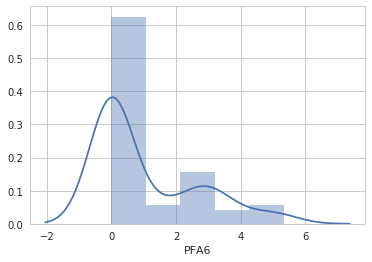

In [303]:
sns.distplot(g['PFA6'])

In [304]:
np.percentile(g['PFA6'],80)

2.8333333333333335

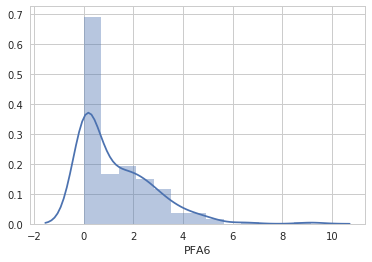

In [305]:
sns.distplot(d['PFA6'])

In [306]:
np.percentile(d['PFA6'],95)

4.0333333333333314

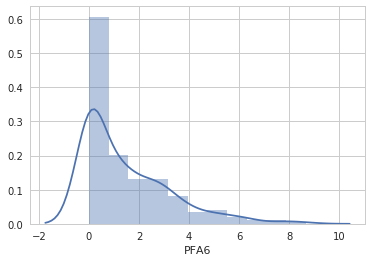

In [307]:
sns.distplot(m['PFA6'])

In [308]:
np.percentile(m['PFA6'],95)

5.0666666666666629

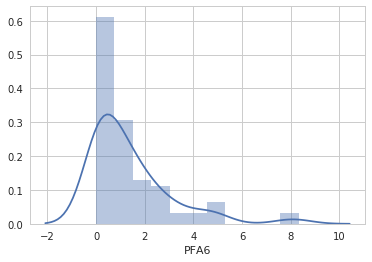

In [309]:
sns.distplot(a['PFA6'])

In [310]:
np.percentile(a['PFA6'],95)

4.666666666666667

In [311]:
attributes = ['Points_Cost','Points_Fixture', 'PFA6']

data_attributes = a[attributes]

data_attributes.head()

,Points_Cost,Points_Fixture,PFA6
373,1.372549,4.117647,4.666667
235,1.285714,6.882353,7.833333
187,1.272727,4.117647,4.666667
161,1.253333,5.529412,2.666667
159,1.236364,4.000000,2.000000


In [312]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Create silhouette score dictionary
s_score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]

# Print out `s_score_dict`
print(s_score_dict)

{2: [0.53395239660382943], 3: [0.53947549024959995], 4: [0.51124320267135925], 5: [0.5006202416221357], 6: [0.49962716968016058], 7: [0.50252860325323301], 8: [0.51645336848634349], 9: [0.51450802491744008], 10: [0.51665883304268334]}


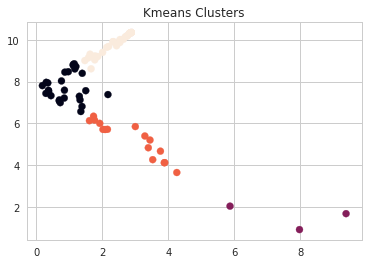

In [313]:
# Create K-means model and determine euclidian distances for each data point
kmeans_model = KMeans(n_clusters=4, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

# Create scatter plot using labels from K-means model as color
labels = kmeans_model.labels_

plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')

plt.show()

In [314]:
# Add labels from K-means model to `df` DataFrame and attributes list
a['labels'] = labels
attributes.append('labels')

In [315]:
a[a['labels']==3].head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,17,18,19,20,21,22,23,24,PFA6,labels
239,Solanke,4,47,20,0.425532,1.176471,a,0,1,0,...,1,1,0,1,0,2,0,0,0.666667,3
372,McBurnie,4,45,16,0.355556,0.941176,a,1,1,1,...,0,0,0,2,4,1,2,0,1.500000,3
236,Sturridge,4,79,25,0.316456,1.470588,d,0,2,5,...,0,0,0,0,0,0,0,0,0.000000,3
349,Berahino,4,56,15,0.267857,0.882353,a,2,5,0,...,0,1,0,0,2,1,0,0,0.666667,3
418,Okaka,4,53,14,0.264151,0.823529,a,7,0,0,...,0,1,1,1,2,0,1,0,1.000000,3
113,Batshuayi,4,81,20,0.246914,1.176471,a,1,-1,1,...,1,0,1,1,1,0,0,0,0.500000,3
50,Mousset,4,49,11,0.224490,0.647059,a,0,1,1,...,0,0,1,0,1,1,1,0,0.666667,3
457,Carroll,4,58,13,0.224138,0.764706,d,0,0,0,...,0,0,4,1,0,0,0,0,0.833333,3
303,Mitrovic,4,47,10,0.212766,0.588235,i,0,0,5,...,0,0,0,0,0,0,0,0,0.000000,3
258,Iheanacho,4,65,10,0.153846,0.588235,a,1,0,0,...,0,0,0,0,0,0,0,0,0.000000,3


In [316]:
a[a['labels']==2].head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,17,18,19,20,21,22,23,24,PFA6,labels
373,Ayew,4,51,70,1.372549,4.117647,a,2,2,6,...,2,1,8,2,7,2,8,0,4.666667,2
187,Depoitre,4,55,70,1.272727,4.117647,a,0,0,0,...,5,13,9,1,2,1,2,0,4.666667,2
161,Rooney,4,75,94,1.253333,5.529412,a,9,8,1,...,8,13,0,0,1,1,1,0,2.666667,2
159,Calvert-Lewin,4,55,68,1.236364,4.000000,a,5,5,1,...,1,6,1,2,1,1,1,0,2.000000,2
209,Vardy,4,85,99,1.164706,5.823529,a,13,2,2,...,5,2,8,2,9,0,2,0,3.833333,2
488,Joselu,4,55,59,1.072727,3.470588,a,0,0,7,...,1,2,5,2,2,0,7,0,3.000000,2
71,Murray,4,57,61,1.070175,3.588235,a,1,2,0,...,1,0,1,1,2,8,2,0,2.333333,2
437,Rodriguez,4,55,56,1.018182,3.294118,a,1,2,5,...,1,1,1,2,8,2,5,0,3.166667,2
48,Wilson,4,57,57,1.000000,3.352941,a,0,0,0,...,2,0,2,7,2,6,12,0,4.833333,2
302,Pérez,4,52,52,1.000000,3.058824,a,2,2,5,...,1,2,1,0,1,9,5,0,3.000000,2
